<a href="https://colab.research.google.com/github/Nina-Om/ArcGIS-MapBook-Toolbox/blob/master/2_AZ_NAM_Precipitation_S2S_forecast_BOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AZ-NM-NAM-Precipitation-S2S-forecast.ipynb


Andreas F. Prein (prein@ucar.edu) \\
02/24/2022 \\

--------------------------------------------------------------------------------

This notebook pulls ECMWF seasonal forecast data from the Copernicus data server and assigns weather types (WTs) during the North American Monsoon (NAM) season [(Prein et al., 2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL095602) for the Arizona West, Arizona East, New Mexico North, and New Mexico South regions and performs precipitation forecasting using both WTs and atmospheric variables.

# **Download ECMWF seasonal forecast data from the Copernicus data server.**

**Option 1:** ECMWF data can be downloaded from the [Copernicus data server](https://cds.climate.copernicus.eu/datasets/seasonal-original-pressure-levels?tab=download).

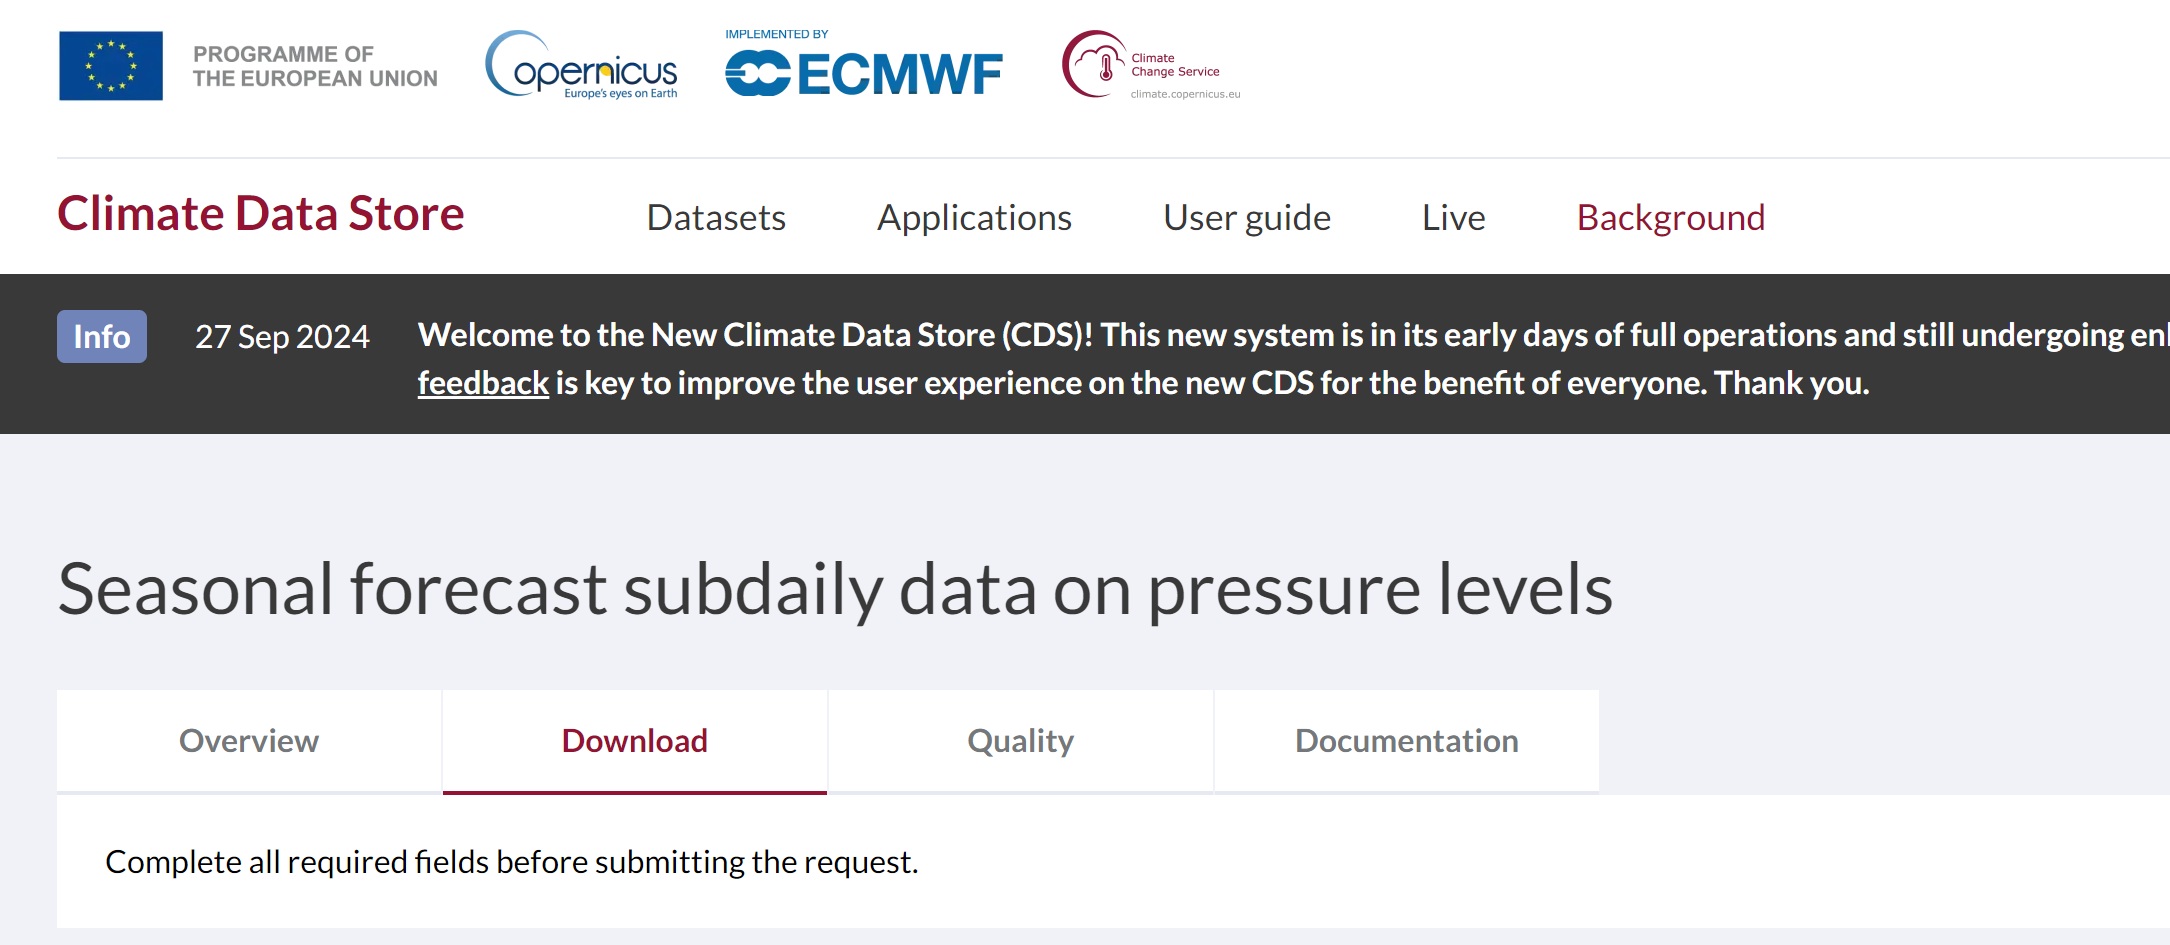

Please follow these steps to download the data:


*   select ECMEF in the "Originating centre" field
*   select "5" (model version 5) in the "System" field
*   select "Specific humidity" in Variable field
*   select 850 hPa in "Pressure level" field
*   select the years of interest in the "Year" field
*   select the month of interest in the "Month" field
*   select 1 in the "Day" field (ECMWF S2S forecasts are always started on the first day of the month)
*   select all fields in the "Leadtime hour" field
*   set the following "Geographical area": N = 60, E = -65, S = 20, W = -140
*   select GRIB in "Format" field
*   Click on "Sibmit Form"

You will be forwarded to the "Your requests" site, which allows you to download the data after it has been processed. Here we will take a shortcut and download a pre-compiled ECMWF forecast from Google Drive.

If you want to use the data that you downloaded from Copernicus, click on the folder item on the left side of the screen and upload the data from your local machine or Google Drive. You can also upload your data through this notebook following the next steps.

### Load all nescessary python modules

In [ ]:
# !pip install netCDF4
# !pip install matplotlib==3.1.3
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
# !pip3 install cfgrib
# !pip3 install eccodes
# !pip3 install climetlab
# !pip install --upgrade --no-cache-dir gdown
# !pip install rpy2==3.5.1

In [ ]:
!pip install netCDF4
!pip3 install cfgrib
!pip install eccodes
!pip install --upgrade --no-cache-dir gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 60.3 MB/s eta 0:00:00


In [ ]:
import glob
import pathlib
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import os
import mpl_toolkits
import pickle
import subprocess
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
# import pylab as plt
import scipy
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
from scipy.ndimage import gaussian_filter
import seaborn as sns
import sys
#import scipy.spatial.qhull as qhull  #scipy.spatial.qhull is deprecated. In SciPy ≥1.10, import directly from scipy.spatial.
from scipy.spatial import Delaunay
import xarray as xr
import cfgrib
#import ecmwflibs
import eccodes
import gdown
from pathlib import Path
from datetime import datetime
from scipy.spatial import Delaunay

In [ ]:
import subprocess

def safe_gdown(file_id, output):
    try:
        subprocess.run(["gdown", file_id, "-O", output], check=True)
        return True
    except subprocess.CalledProcessError:
        print(f"⚠️ Download failed for {file_id}")
        return False


In [ ]:
#import shutil
#shutil.rmtree('/content/drive', ignore_errors=True)

from google.colab import drive
drive.mount('/content/drive')

### **Option 2:** downloading data from the Copernicus Climate Data Store (CDS) using the CDS API

**Step 1:** Create a CDS Account
Visit: [Login-Register](https://accounts.ecmwf.int/auth/realms/ecmwf/login-actions/registration?client_id=cds&tab_id=qFk-rVloK1c)

Create an account and confirm your email.

**Step 2:** Get Your API Key
Go to: [https://cds.climate.copernicus.eu/how-to-api](https://cds.climate.copernicus.eu/how-to-api)

After logging in, you will see a code block like this:

```
url: https://cds.climate.copernicus.eu/api/v2
key: 123456:abcd1234-ef56-7890-gh12-ijklmnop3456
```






**Step 3:** Install CDS API Client

In [ ]:
!pip install "cdsapi>=0.7.4"

**Step 4:** Create .cdsapirc Configuration File. \
**Replace the key with yours.**

In [ ]:
cdsapi_config = """
url: https://cds.climate.copernicus.eu/api
key: 1c0f4b12-dc30-4e32-8c89-7c90961e8a6e
"""

with open('/root/.cdsapirc', 'w') as f:
    f.write(cdsapi_config.strip())

!cat /root/.cdsapirc

url: https://cds.climate.copernicus.eu/api
key: 1c0f4b12-dc30-4e32-8c89-7c90961e8a6e

**Step 5:** Import the Client and Download Data

In [ ]:
# -------------------
# Config
# -------------------
plot_years = [2023,2024,2025] #ERA5 years for the plots, for additional years you shuld downlaod ERA and ECMWF data in Step1 and Step2 or use prepared ECMWF data in the next cell and ERA data files in this ntebook.
year_forecast = 2025
ERA5_DOWNLOAD_MONTHS = [6, 7, 8]           # download if available
MONTHS_ERA5 = [6, 7, 8, 9, 10]    # analyze/plot


In [9]:
## Old datasets

# Jun 2023
!gdown 'https://drive.google.com/uc?id=198e4trYOl_MR2fewzQi0k683muQSZazq' -O ECMWF_forecast_2023.grib
# June 2024
!gdown 'https://drive.google.com/uc?id=1r8pnGoBybkqR3AlJPYG6TgcqeFevS6n0' -O ECMWF_forecast_2024.grib
#June 2025
!gdown 'https://drive.google.com/uc?id=1LFJUpw6XxxA8hNCKkTZENeFVN4xomo9W' -O ECMWF_forecast_2025.grib

Downloading...
From (original): https://drive.google.com/uc?id=198e4trYOl_MR2fewzQi0k683muQSZazq
From (redirected): https://drive.google.com/uc?id=198e4trYOl_MR2fewzQi0k683muQSZazq&confirm=t&uuid=b2868c6e-5872-4ce2-8202-517bd8ab2983
To: /content/ECMWF_forecast_2023.grib
100% 139M/139M [00:02<00:00, 63.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1r8pnGoBybkqR3AlJPYG6TgcqeFevS6n0
From (redirected): https://drive.google.com/uc?id=1r8pnGoBybkqR3AlJPYG6TgcqeFevS6n0&confirm=t&uuid=ba62ba82-08bf-4e6b-ba76-5722d78b3d15
To: /content/ECMWF_forecast_2024.grib
100% 139M/139M [00:01<00:00, 85.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1LFJUpw6XxxA8hNCKkTZENeFVN4xomo9W
From (redirected): https://drive.google.com/uc?id=1LFJUpw6XxxA8hNCKkTZENeFVN4xomo9W&confirm=t&uuid=36a0fe8b-c485-4cbc-a82e-8f01e3fd8109
To: /content/ECMWF_forecast_2025.grib
100% 139M/139M [00:01<00:00, 104MB/s] 


## Step 1. Cell below pulls ECMWF data of July 2025 from Copernicus portal.





In [ ]:
# ECMWF forecast
import cdsapi

dataset = "seasonal-original-pressure-levels"
request = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": ["specific_humidity"],
    "pressure_level": ["850"],
    "year": [str(year_forecast)],
    "month": ["06"],
    "day": ["01"],
    "leadtime_hour": [str(h) for h in range(12, 5161 + 12, 12)],
    "data_format": "grib",
    "area": [60, -140, 20, -65]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(f"ECMWF_forecast_{year_forecast}.grib")

2025-10-06 02:27:44,522 INFO Request ID is a8cfddc1-eee0-4339-94f5-1657d7915058
INFO:ecmwf.datastores.legacy_client:Request ID is a8cfddc1-eee0-4339-94f5-1657d7915058
2025-10-06 02:27:44,765 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-06 02:27:59,312 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


93c4fb5822ea2a3a09ff417158a60314.grib:   0%|          | 0.00/133M [00:00<?, ?B/s]

'ECMWF_forecast_2025.grib'

### Step2. Download ERA5 data over the CONUS. Files name are consistent with **RDA d633000** collections.
(e.g. /glade/campaign/collections/gdex/data/d633000/e5.oper.an.pl/202506/)




In [ ]:
# Download and process ERA5
RUN_ERA5_DOWNLOAD = False # False to use prepared data in shared drive, True to pull data from Copernicus portal

###  Your data will be saved in "dir_era5" (adjust it if needed).

In [ ]:
# set the folder path (adjusts if needed)
dir_era5 = "/content/drive/MyDrive/Colab Notebooks/ERA5/Q850/"
os.makedirs(dir_era5, exist_ok=True)

print("Data will be saved under:", dir_era5)

Data will be saved under: /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/


In [ ]:
import os, calendar, time
import numpy as np
import pandas as pd
import xarray as xr
import cdsapi

# ----------------------------
# Configuration
# ----------------------------
AREA = [60, -140, 20, -65]
PRESSURE_LEVEL = "850"
TIMES = [f"{h:02d}:00" for h in range(24)]
GRID = [0.25, 0.25]
DATASET = "reanalysis-era5-pressure-levels"

# ----------------------------
# Toggle to control whether to run
# ----------------------------
if RUN_ERA5_DOWNLOAD:

    # Fill value for Q
    fillval = np.float32(9.999e+20)

    # Start CDS client
    c = cdsapi.Client(timeout=600)

    for year in [year_forecast]:
        for month in ERA5_DOWNLOAD_MONTHS:
            yyyymm = f"{year}{month:02d}"
            out_dir = os.path.join(dir_era5, yyyymm)
            os.makedirs(out_dir, exist_ok=True)

            ndays = calendar.monthrange(year, month)[1]
            for day in range(1, ndays + 1):
                ymd = f"{year}{month:02d}{day:02d}"
                target = os.path.join(out_dir, f"e5.oper.an.pl.128_133_q.ll025sc.{ymd}00_{ymd}23.nc")
                raw_path = target + ".tmp"

                if os.path.exists(target):
                    print(f"[skip] {target}")
                    continue

                req = {
                    "product_type": "reanalysis",
                    "format": "netcdf",
                    "variable": "specific_humidity",
                    "year": str(year),
                    "month": f"{month:02d}",
                    "day": f"{day:02d}",
                    "time": TIMES,
                    "pressure_level": [PRESSURE_LEVEL],
                    "area": AREA,
                    "grid": GRID,
                }

                # ---- Download with retry ----
                for attempt in range(5):
                    try:
                        c.retrieve(DATASET, req).download(raw_path)
                        break
                    except Exception as e:
                        if "requested is available yet" in str(e):
                            print(f"[skip] {ymd} not available")
                            raw_path = None
                            break
                        time.sleep(5)
                if not raw_path or not os.path.exists(raw_path):
                    continue

                # ---- Open and convert ----
                ds = xr.open_dataset(raw_path, decode_times=True)

                if "expver" in ds.coords:
                    if "expver" in ds.dims and "0001" in ds["expver"].values:
                        ds = ds.sel(expver="0001")

                if "valid_time" in ds.dims:
                    ds = ds.rename({"valid_time": "time"})
                if "pressure_level" in ds.dims:
                    ds = ds.rename({"pressure_level": "level"})
                if "q" in ds.data_vars:
                    ds = ds.rename({"q": "Q"})

                ds["Q"] = ds["Q"].transpose("time", "level", "latitude", "longitude")

                # Replace NaNs with fillval
                qvals = ds["Q"].values
                ds["Q"].values = np.where(np.isnan(qvals), fillval, qvals)

                # Add utc_date
                dt = pd.to_datetime(ds.time.values)
                utc_vals = [int(d.strftime('%Y%m%d%H')) for d in dt]
                ds["utc_date"] = ("time", utc_vals)
                ds["utc_date"].attrs["long_name"] = "UTC date yyyy-mm-dd hh:00:00 as yyyymmddhh"
                ds["utc_date"].attrs["units"] = "Gregorian_year month day hour"

                ds["Q"].attrs.pop("_FillValue", None)

                ds["Q"].attrs.update({
                    "long_name": "Specific humidity",
                    "short_name": "q",
                    "units": "kg kg**-1",
                    "missing_value": fillval,
                    "original_format": "WMO GRIB 1 with ECMWF local table",
                    "ecmwf_local_table": 128,
                    "ecmwf_parameter": 133,
                    "rda_dataset": "ds633.0",
                    "rda_dataset_url": "https:/rda.ucar.edu/datasets/ds633.0/",
                    "rda_dataset_doi": "DOI: 10.5065/BH6N-5N20",
                    "rda_dataset_group": "ERA5 atmospheric pressure level analysis [netCDF4]",
                    "QuantizeGranularBitGroomNumberOfSignificantDigits": 7,
                    "minimum_value": float(np.nanmin(ds["Q"].values)),
                    "maximum_value": float(np.nanmax(ds["Q"].values)),
                })

                ds.attrs.update({
                    "Conventions": "CF-1.6",
                    "DATA_SOURCE": "ECMWF: https://cds.climate.copernicus.eu, Copernicus Climate Data Store",
                    "NETCDF_CONVERSION": "Manual RDA-style reformatting",
                    "NETCDF_VERSION": "4.9.2",
                    "NETCDF_COMPRESSION": "NCO: Precision-preserving compression to netCDF4/HDF5",
                    "history": f"{time.strftime('%Y-%m-%dT%H:%M:%S')} manual conversion from CDS to RDA-style",
                    "NCO": "netCDF Operators version 5.3.1 (http://nco.sf.net)"
                })

                enc = {
                    "Q": {
                        "zlib": True, "complevel": 1, "shuffle": True,
                        "dtype": "float32", "_FillValue": fillval
                    },
                    "time": {
                        "units": "hours since 1900-01-01 00:00:00",
                        "calendar": "gregorian"
                    },
                    "utc_date": {"dtype": "int32"},
                    "level": {"zlib": False},
                    "latitude": {"zlib": False},
                    "longitude": {"zlib": False}
                }

                ds.to_netcdf(target, format="NETCDF4", encoding=enc)
                ds.close()
                os.remove(raw_path)
                print(f"[ok] {target}")


### Define functions for data processing

In [ ]:
# Interpolation functions
def interp_weights(xy, uv,d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

# ###################################################
# ###################################################
def PreprocessWTdata(DailyVarsInput,                 # WT data [time,lat,lon,var]
                     RelAnnom=1,                     # calculate relative anomalies [1-yes; 0-no]
                     SmoothSigma=0,                  # Smoothing stddev (Gaussian smoothing)
                     RemoveAnnualCycl=1,             # remove annual cycle [1-yes; 0-no]
                     NormalizeData='D',              # normalize variables | options are  - 'C' - climatology
                                                     # - 'D' - daily (default)
                                                     # - 'N' - none
                     ReferencePer=None,              # period for normalizing the data
                     Normalize = None):              # mean, std, and spatial mean for normalization


    DailyVars = np.copy(DailyVarsInput)
    # Calculate relative anomaly
    if RelAnnom == 1:
        # we have to work with absolute values for this since we risk to divide by zero values in the climatology
        DailyVars=np.abs(DailyVars)
        if Normalize is None:
            if ReferencePer is None:
                DailyVars=(DailyVars-np.mean(DailyVars, axis=0)[None,:])/np.mean(DailyVars, axis=0)[None,:]
            else:
                DailyVars=(DailyVars-np.mean(DailyVars[ReferencePer], axis=0)[None,:])/np.mean(DailyVars[ReferencePer], axis=0)[None,:]
        else:
            # calculate anomalies with provided climatology
            DailyVars=(DailyVars - Normalize[2][None,:])/Normalize[2][None,:]

    if len(DailyVars.shape) == 3:
        DailyVars = DailyVars[:,:,:,None]
    # Spatially smooth the data
    DailyVars=gaussian_filter(DailyVars[:,:,:,:], sigma=(0,SmoothSigma,SmoothSigma,0))

    # Remove the annual cycle
    if RemoveAnnualCycl == 1:
        SpatialMeanData=pd.DataFrame(np.nanmean(DailyVars, axis=(1,2)))
        Averaged=np.roll(np.array(SpatialMeanData.rolling(window=21).mean()), -10, axis=0)
        Averaged[:10,:]=Averaged[11,:][None,:]; Averaged[-10:,:]=Averaged[-11,:][None,:]
        DailyVars=DailyVars-Averaged[:,None,None,:]

    # Normalize the data
    if NormalizeData == 'D':
        DailyVars=(DailyVars-np.mean(DailyVars, axis=(1,2))[:,None,None,:])/np.std(DailyVars, axis=(1,2))[:,None,None,:]
    elif NormalizeData == 'C':
        if Normalize is None:
            if ReferencePer is None:
                DailyVars=(DailyVars-np.mean(DailyVars, axis=(0,1,2))[None,None,None,:])/np.std(DailyVars, axis=(0,1,2))[None,None,None,:]
            else:
                DailyVars=(DailyVars-np.mean(DailyVars[ReferencePer], axis=(0,1,2))[None,None,None,:])/np.std(DailyVars[ReferencePer], axis=(0,1,2))[None,None,None,:]
        else:
            # use predefined normalization terms
            DailyVars=((DailyVars - Normalize[0][None,None,None,:]))/Normalize[1][None,None,None,:]
        DailyVars[np.isnan(DailyVars)]=0

    return DailyVars


# ===================================================================
def EucledianDistance(DailyVars,
                      rgrClustersFin,
                      MoreDistances=0):  # if this key is 1 the function will calculate additional distance metrics
    from scipy.spatial import distance

    SHAPE=DailyVars.shape
    Data_flatten=np.reshape(DailyVars, (SHAPE[0],SHAPE[1]*SHAPE[2]*SHAPE[3]))
    EucledianDist=np.zeros((SHAPE[0],rgrClustersFin[0].shape[0])); EucledianDist[:]=np.nan
    Correlation=np.copy(EucledianDist)
    Manhattan=np.copy(EucledianDist)
    Chebyshev=np.copy(EucledianDist)
    for dd in range(SHAPE[0]):
        EucledianDist[dd,:] = np.array([np.linalg.norm(rgrClustersFin[0][wt,:]-Data_flatten[dd,:]) for wt in range(rgrClustersFin[0].shape[0])])
        Correlation[dd,:] = np.array([np.corrcoef(rgrClustersFin[0][wt,:],Data_flatten[dd,:])[0][1] for wt in range(rgrClustersFin[0].shape[0])])

        if MoreDistances == 1:
            for wt in range(rgrClustersFin[0].shape[0]):
                x = Data_flatten[dd,:] #rgrClustersFin[0][wt,:]
                YY = rgrClustersFin[0][wt,:] #+np.random.rand(len(rgrClustersFin[0][wt,:]))
                XX = Data_flatten[dd,:]

                # ----- Manhattan Distance ------
                # Quoting from the paper, “On the Surprising Behavior of Distance Metrics in High Dimensional Space”, by Charu C. Aggarwal, Alexander
                # Hinneburg, and Daniel A. Kiem. “ for a given problem with a fixed (high) value of the dimensionality d, it may be preferable to use
                # lower values of p. This means that the L1 distance metric (Manhattan Distance metric) is the most preferable for high dimensional applications.”
                Manhattan[dd,wt] = distance.cityblock(XX, YY)
                Chebyshev[dd,wt] = distance.chebyshev(XX, YY)

    return EucledianDist, Correlation, Manhattan, Chebyshev

In [ ]:
# -----------------------------
# USER SETTINGS
# -----------------------------
MONTHS = [6, 7, 8, 9, 10]
# Setup clustering algorithm
ClusterMeth='HandK'  # current options are ['HandK','hdbscan']
ClusterBreakup = 0   # breakes up clusters that are unproportionally large (only for hdbscan)
RelAnnom=1           # 1 - calculates daily relative anomalies
NormalizeData='C'    # normalize variables | options are  - 'C' - climatology
                                                        # - 'D' - daily (default)
                                                        # - 'N' - none
MinDistDD=1          # minimum nr of days between XWT events
RemoveAnnualCycl=0   # remove annual cycle in varaiables with 21 day moving average

ECMWF_FORECAST_GRIB_PATH = Path(f"ECMWF_forecast_{year_forecast}.grib")

In [ ]:
def cached_gdown(file_id: str, out_path: Path, max_retries=2) -> Path:
    """Download a Drive file only if it's missing or empty."""
    out_path = Path(out_path)
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path
    url = f"https://drive.google.com/uc?id={file_id}"
    for attempt in range(1, max_retries + 1):
        logging.info(f"⬇️  Downloading {out_path.name} (try {attempt}/{max_retries})")
        gdown.download(url, str(out_path), quiet=False)
        if out_path.exists() and out_path.stat().st_size > 0:
            break
        time.sleep(1.0)
    if not out_path.exists() or out_path.stat().st_size == 0:
        raise RuntimeError(f"Download failed for {file_id} -> {out_path}")
    return out_path

In [ ]:
### Data dir on glade: "/glade/campaign/mmm/c3we/mingge/COEXIST/AZ_S2S_DATA/"

In [ ]:
# =========================
# Batch runner for all regions (JJASO WTs -> PDF per region)
# =========================
import os, pickle, logging, time
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cfgrib
import gdown

logging.basicConfig(level=logging.INFO, format="%(message)s")

# -----------------------------
# Region configs (IDs + WT maps)
# -----------------------------
REGION_CFG = {
    'Arizona West': {
        'sCentroidFile': '13YM10r-THW6GJurtJp5FpGB9YYgfFx1Y',
        'sERA_data':     '1NXfJ_I8Ow5X_wGSrvOUc80weeoXJMjwm',
        'sWTdata':       '1LdA0oZvx5Usden9Qi8vUyKmMwYThO5LR',
        'NormFact':      '1d83LgYNfAXD0IJn9FEy82VgMWkEZyY-W', #Normalization_Factors_IFS_1501.npz
        'NormFact_era':  '18qThrR7oCcRE24A22hbqzrtVuybs8ZkZ', #NormalizationFactors_era5_Arizona West.npz
        'WTsort':        [0, 2, 1],
        're':            0,
    },
    'Arizona East': {
        'sCentroidFile': '1kt-jC2pYa6S-bhpo4hhGDLu7PLX-Sbq6',
        'sERA_data':     '1a_fOafx4GkX1c53gNIRJb4OTs3EdAg6m',
        'sWTdata':       '1olEXr3NBED4I5Ddf0o0guFCOlxjoLorL',
        'NormFact':      '1d0il_lUbH2fTMu7cKbi_mfcM8ZslzpFZ', #Normalization_Factors_IFS_1502.npz
        'NormFact_era':  '1vPzPOwBTugMhFNjqfUAYmTR0m0a6RK0r', #NormalizationFactors_era5_Arizona East.npz
        'WTsort':        [1, 2, 0],
        're':            1,
    },
    'NM North': {
        'sCentroidFile': '1LxOGHeDwh2xd3JxBf6GRTv3dzluPBpew',
        'sERA_data':     '1p1EHa1hxoz10o3cwXfKm9ThEoLIyfyQ8',
        'sWTdata':       '1emPVA1UZgN4FI-oGfo3f_rc7-oUNVL0v',
        'NormFact':      '18l7Z0oouQCudTxhR4u7kPnKeFkMpOP1T', #Normalization_Factors_IFS_HUC6-00.npz
        'NormFact_era':  '1hroqawuPKIEMUH5xiDIVXtp1UB6kKYki', #NormalizationFactors_era5_NM North.npz
        'WTsort':        [1, 2, 0],
        're':            2,
    },
    'NM South': {
        'sCentroidFile': '1Ja2zyF4C92cRykpAJSyPVy_TIYd--feP',
        'sERA_data':     '15O54WG27m860i9T3Mdckj5xLJcZ3MCfu',
        'sWTdata':       '1-Pwx-WqsJ7dIHlKBvgSzHUDTAM6xS62X',
        'NormFact':      '1VN5cRkxxegu0AU5ijkkd9p623vVsFZI9', #Normalization_Factors_IFS_HUC6-03.npz
        'NormFact_era':  '1k1okjeaJXy4iCSB4ca0TcJw7pAaXfuPc', #NormalizationFactors_era5_NM South.npz
        'WTsort':        [0, 1, 2],
        're':            3,
    },
}

# -----------------------------
# Common files (download once)
# -----------------------------
COMMON_IDS = {
    'ERA_const':  '1_NVUNJFsAcfECLaHZlYi7CxFF7hA3FuO',        # ERA_Inerim_stationary-files_75x75.nc
    'NMME_coords':'1RENjwKXaMH0PNbui6qO6_J_hgIKX9iW6',        # Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc
    'WT_clim':    '1-xNAnJHyP9KSaJ1fvx8P95PlCDP3nQU6',        # ECMWF_WT-frequency_climatology.npz
    # Known-good forecast GRIB ID you confirmed works
    'FORECAST':   ECMWF_FORECAST_GRIB_PATH,
}
FORECAST_ID = COMMON_IDS['FORECAST']
CACHE_ROOT = Path("/content/cache")
COMMON_DIR = CACHE_ROOT / "common"
REGIONS_DIR = CACHE_ROOT / "regions"
OUT_DIR = Path("/content")
COMMON_DIR.mkdir(parents=True, exist_ok=True)
REGIONS_DIR.mkdir(parents=True, exist_ok=True)

# Download common files once and check file size
ERA_CONST_PATH  = cached_gdown(COMMON_IDS['ERA_const'],  COMMON_DIR / 'ERA_Inerim_stationary-files_75x75.nc')
if not ERA_CONST_PATH.exists() or ERA_CONST_PATH.stat().st_size == 0:
    raise FileNotFoundError(f"Downloaded file is empty: {ERA_CONST_PATH}")

NMME_COORD_PATH = cached_gdown(COMMON_IDS['NMME_coords'], COMMON_DIR / 'Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc')
if not NMME_COORD_PATH.exists() or NMME_COORD_PATH.stat().st_size == 0:
    raise FileNotFoundError(f"Downloaded file is empty: {NMME_COORD_PATH}")

WT_CLIM_PATH    = cached_gdown(COMMON_IDS['WT_clim'],    COMMON_DIR / 'ECMWF_WT-frequency_climatology.npz')
if not WT_CLIM_PATH.exists() or WT_CLIM_PATH.stat().st_size == 0:
    raise FileNotFoundError(f"Downloaded file is empty: {WT_CLIM_PATH}")

FORECAST_PATH = COMMON_IDS['FORECAST']  # This is already a Path("ECMWF_forecast.grib")
if not FORECAST_PATH.exists() or FORECAST_PATH.stat().st_size == 0:
    raise FileNotFoundError(f"Forecast file is empty: {FORECAST_PATH}")


# Pre-load common grids
nc = Dataset(NMME_COORD_PATH, mode="r")
if   'lon'      in nc.variables: _lon, _lat = nc.variables['lon'][:], nc.variables['lat'][:]
elif 'LON'      in nc.variables: _lon, _lat = nc.variables['LON'][:], nc.variables['LAT'][:]
elif 'g0_lon_4' in nc.variables: _lon, _lat = nc.variables['g0_lon_4'][:], nc.variables['g0_lat_3'][:]
nc.close()

LonS_base, LatS_base = np.meshgrid(np.array(_lon), np.array(_lat))
LonS_base = LonS_base.copy()
LatS_base = LatS_base.copy()
LonS_base[LonS_base > 180] -= 360
LatS_base = LatS_base[::-1]  # IFS lat N->S

# WT climatology (for plotting)
WT_CLIM = np.load(WT_CLIM_PATH)
wt_freq_climmean = WT_CLIM['wt_freq_climmean']

Downloading...
From: https://drive.google.com/uc?id=1_NVUNJFsAcfECLaHZlYi7CxFF7hA3FuO
To: /content/cache/common/ERA_Inerim_stationary-files_75x75.nc
100%|██████████| 2.55M/2.55M [00:00<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RENjwKXaMH0PNbui6qO6_J_hgIKX9iW6
To: /content/cache/common/Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc
100%|██████████| 8.05M/8.05M [00:00<00:00, 161MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-xNAnJHyP9KSaJ1fvx8P95PlCDP3nQU6
To: /content/cache/common/ECMWF_WT-frequency_climatology.npz
100%|██████████| 104k/104k [00:00<00:00, 32.2MB/s]


# ERA5 processing and Reanalysis WTs

In [ ]:
def grNormalization(data_4d, vtx, wts, n_lat, n_lon):
    grNormalizationFactors = {}
    Mean = np.nanmean(data_4d, axis=(0,1))

    # interpolate to centroid grid
    Mean_wt = interpolate(Mean.flatten(), vtx, wts).reshape(n_lat, n_lon)

    # reshape Mean by adding back axis=(1,2) because of np.nanmean
    Anomalies = (data_4d - Mean[None,None,:,:])/Mean[None,None,:,:]

    # Convert input scalar to 1d array with at least one dimension
    # in order to call function  PreprocessWTdata
    # Ensure elements are numpy arrays before saving
    Normalize = [np.atleast_1d(np.nanmean(Anomalies)), np.atleast_1d(np.nanstd(Anomalies)), Mean_wt]
    grNormalizationFactors[0] = Normalize
    print('Amomalies', np.nanmean(Anomalies))
    print(flnm_n)
    # Save the dictionary directly
    np.savez(flnm_n, grNormalizationFactors = grNormalizationFactors)
    #NormData = np.load(flnm_n, allow_pickle=True)
    # NormData = NormData['grNormalizationFactors']

**Convert 12-hourly to daily ERA data for plot_years defined on top. \
Skips years with no files or on read errors and continues.**


==================== Processing Region: Arizona West ====================


Downloading...
From (original): https://drive.google.com/uc?id=1LdA0oZvx5Usden9Qi8vUyKmMwYThO5LR
From (redirected): https://drive.google.com/uc?id=1LdA0oZvx5Usden9Qi8vUyKmMwYThO5LR&confirm=t&uuid=c5f75dda-5f87-47f2-b310-71021adea7d0
To: /content/cache/regions/Arizona_West/Clusters_1982_2018_Q850_JJASO.pkl
100%|██████████| 206M/206M [00:00<00:00, 220MB/s]


WT grid shape: (18, 17)


Downloading...
From: https://drive.google.com/uc?id=18qThrR7oCcRE24A22hbqzrtVuybs8ZkZ
To: /content/cache/regions/Arizona_West/NormalizationFactors_era5_Arizona West.npz
100%|██████████| 3.08k/3.08k [00:00<00:00, 4.08MB/s]


>> Year: 2023
[DEBUG] Found 30 files for 202306
[DEBUG] Found 31 files for 202307
[DEBUG] Found 31 files for 202308
[DEBUG] Found 30 files for 202309
[DEBUG] Found 31 files for 202310
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2023.nc with 153 days.
[INFO] Arizona West 2023: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2023.nc, date range 2023-06-01 00:00:00 -> 2023-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-West-2023_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2023_daily.csv


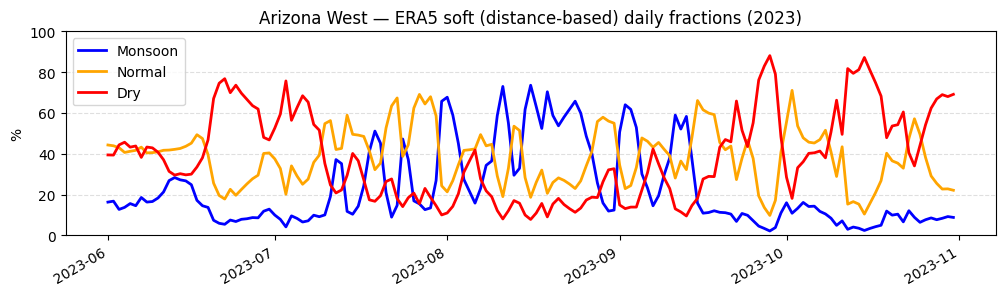

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-West-2023.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         15.03       36.79    48.18
7         21.03       45.33    33.64
8         45.58       35.92    18.50
9         24.43       38.39    37.18
10         8.68       35.84    55.49


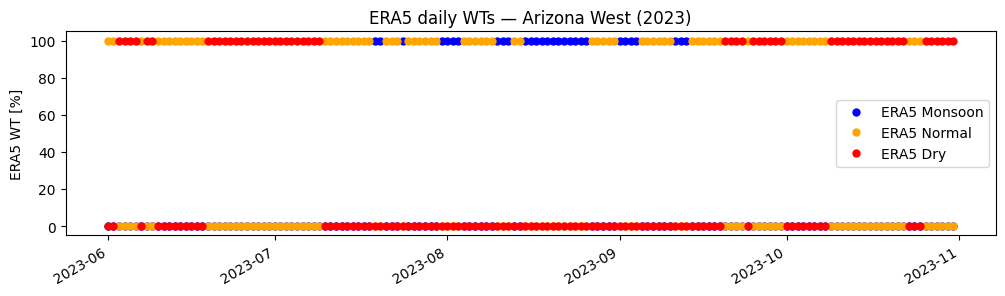

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-West-2023.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2023.csv
>> Year: 2024
[DEBUG] Found 30 files for 202406
[DEBUG] Found 31 files for 202407
[DEBUG] Found 31 files for 202408
[DEBUG] Found 30 files for 202409
[DEBUG] Found 31 files for 202410
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2024.nc with 153 days.
[INFO] Arizona West 2024: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2024.nc, date range 2024-06-01 00:00:00 -> 2024-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-West-2024_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2024_daily.csv


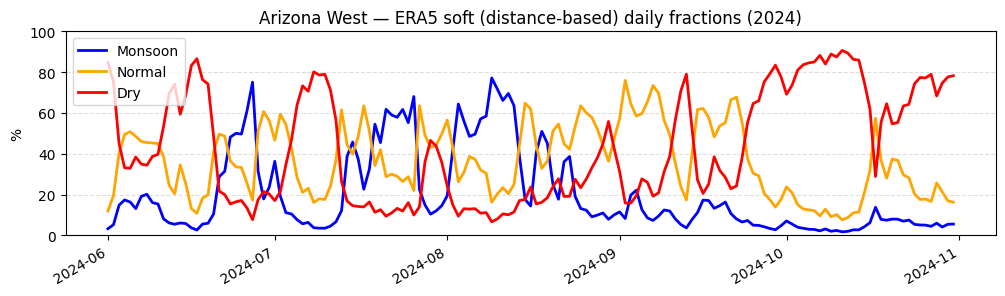

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-West-2024.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         20.57       35.37    44.06
7         27.27       38.31    34.42
8         37.43       41.69    20.88
9          9.85       48.06    42.09
10         5.01       20.55    74.44


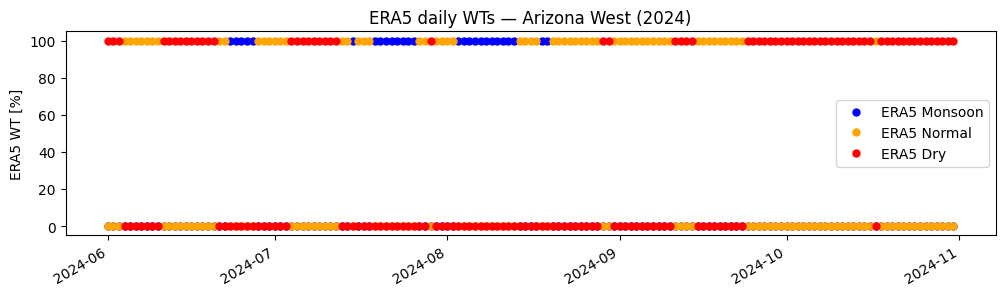

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-West-2024.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2024.csv
>> Year: 2025
[DEBUG] Found 30 files for 202506
[DEBUG] Found 31 files for 202507
[DEBUG] Found 31 files for 202508
[DEBUG] Found 18 files for 202509
[DEBUG] No files found for pattern: /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/202510/e5.oper.an.pl.128_133_q.ll025sc.*.nc
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2025.nc with 110 days.
[INFO] Arizona West 2025: reading 110 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_West/q850_2025.nc, date range 2025-06-01 00:00:00 -> 2025-09-18 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-West-2025_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2025_daily.csv


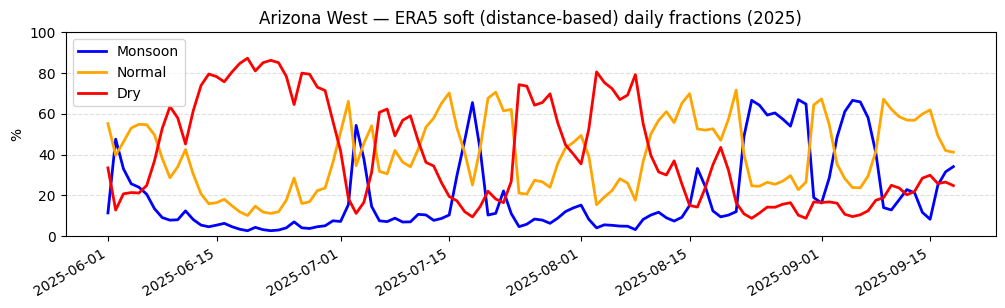

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-West-2025.png
Soft monthly means (percent):
   monsoon_pct  normal_pct  dry_pct
6        10.09       28.17    61.73
7        16.83       44.64    38.53
8        25.34       40.54    34.12
9        32.51       47.76    19.74


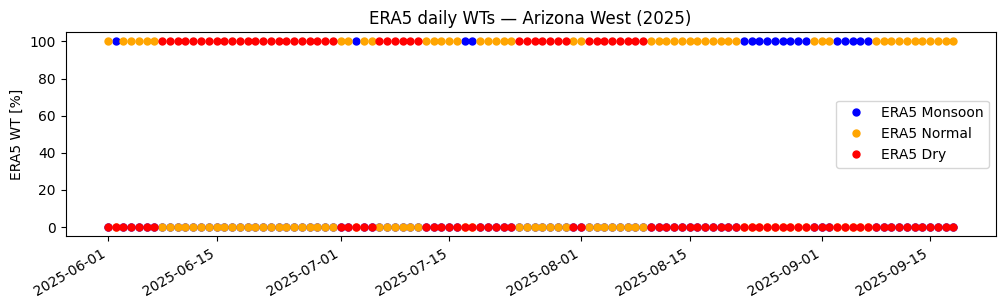

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-West-2025.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-West-2025.csv

==================== Processing Region: Arizona East ====================


Downloading...
From (original): https://drive.google.com/uc?id=1olEXr3NBED4I5Ddf0o0guFCOlxjoLorL
From (redirected): https://drive.google.com/uc?id=1olEXr3NBED4I5Ddf0o0guFCOlxjoLorL&confirm=t&uuid=747c8861-9eb4-4f38-9295-ece7307d67e3
To: /content/cache/regions/Arizona_East/Clusters_1982_2018_Q850_JJASO.pkl
100%|██████████| 181M/181M [00:01<00:00, 179MB/s]


WT grid shape: (16, 17)


Downloading...
From: https://drive.google.com/uc?id=1vPzPOwBTugMhFNjqfUAYmTR0m0a6RK0r
To: /content/cache/regions/Arizona_East/NormalizationFactors_era5_Arizona East.npz
100%|██████████| 2.80k/2.80k [00:00<00:00, 9.75MB/s]


>> Year: 2023
[DEBUG] Found 30 files for 202306
[DEBUG] Found 31 files for 202307
[DEBUG] Found 31 files for 202308
[DEBUG] Found 30 files for 202309
[DEBUG] Found 31 files for 202310
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2023.nc with 153 days.
[INFO] Arizona East 2023: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2023.nc, date range 2023-06-01 00:00:00 -> 2023-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-East-2023_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2023_daily.csv


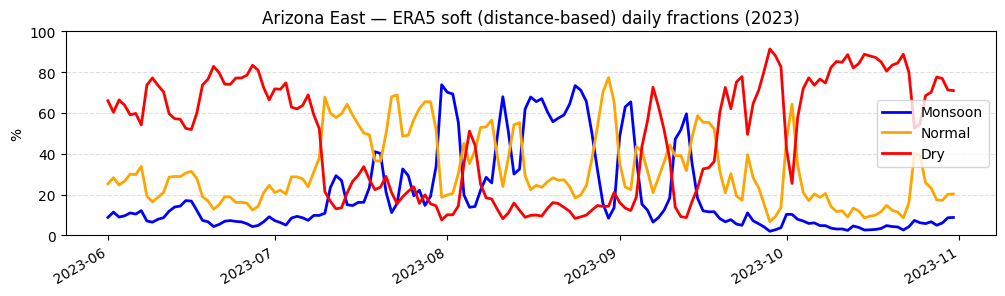

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-East-2023.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6          9.00       22.37    68.63
7         20.05       46.47    33.48
8         46.40       37.54    16.07
9         20.16       32.06    47.78
10         5.27       20.03    74.70


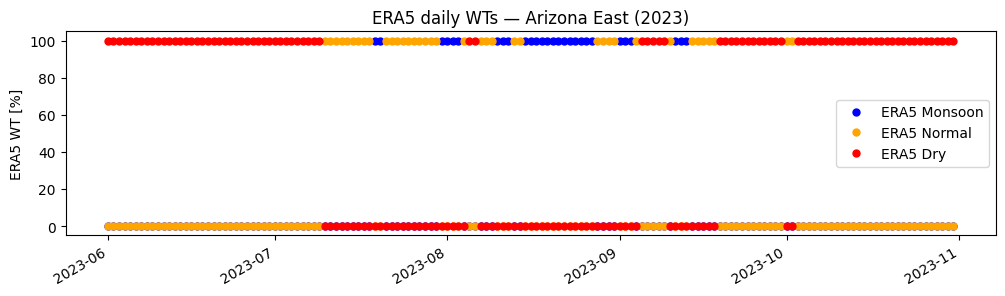

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-East-2023.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2023.csv
>> Year: 2024
[DEBUG] Found 30 files for 202406
[DEBUG] Found 31 files for 202407
[DEBUG] Found 31 files for 202408
[DEBUG] Found 30 files for 202409
[DEBUG] Found 31 files for 202410
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2024.nc with 153 days.
[INFO] Arizona East 2024: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2024.nc, date range 2024-06-01 00:00:00 -> 2024-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-East-2024_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2024_daily.csv


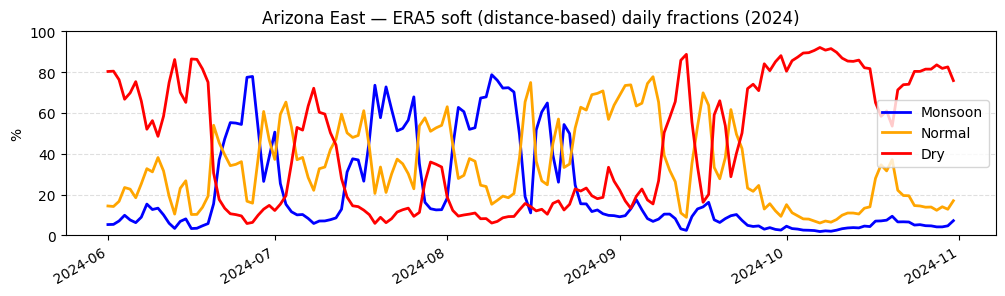

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-East-2024.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         22.67       27.43    49.90
7         30.39       42.14    27.47
8         42.90       42.61    14.48
9          8.23       42.43    49.34
10         4.53       14.86    80.61


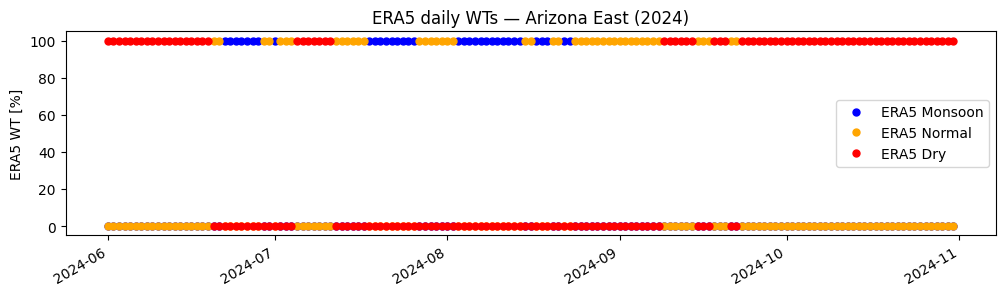

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-East-2024.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2024.csv
>> Year: 2025
[DEBUG] Found 30 files for 202506
[DEBUG] Found 31 files for 202507
[DEBUG] Found 31 files for 202508
[DEBUG] Found 18 files for 202509
[DEBUG] No files found for pattern: /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/202510/e5.oper.an.pl.128_133_q.ll025sc.*.nc
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2025.nc with 110 days.
[INFO] Arizona East 2025: reading 110 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/Arizona_East/q850_2025.nc, date range 2025-06-01 00:00:00 -> 2025-09-18 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_Arizona-East-2025_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2025_daily.csv


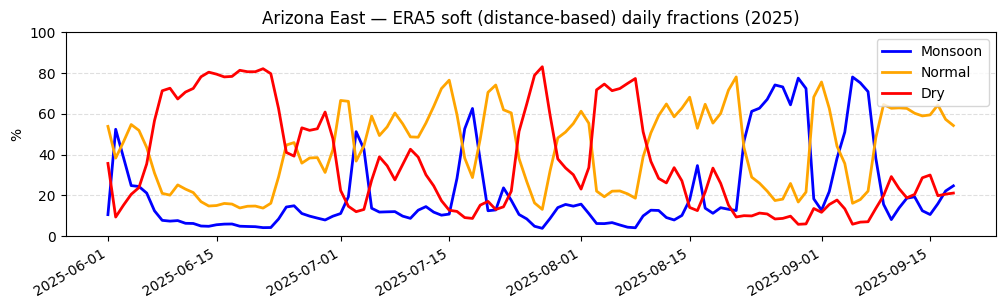

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_Arizona-East-2025.png
Soft monthly means (percent):
   monsoon_pct  normal_pct  dry_pct
6        11.82       29.57    58.61
7        18.72       50.89    30.40
8        27.63       42.43    29.94
9        30.40       51.63    17.97


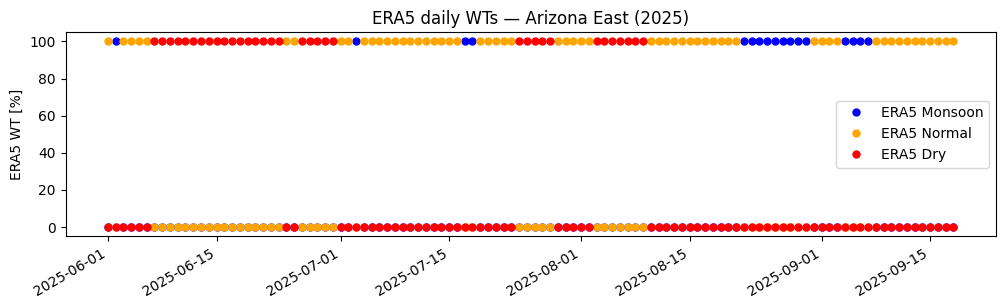

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_Arizona-East-2025.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_Arizona-East-2025.csv

==================== Processing Region: NM North ====================


Downloading...
From: https://drive.google.com/uc?id=1emPVA1UZgN4FI-oGfo3f_rc7-oUNVL0v
To: /content/cache/regions/NM_North/Clusters_1982_2018_Q850_JJASO.pkl
100%|██████████| 52.5M/52.5M [00:00<00:00, 224MB/s]


WT grid shape: (8, 8)


Downloading...
From: https://drive.google.com/uc?id=1hroqawuPKIEMUH5xiDIVXtp1UB6kKYki
To: /content/cache/regions/NM_North/NormalizationFactors_era5_NM North.npz
100%|██████████| 1.14k/1.14k [00:00<00:00, 3.62MB/s]


>> Year: 2023
[DEBUG] Found 30 files for 202306
[DEBUG] Found 31 files for 202307
[DEBUG] Found 31 files for 202308
[DEBUG] Found 30 files for 202309
[DEBUG] Found 31 files for 202310
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2023.nc with 153 days.
[INFO] NM North 2023: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2023.nc, date range 2023-06-01 00:00:00 -> 2023-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-North-2023_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2023_daily.csv


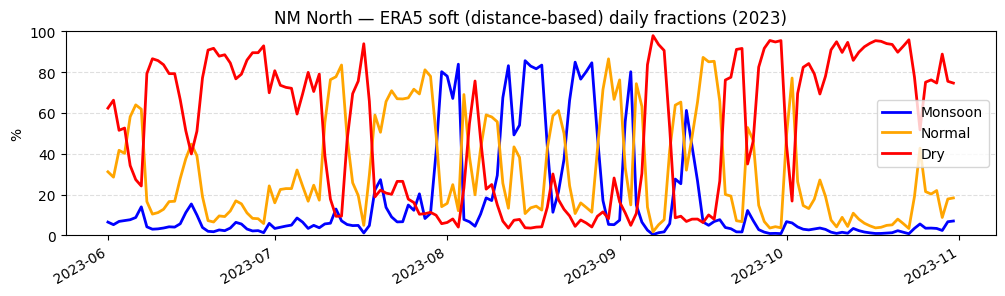

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-North-2023.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6          5.44       23.73    70.83
7         11.92       46.13    41.95
8         48.16       36.17    15.67
9         14.14       37.18    48.68
10         2.91       16.24    80.86


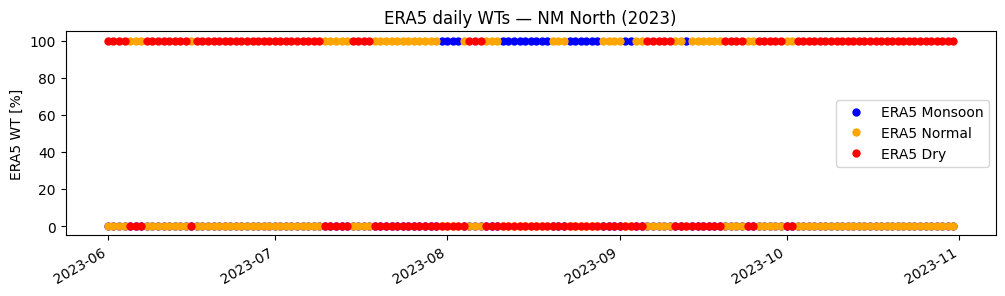

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-North-2023.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2023.csv
>> Year: 2024
[DEBUG] Found 30 files for 202406
[DEBUG] Found 31 files for 202407
[DEBUG] Found 31 files for 202408
[DEBUG] Found 30 files for 202409
[DEBUG] Found 31 files for 202410
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2024.nc with 153 days.
[INFO] NM North 2024: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2024.nc, date range 2024-06-01 00:00:00 -> 2024-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-North-2024_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2024_daily.csv


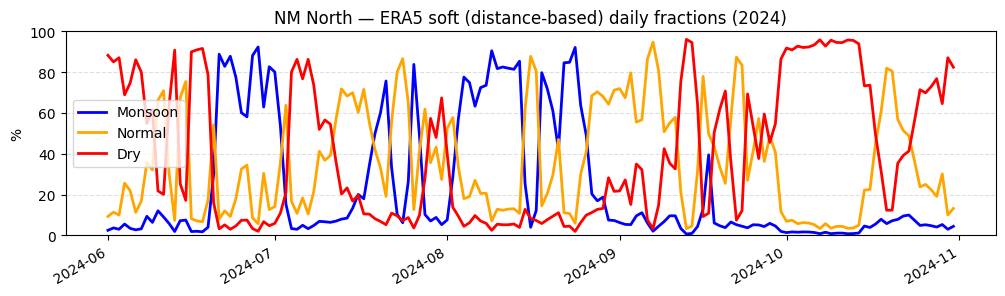

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-North-2024.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         30.12       25.21    44.66
7         23.33       44.05    32.62
8         54.80       35.51     9.69
9          6.63       51.27    42.10
10         3.82       23.25    72.94


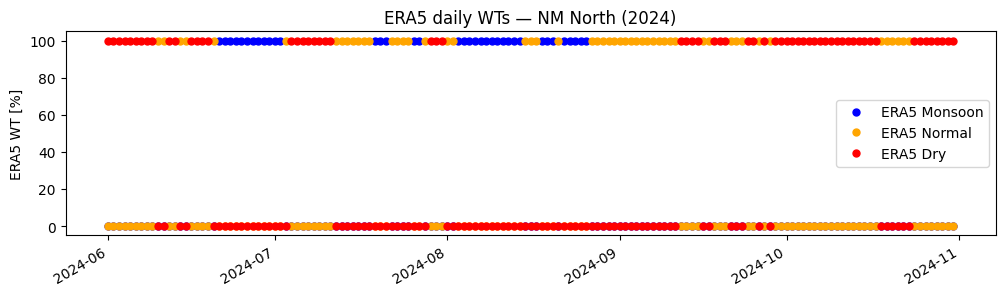

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-North-2024.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2024.csv
>> Year: 2025
[DEBUG] Found 30 files for 202506
[DEBUG] Found 31 files for 202507
[DEBUG] Found 31 files for 202508
[DEBUG] Found 18 files for 202509
[DEBUG] No files found for pattern: /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/202510/e5.oper.an.pl.128_133_q.ll025sc.*.nc
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2025.nc with 110 days.
[INFO] NM North 2025: reading 110 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_North/q850_2025.nc, date range 2025-06-01 00:00:00 -> 2025-09-18 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-North-2025_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2025_daily.csv


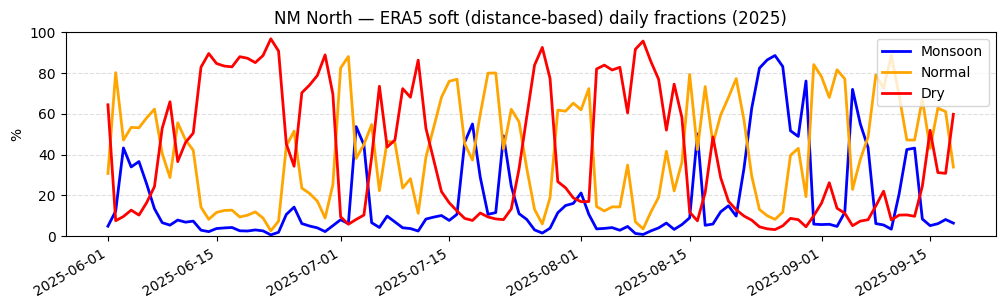

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-North-2025.png
Soft monthly means (percent):
   monsoon_pct  normal_pct  dry_pct
6         9.40       30.00    60.60
7        15.90       49.07    35.02
8        25.84       36.35    37.81
9        19.66       60.27    20.07


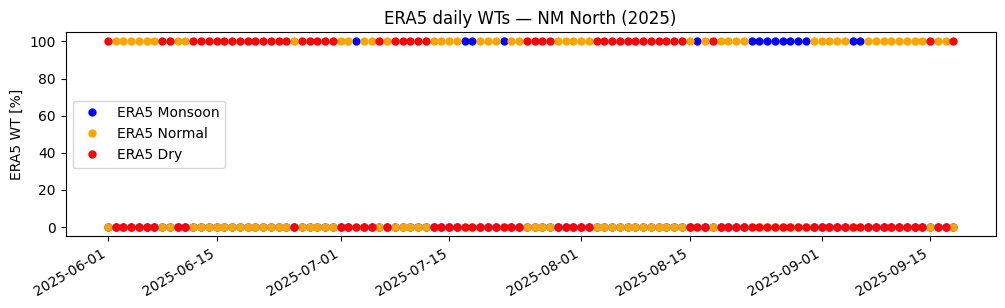

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-North-2025.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-North-2025.csv

==================== Processing Region: NM South ====================


Downloading...
From (original): https://drive.google.com/uc?id=1-Pwx-WqsJ7dIHlKBvgSzHUDTAM6xS62X
From (redirected): https://drive.google.com/uc?id=1-Pwx-WqsJ7dIHlKBvgSzHUDTAM6xS62X&confirm=t&uuid=c7166d8f-6f25-461f-8327-5b5e78a491bf
To: /content/cache/regions/NM_South/Clusters_1982_2018_Q850_JJASO.pkl
100%|██████████| 155M/155M [00:01<00:00, 123MB/s]


WT grid shape: (10, 7)


Downloading...
From: https://drive.google.com/uc?id=1k1okjeaJXy4iCSB4ca0TcJw7pAaXfuPc
To: /content/cache/regions/NM_South/NormalizationFactors_era5_NM South.npz
100%|██████████| 1.19k/1.19k [00:00<00:00, 1.41MB/s]


>> Year: 2023
[DEBUG] Found 30 files for 202306
[DEBUG] Found 31 files for 202307
[DEBUG] Found 31 files for 202308
[DEBUG] Found 30 files for 202309
[DEBUG] Found 31 files for 202310
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2023.nc with 153 days.
[INFO] NM South 2023: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2023.nc, date range 2023-06-01 00:00:00 -> 2023-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-South-2023_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2023_daily.csv


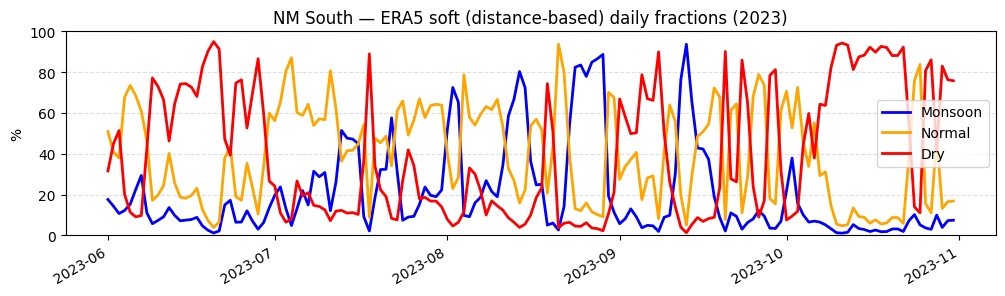

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-South-2023.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         10.22       32.14    57.64
7         23.88       55.94    20.18
8         42.74       42.98    14.28
9         18.67       40.64    40.69
10         6.54       26.45    67.01


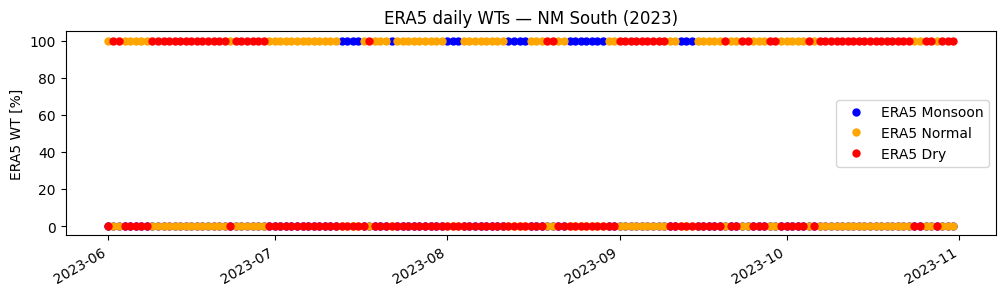

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-South-2023.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2023.csv
>> Year: 2024
[DEBUG] Found 30 files for 202406
[DEBUG] Found 31 files for 202407
[DEBUG] Found 31 files for 202408
[DEBUG] Found 30 files for 202409
[DEBUG] Found 31 files for 202410
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2024.nc with 153 days.
[INFO] NM South 2024: reading 153 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2024.nc, date range 2024-06-01 00:00:00 -> 2024-10-31 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-South-2024_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2024_daily.csv


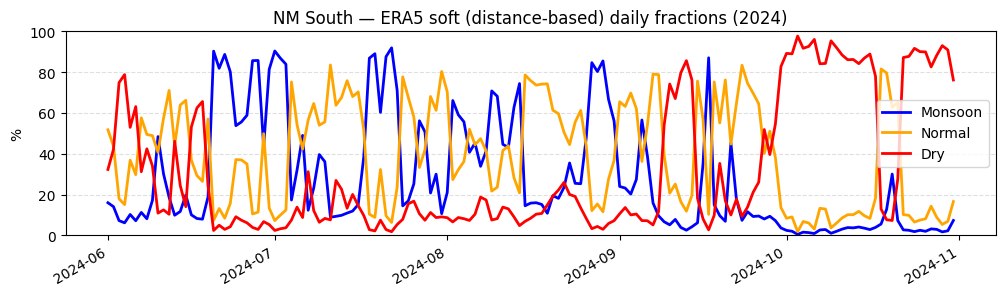

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-South-2024.png
Soft monthly means (percent):
    monsoon_pct  normal_pct  dry_pct
6         36.20       36.08    27.71
7         41.50       48.12    10.37
8         44.12       44.74    11.14
9         17.81       51.18    31.01
10         4.08       17.11    78.81


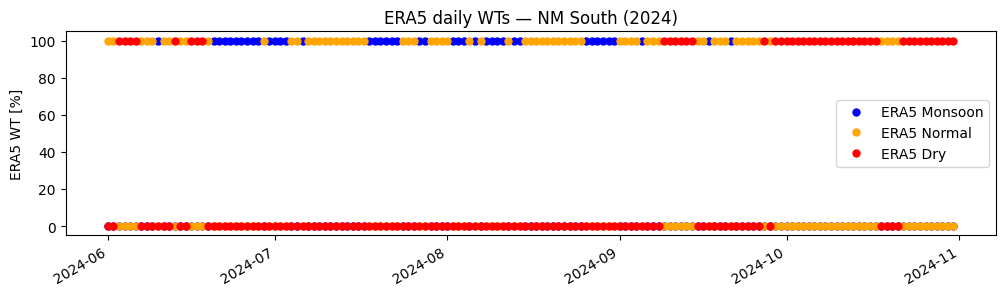

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-South-2024.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2024.csv
>> Year: 2025
[DEBUG] Found 30 files for 202506
[DEBUG] Found 31 files for 202507
[DEBUG] Found 31 files for 202508
[DEBUG] Found 18 files for 202509
[DEBUG] No files found for pattern: /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/202510/e5.oper.an.pl.128_133_q.ll025sc.*.nc
[INFO] Built /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2025.nc with 110 days.
[INFO] NM South 2025: reading 110 days from /content/drive/MyDrive/Colab Notebooks/ERA5/Q850/daily/NM_South/q850_2025.nc, date range 2025-06-01 00:00:00 -> 2025-09-18 00:00:00
Any duplicate dates in index? False
No >100% sums found for this year.
Saved ERA5 daily fractions CSV: /content/ERA5_WT-frequency/ERA5_WT-fraqtions_NM-South-2025_daily.csv
Saved ERA5 hard daily CSV: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2025_daily.csv


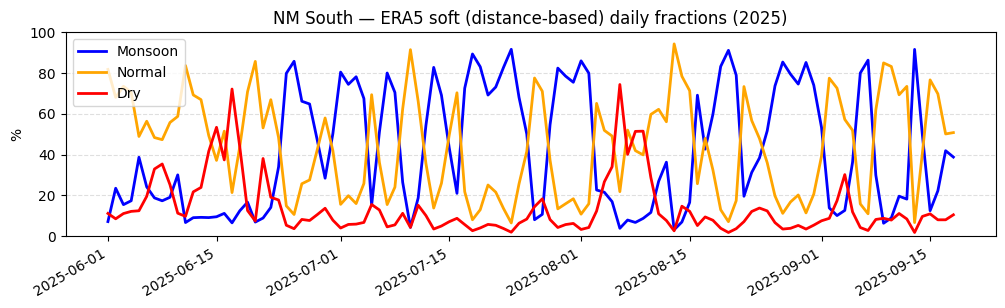

saved: /content/ERA5_WT-frequency/ERA5_WT-soft-timeseries_NM-South-2025.png
Soft monthly means (percent):
   monsoon_pct  normal_pct  dry_pct
6        26.25       52.59    21.16
7        58.91       33.78     7.31
8        44.94       39.59    15.47
9        35.11       55.12     9.77


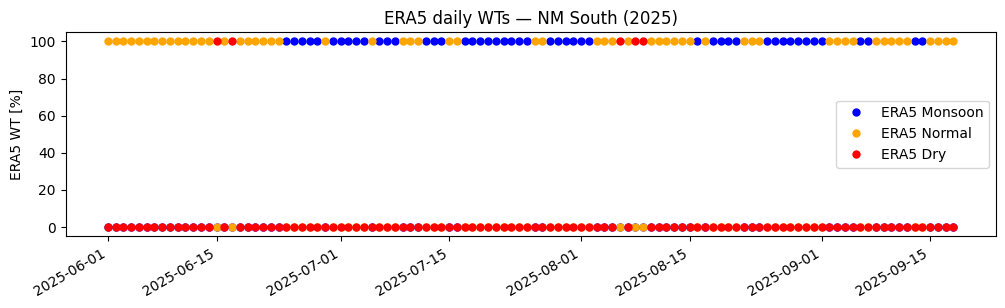

saved: /content/ERA5_WT-frequency/ERA5_WT-hard-markers_NM-South-2025.png
saved: /content/ERA5_WT-frequency/ERA5_WT-frequency_NM-South-2025.csv

All done.


In [ ]:
# ===============================================================
# ERA5 WT assignment — Region loop WITH YOUR PLOTS (shown + saved)
# (fixed: use real dates from available files; no zero-padding)
# ===============================================================
import os, glob, calendar, pickle, warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

iAddCells = 4

# produce outputs for these years instead of single year_forecast
plot_years = plot_years  # must be defined earlier
dir_o = os.path.join(os.getcwd(), "ERA5_WT-frequency")
os.makedirs(dir_o, exist_ok=True)

# -------------------
# Helpers
# -------------------
def _to_lon180(lon_1d):
    lon = np.array(lon_1d, dtype=float)
    lon = np.where(lon > 180.0, lon - 360.0, lon)
    return lon

def _compute_subgrid_indices(lon_1d_raw, lat_1d_raw, WTlon2d, WTlat2d, iAddCells=4):
    lon_180 = _to_lon180(lon_1d_raw)
    rgrLonSF, rgrLatSF = np.meshgrid(lon_180, lat_1d_raw)  # N->S
    rgrLatSF_SN = rgrLatSF[::-1, :]  # S->N
    rgrLonSF_SN = rgrLonSF[::-1, :]

    west_lon, east_lon = np.nanmin(WTlon2d), np.nanmax(WTlon2d)
    south_lat, north_lat = np.nanmin(WTlat2d), np.nanmax(WTlat2d)

    iWest = int(np.argmin(np.abs(west_lon - rgrLonSF_SN[0, :]))) - iAddCells
    iEast = int(np.argmin(np.abs(east_lon - rgrLonSF_SN[0, :]))) + iAddCells
    iSouth = int(np.argmin(np.abs(south_lat - rgrLatSF_SN[:, 0]))) - iAddCells
    iNorth = int(np.argmin(np.abs(north_lat - rgrLatSF_SN[:, 0]))) + iAddCells

    nlat_SN, nlon = rgrLatSF_SN.shape
    iWest = max(0, min(iWest, nlon - 1))
    iEast = max(iWest + 1, min(iEast, nlon))
    iSouth = max(0, min(iSouth, nlat_SN - 1))
    iNorth = max(iSouth + 1, min(iNorth, nlat_SN))

    nlat_NS = rgrLatSF.shape[0]
    jNorth_NS = nlat_NS - iNorth
    jSouth_NS = nlat_NS - iSouth
    return (iWest, iEast, iSouth, iNorth, jNorth_NS, jSouth_NS, lon_180)

def _collect_files_for_year(year):
    """
    Return sorted list of matching ERA5 files (full path) for the months in MONTHS_ERA5.
    Pattern is the same as used earlier; adjust this function if your files are placed differently.
    """
    files = []
    for m in MONTHS_ERA5:
        yyyymm = year * 100 + m
        pat = os.path.join(dir_era5, f"{yyyymm}", "e5.oper.an.pl.128_133_q.ll025sc.*.nc")
        found = sorted(glob.glob(pat))
        # Debug: print search pattern and number of found files
        if not found:
            pass
        if found:
            print(f"[DEBUG] Found {len(found)} files for {yyyymm}")
            files.extend(found)
        else:
            print(f"[DEBUG] No files found for pattern: {pat}")
    return sorted(files)

def _parse_date_from_filename(fname):
    """
    Parse date from filename like:
      e5.oper.an.pl.128_133_q.ll025sc.2025091800_2025091823.nc
    and return a pandas.Timestamp for the start date (YYYYMMDD).
    Safely fallback to None on parse failure.
    """
    base = os.path.basename(fname)
    parts = base.split('.')
    if len(parts) >= 5:
        token = parts[4]
        # token example: '2025091800_2025091823' -> take first 8 chars
        if len(token) >= 8 and token[:8].isdigit():
            try:
                return pd.to_datetime(token[:8], format='%Y%m%d')
            except Exception:
                return None
    # fallback: try to find 8-digit sequence anywhere
    import re
    m = re.search(r'20\d{6}', base)
    if m:
        try:
            return pd.to_datetime(m.group(0), format='%Y%m%d')
        except Exception:
            return None
    return None

def _ensure_year_q850(RegName, WTlon, WTlat, year):
    """
    Build q850_{year}.nc from available ERA5 files under dir_era5/YYYYMM/... .
    Each input file becomes one daily 2D (we collapse its time dimension to daily mean
    and assign the date parsed from filename). No padding/truncating to calendar range.
    """
    region_key = RegName.replace(" ", "_")
    out_dir = os.path.join(dir_era5, "daily", region_key)
    os.makedirs(out_dir, exist_ok=True)
    flnm_o = os.path.join(out_dir, f"q850_{year}.nc")

    # remove previous file if present
    try:
        os.remove(flnm_o)
    except FileNotFoundError:
        pass

    in_files = _collect_files_for_year(year)
    if not in_files:
        warnings.warn(f"[{RegName} {year}] No available ERA5 files for months {MONTHS_ERA5}.")
        return flnm_o

    # open first existent file to compute subgrid indices
    sample_file = None
    for f in in_files:
        sample_file = f
        break
    if sample_file is None:
        warnings.warn(f"[{RegName} {year}] No sample ERA5 file found to infer grid.")
        return flnm_o

    with xr.open_dataset(sample_file) as ds_samp:
        lon_raw = ds_samp.longitude.values  # 0..360
        lat_raw = ds_samp.latitude.values   # N->S

    iW, iE, _, _, jN_NS, jS_NS, _ = _compute_subgrid_indices(lon_raw, lat_raw, WTlon, WTlat, iAddCells)

    q_list = []
    times = []
    for fl in in_files:
        dt = _parse_date_from_filename(fl)
        if dt is None:
            print(f"[WARN] Could not parse date from filename: {fl}; skipping.")
            continue
        try:
            with xr.open_dataset(fl) as ds:
                # collapse time dimension (daily mean) and subset spatially
                # careful: ds.Q might be (time, level, lat, lon) or (time, lat, lon) with level coord
                # your original code used ds.Q.sel(level=850).mean(dim="time")
                if 'level' in ds.dims:
                    qlev = ds.Q.sel(level=850)
                else:
                    qlev = ds.Q
                q2d = qlev.mean(dim="time")  # daily mean for file
                q2d = q2d.isel(latitude=slice(jN_NS, jS_NS), longitude=slice(iW, iE))
                # ensure it has a time coordinate we control (one day)
                q2d = q2d.expand_dims(time=[pd.Timestamp(dt)])
                q_list.append(q2d)
                times.append(pd.Timestamp(dt))
        except Exception as e:
            print(f"[WARN] Failed to read/aggregate file {fl}: {e}")
            continue

    if not q_list:
        warnings.warn(f"[{RegName} {year}] No daily ERA5 files aggregated after parsing; cannot build q850.")
        return flnm_o

    # concat along time (should be ordered since in_files is sorted)
    q850_3d = xr.concat(q_list, dim="time")  # (time, lat, lon)
    # Write netcdf with real time coords (no forced slicing)
    q850_3d.to_netcdf(path=flnm_o, mode="w")
    print(f"[INFO] Built {flnm_o} with {q850_3d.sizes.get('time', q850_3d.shape[0])} days.")
    return flnm_o

# -------------------
# Main loop (uses actual times from q850 file)
# -------------------
for RegName, cfg in REGION_CFG.items():
    print(f"\n==================== Processing Region: {RegName} ====================")

    # Load centroids / WT grid (unchanged)
    region_dir = Path(REGIONS_DIR) / RegName.replace(" ", "_")
    region_dir.mkdir(parents=True, exist_ok=True)
    clusters_pkl = cached_gdown(cfg['sWTdata'], region_dir / "Clusters_1982_2018_Q850_JJASO.pkl")
    with open(clusters_pkl, 'rb') as handle:
        npzfile = pickle.load(handle)

    WTclusters = npzfile['grClustersFin']['Full']
    WTlat      = npzfile['LatWT']
    WTlon      = npzfile['LonWT']
    WTsort     = cfg['WTsort']  # maps -> [Monsoon, Normal, Dry]
    print("WT grid shape:", WTlon.shape)

    # Load normalization factors
    norm_file = cached_gdown(cfg['NormFact_era'], region_dir / f'NormalizationFactors_era5_{RegName}.npz')
    ds_n = np.load(norm_file, allow_pickle=True)
    Normalize = ds_n['grNormalizationFactors']

    # Loop over requested plot years
    for year in plot_years:
        print(f">> Year: {year}")

        # Build q850_{year}.nc from whatever files exist (no padding).
        flnm_i = _ensure_year_q850(RegName, WTlon, WTlat, year)
        if not os.path.isfile(flnm_i):
            warnings.warn(f"[{RegName} {year}] Missing input {flnm_i}; skipping.")
            continue

        # Read values + coords and real time coordinate from file
        with xr.open_dataset(flnm_i) as ds:
            if 'time' not in ds.coords:
                warnings.warn(f"[{RegName} {year}] q850 file {flnm_i} missing 'time' coordinate. Skipping.")
                continue
            times_all = pd.to_datetime(ds['time'].values)
            DataAct = ds.values if 'Q' not in ds else ds.Q.values  # fallback safety
            # prefer Q variable
            DataAct = ds.Q.values if 'Q' in ds else DataAct
            # original orientation: ds.Q.values is (time, lat (N->S?), lon)
            # your previous code flipped lat to S->N: DataAct = ds.Q.values[:, ::-1, :]
            # check ds.latitude orientation: original code used ds.latitude.values[::-1]
            try:
                lat_subSN = ds.latitude.values[::-1]
            except Exception:
                lat_subSN = ds.latitude.values
            lon_sub = _to_lon180(ds.longitude.values)

        # DataAct may be shape (time, lat, lon); flip lat to S->N to get same convention as before:
        if DataAct.ndim == 3:
            DataAct = DataAct[:, ::-1, :]

        n_times = DataAct.shape[0]
        idx = pd.DatetimeIndex(times_all[:n_times])  # authoritative dates for the processed days
        print(f"[INFO] {RegName} {year}: reading {n_times} days from {flnm_i}, date range {idx.min()} -> {idx.max()}")

        # Interp weights from ACTUAL file coords
        rgrLonS, rgrLatS = np.meshgrid(lon_sub, lat_subSN)  # S->N
        points  = np.column_stack([rgrLonS.ravel(), rgrLatS.ravel()])
        targets = np.column_stack([WTlon.ravel(), WTlat.ravel()])
        vtx, wts = interp_weights(points, targets)

        assert DataAct.shape[1:] == rgrLonS.shape, f"Data grid {DataAct.shape[1:]} != points grid {rgrLonS.shape}"

        # Interpolate daily to WT grid for the number of actual days
        nx, ny = WTlon.shape
        Data_on_centroid_grid = np.full((n_times, nx, ny), np.nan)
        for tt in range(n_times):
            vals_flat  = DataAct[tt].ravel()
            interp_val = interpolate(vals_flat, vtx, wts)
            Data_on_centroid_grid[tt] = interp_val.reshape((nx, ny))

        # Preprocess -> features (use only n_times rows)
        DailyVarsEvalNorm = PreprocessWTdata(
            Data_on_centroid_grid,
            RelAnnom=RelAnnom,
            SmoothSigma=0,
            RemoveAnnualCycl=RemoveAnnualCycl,
            NormalizeData=NormalizeData,
            Normalize=Normalize
        )

        # Distances and hard labels (mask all-NaN days)
        EucledianDist, Correlation, Manhattan, Chebyshev = EucledianDistance(DailyVarsEvalNorm, WTclusters)
        isNAN = np.isnan(np.nanmean(Data_on_centroid_grid, axis=(1, 2)))
        try:
            MinED = np.nanargmin(EucledianDist, axis=1).astype(float)   # original cluster indices
            MinED[isNAN] = np.nan
        except Exception as e:
            warnings.warn(f"[{RegName} {year}] argmin failed: {e}")
            MinED = np.full((n_times,), np.nan)

        # Map to canonical [0=Monsoon,1=Normal,2=Dry]
        WT_NMME_FIN1 = np.full_like(MinED, 999.0)
        for new_lbl, src_lbl in enumerate(WTsort):
            WT_NMME_FIN1[MinED == src_lbl] = float(new_lbl)

        # ------------------------------------------------------------------
        # PLOTTING + DAILY CSV CODE (integrated in the loop) using real idx
        # ------------------------------------------------------------------

        # ---- Hard daily (0/100) dataframe + sanity checks ----
        lab = np.asarray(WT_NMME_FIN1).astype(float).copy()
        lab[lab == 999] = np.nan

        df_hard = pd.DataFrame({
            'monsoon_pct': (lab == 0).astype(float) * 100.0,
            'normal_pct':  (lab == 1).astype(float) * 100.0,
            'dry_pct':     (lab == 2).astype(float) * 100.0
        }, index=idx)

        sums = df_hard.sum(axis=1)
        dups = df_hard.index.duplicated().any()
        print("Any duplicate dates in index?", dups)
        if (sums > 100.0).any():
            print("Days with sum >100% (debug):")
            print(df_hard[sums > 100.0])
        else:
            print("No >100% sums found for this year.")

        # ---- Soft (distance-based) fractions from EucledianDist ----
        ED = np.asarray(EucledianDist)
        if ED.ndim > 2:
            ED2 = np.nanmin(ED, axis=tuple(range(2, ED.ndim)))
        else:
            ED2 = ED.copy()
        T, K = ED2.shape

        eps = 1e-9
        W = 1.0 / (ED2**2 + eps)
        W = W / np.nansum(W, axis=1, keepdims=True)

        # Canonical order via WTsort
        P_sorted = np.full((T, 3), np.nan)
        for new_label, old_label in enumerate(WTsort):
            if 0 <= old_label < K:
                P_sorted[:, new_label] = W[:, old_label]

        # Use idx[:T] as index (T may be <= n_times)
        idx_soft = idx[:T]
        df_soft = pd.DataFrame({
            'monsoon_pct': P_sorted[:, 0] * 100.0,
            'normal_pct':  P_sorted[:, 1] * 100.0,
            'dry_pct':     P_sorted[:, 2] * 100.0
        }, index=idx_soft)

        # Filter soft series to the requested months (MONTHS_ERA5)
        df_soft_filter = df_soft[df_soft.index.month.isin(MONTHS_ERA5)]

        # ---- Save daily CSVs exactly like your scripts ----
        df_soft_csv = os.path.join(dir_o, f'ERA5_WT-fraqtions_{RegName.replace(" ", "-")}-{year}_daily.csv')
        df_soft_filter.to_csv(df_soft_csv, index=True)
        print(f"Saved ERA5 daily fractions CSV: {df_soft_csv}")

        daily_csv = os.path.join(dir_o, f'ERA5_WT-frequency_{RegName.replace(" ", "-")}-{year}_daily.csv')
        df_hard.to_csv(daily_csv, index=True)
        print(f"Saved ERA5 hard daily CSV: {daily_csv}")

        # ---- Plot soft fractions (lines) ----
        plt.figure(figsize=(12, 3))
        colors = ['b', 'orange', 'r']
        for col, c in zip(['monsoon_pct', 'normal_pct', 'dry_pct'], colors):
            plt.plot(df_soft_filter.index, df_soft_filter[col], linestyle='-', linewidth=2, color=c,
                     label=col.replace('_pct', '').capitalize())
        plt.ylim(0, 100)
        plt.ylabel('%')
        plt.title(f'{RegName} — ERA5 soft (distance-based) daily fractions ({year})')
        plt.legend()
        plt.grid(axis='y', ls='--', alpha=0.4)
        plt.gcf().autofmt_xdate()
        out_soft_png = os.path.join(dir_o, f'ERA5_WT-soft-timeseries_{RegName.replace(" ", "-")}-{year}.png')
        plt.savefig(out_soft_png, dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()
        print("saved:", out_soft_png)

        # ---- Print soft monthly means (percent) ----
        try:
            soft_monthly = df_soft.groupby(df_soft.index.month)[['monsoon_pct','normal_pct','dry_pct']].mean()
            present_months = [m for m in MONTHS_ERA5 if m in soft_monthly.index]
            soft_for_months = soft_monthly.loc[present_months]
            print("Soft monthly means (percent):")
            print(soft_for_months.round(2))
        except Exception as e:
            print("Soft monthly means not available for all requested months:", e)

        # ---- Plot hard daily markers (0/100 per WT) ----
        WT_Names  = ['Monsoon', 'Normal', 'Dry']
        WT_colors = ['b', 'orange', 'r']

        x_era = idx  # authoritative event dates for markers
        era_frac = np.column_stack([(WT_NMME_FIN1 == i).astype(float) * 100.0 for i in range(3)])

        # Ensure shapes match (era_frac rows == len(x_era))
        if era_frac.shape[0] > len(x_era):
            era_frac = era_frac[:len(x_era), :]
        elif era_frac.shape[0] < len(x_era):
            pad = np.full((len(x_era) - era_frac.shape[0], era_frac.shape[1]), np.nan)
            era_frac = np.vstack([era_frac, pad])

        plt.figure(figsize=(12, 3))
        for i, c in enumerate(WT_colors):
            plt.plot(x_era, era_frac[:, i], linestyle='None', marker='o', markersize=5, color=c,
                     label=f'ERA5 {WT_Names[i]}')
        plt.legend()
        plt.ylabel('ERA5 WT [%]')
        plt.title(f'ERA5 daily WTs — {RegName} ({year})')
        plt.gcf().autofmt_xdate()
        out_hard_png = os.path.join(dir_o, f'ERA5_WT-hard-markers_{RegName.replace(" ", "-")}-{year}.png')
        #plt.savefig(out_hard_png, dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()
        print("saved:", out_hard_png)

        # ---- Monthly counts computed directly from actual dates & labels ----
        df_labels = pd.DataFrame({'date': idx, 'label': WT_NMME_FIN1})
        df_labels['month'] = df_labels['date'].dt.month
        months_present = [m for m in MONTHS_ERA5 if m in df_labels['month'].unique()]

        nmon = len(months_present)
        WT_MM1 = np.zeros((nmon, 3), dtype=float)
        for i_m, m in enumerate(months_present):
            window = df_labels.loc[df_labels['month'] == m, 'label']
            WT_MM1[i_m, 0] = float(np.nansum(window == 0))
            WT_MM1[i_m, 1] = float(np.nansum(window == 1))
            WT_MM1[i_m, 2] = float(np.nansum(window == 2))

        YYYYMM = [(year * 100 + m) for m in months_present]
        DATA = np.round(WT_MM1[: len(YYYYMM), :], 2)
        df_out = pd.DataFrame({
            'YYYYMM': YYYYMM,
            'dry':     DATA[:, 2].astype(float),
            'normal':  DATA[:, 1].astype(float),
            'monsoon': DATA[:, 0].astype(float),
        })
        mon_csv = os.path.join(dir_o, f"ERA5_WT-frequency_{RegName.replace(' ', '-')}-{year}.csv")
        df_out.to_csv(mon_csv, index=False)
        print("saved:", mon_csv)

print("\nAll done.")


In [ ]:
# === Plot ERA5 10-day rolling FRACTIONS (soft + hard) from canonical CSVs ===

import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_DIR = "/content/ERA5_WT-frequency"

def _read_10d_csv(fp):
    """Read canonical 10-day CSV, coerce datetime index, keep pct columns."""
    df = pd.read_csv(fp, index_col=0)
    # parse index robustly (try ISO first, then fallback)
    try:
        idx = pd.to_datetime(df.index, format="%Y-%m-%d", errors="coerce")
        if idx.notna().mean() > 0.8:
            df.index = idx
        else:
            df.index = pd.to_datetime(df.index, errors="coerce")
    except Exception:
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df.sort_index()
    # standardize column names
    df.columns = [c.strip().lower() for c in df.columns]
    # keep only expected percent columns
    cols = [c for c in ['monsoon_pct','normal_pct','dry_pct'] if c in df.columns]
    return df[cols].dropna(how='all')

def _title(region_tag, year, kind):
    return f"{region_tag.replace('-', ' ')} {year} — 10-day rolling ({kind})"

# Discover canonical files
pat_soft = os.path.join(INPUT_DIR, "ERA5_WT-10day-fractions_*-[0-9][0-9][0-9][0-9].csv")
pat_hard = os.path.join(INPUT_DIR, "ERA5_WT-10day-frequency_*-[0-9][0-9][0-9][0-9].csv")

soft_files = sorted(glob.glob(pat_soft))
hard_files = sorted(glob.glob(pat_hard))

# Index by (region_tag, year)
def _key_from_base(base, label):
    # label is 'fractions' or 'frequency'
    m = re.match(rf"ERA5_WT-10day-{label}_(.+)-(\d{{4}})\.csv", base)
    if not m:
        return None
    return (m.group(1), int(m.group(2)))  # (region_tag, year)

soft_map = {}
for fp in soft_files:
    key = _key_from_base(os.path.basename(fp), 'fractions')
    if key: soft_map[key] = fp

hard_map = {}
for fp in hard_files:
    key = _key_from_base(os.path.basename(fp), 'frequency')
    if key: hard_map[key] = fp

all_keys = sorted(set(soft_map.keys()).union(hard_map.keys()))
if not all_keys:
    print("No canonical 10-day CSVs found in:", INPUT_DIR)

made = []
for (region_tag, year) in all_keys:
    # Load available data
    df_soft = _read_10d_csv(soft_map[(region_tag, year)]) if (region_tag, year) in soft_map else None
    df_hard = _read_10d_csv(hard_map[(region_tag, year)]) if (region_tag, year) in hard_map else None

    # --- separate SOFT plot ---
    import matplotlib.dates as mdates
    import calendar

    # canonical colors
    colors = {'monsoon_pct': 'blue', 'normal_pct': 'orange', 'dry_pct': 'red'}

    # pick months (force June start); fallback if MONTHS_ERA5 missing
    months_era = globals().get('MONTHS_ERA5', [6,7,8,9,10])
    plot_start = pd.Timestamp(year=int(year), month=6, day=1)
    plot_end_month = int(months_era[-1])
    plot_end = pd.Timestamp(year=int(year), month=plot_end_month,
                            day=calendar.monthrange(int(year), plot_end_month)[1])

    # pick dataframes to plot (prefer full df_soft if present, else filtered)
    soft_src = locals().get('df_soft') if 'df_soft' in locals() else locals().get('df_soft_filter', None)
    hard_src = locals().get('df_hard')

    # build full daily index used for plotting (uniform across years)
    full_idx = pd.date_range(plot_start, plot_end, freq='D')

    # diagnostic: actual available dates
    avail = pd.DatetimeIndex([])
    if soft_src is not None and not soft_src.empty:
        avail = avail.union(soft_src.index)
    if hard_src is not None and not hard_src.empty:
        avail = avail.union(hard_src.index)
    if len(avail) == 0:
        print(f"[INFO] {region_tag} {year}: no data available to plot.")
    else:
        print(f"[INFO] {region_tag} {year}: actual data range {avail.min().date()} -> {avail.max().date()} ; plotting axis forced to {plot_start.date()} -> {plot_end.date()}")

    # reindex (do not fill; keep NaN so gaps show)
    ds = soft_src.reindex(full_idx) if (soft_src is not None and not soft_src.empty) else None
    dh = hard_src.reindex(full_idx) if (hard_src is not None and not hard_src.empty) else None

    # Helper to set common x ticks / formatter
    def _format_xaxis(ax):
        ax.set_xlim(plot_start, plot_end)
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=30)

    # --- separate SOFT plot ---
    if ds is not None:
        plt.figure(figsize=(12, 3))
        for col in ['monsoon_pct','normal_pct','dry_pct']:
            if col in ds.columns:
                plt.plot(ds.index, ds[col], label=col.replace('_pct','').capitalize(), color=colors[col])
        plt.ylim(0, 100)
        plt.ylabel('%')
        plt.title(_title(region_tag, year, "soft"))
        plt.legend()
        plt.grid(axis='y', ls='--', alpha=0.4)
        ax = plt.gca(); _format_xaxis(ax)
        out_soft_png = os.path.join(INPUT_DIR, f"ERA5_WT-10day-fractions_{region_tag}-{year}.png")
        plt.savefig(out_soft_png, dpi=150, bbox_inches='tight')
        plt.show(); plt.close()
        made.append(out_soft_png)
        print("saved:", out_soft_png)

    # --- separate HARD plot ---
    if dh is not None:
        plt.figure(figsize=(12, 3))
        for col in ['monsoon_pct','normal_pct','dry_pct']:
            if col in dh.columns:
                plt.plot(dh.index, dh[col], label=col.replace('_pct','').capitalize(), color=colors[col])
        plt.ylim(0, 100)
        plt.ylabel('%')
        plt.title(_title(region_tag, year, "hard"))
        plt.legend()
        plt.grid(axis='y', ls='--', alpha=0.4)
        ax = plt.gca(); _format_xaxis(ax)
        out_hard_png = os.path.join(INPUT_DIR, f"ERA5_WT-10day-frequency_{region_tag}-{year}.png")
        plt.savefig(out_hard_png, dpi=150, bbox_inches='tight')
        plt.show(); plt.close()
        made.append(out_hard_png)
        print("saved:", out_hard_png)

    # --- combined overlay (soft vs hard, different linestyles) ---
    if (ds is not None) and (dh is not None):
        plt.figure(figsize=(12, 3))
        for col in ['monsoon_pct','normal_pct','dry_pct']:
            if col in ds.columns:
                plt.plot(ds.index, ds[col], linestyle='-', label=f"{col.replace('_pct','').capitalize()} (soft)", color=colors[col])
            if col in dh.columns:
                plt.plot(dh.index, dh[col], linestyle='--', label=f"{col.replace('_pct','').capitalize()} (hard)", color=colors[col])
        plt.ylim(0, 100)
        plt.ylabel('%')
        plt.title(f"{region_tag.replace('-', ' ')} {year} — 10-day rolling (soft vs hard)")
        plt.legend(ncol=3)
        plt.grid(axis='y', ls='--', alpha=0.4)
        ax = plt.gca(); _format_xaxis(ax)
        out_combined_png = os.path.join(INPUT_DIR, f"ERA5_WT-10day-combined_{region_tag}-{year}.png")
        plt.savefig(out_combined_png, dpi=150, bbox_inches='tight')
        plt.show(); plt.close()
        made.append(out_combined_png)
        print("saved:", out_combined_png)




No canonical 10-day CSVs found in: /content/ERA5_WT-frequency


### End ERA5 processing and Reanalysis WTs

In [ ]:
import pandas as pd
from pathlib import Path
import pathlib
import gc

In [ ]:
# FORECAST_PATH (e.g. path/to/f'ECMWF_forecast_{year_forecast}.grib')
# ERA5_WT-10day-fractions_{RegionTag}-{Year}.csv
# ERA5_WT-frequency_{RegionTag}-{Year}_daily.csv
# ERA5_WT-fraqtions_{RegionTag}-{Year}_daily.csv
# ECMWF_WT-frequency_{RegName.replace(' ', '-')}_daily.csv
# 2.ECMWF_WT-frequency_{RegName.replace(' ', '-')}_monthly.csv


In [ ]:
# -----------------------------
# Helper: run one region end-to-end (with ERA5 10-day overlay)
# -----------------------------
def run_region(RegName: str, WIN: int = 10, MINP: int = 10, center: bool = False,
               include_era: bool = True, clip_era_to_ecmwf_window: bool = False):
    """
    Plot ECMWF 10-day rolling WT fractions with ERA5 10-day rolling overlay.
    WIN: rolling window (days); MINP: min_periods; center: center the rolling window
    """

    cfg = REGION_CFG[RegName]
    re_idx  = cfg['re']
    WTsort  = cfg['WTsort']
    MONTHS  = [6, 7, 8, 9, 10]   # ECMWF season months for this plot
    OUT_DIR = Path(".")

    # Region cache dir
    rdir = REGIONS_DIR / RegName.replace(' ', '_')
    rdir.mkdir(parents=True, exist_ok=True)

    # Region files (download only once)
    centroids_nc = cached_gdown(cfg['sCentroidFile'], rdir / 'XWT_centroids.nc')
    era_npz      = cached_gdown(cfg['sERA_data'],     rdir / 'ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz')
    clusters_pkl = cached_gdown(cfg['sWTdata'],       rdir / 'Clusters_1982_2018_Q850_JJASO.pkl')
    norm_npz     = cached_gdown(cfg['NormFact'],      rdir / 'NormalizationFactors.npz')
    logging.info(f"\n=== Region: {RegName} ===")

    # --- Read centroids ---
    ncid = Dataset(centroids_nc, mode='r')
    rgrLonC = np.squeeze(ncid.variables['rlon'][:])
    rgrLatC = np.squeeze(ncid.variables['rlat'][:])
    ncid.close()

    # --- Load preprocessed ERA & PRISM ---
    DATA = np.load(era_npz, allow_pickle=True)
    rgrLonT  = DATA['LonWT']
    rgrLatT  = DATA['LatWT']

    # --- Load the Centroids ---
    with open(clusters_pkl, 'rb') as handle:
        npzfile = pickle.load(handle)
    WTclusters = npzfile['grClustersFin']['Full']
    WTlat      = npzfile['LatWT']
    WTlon      = npzfile['LonWT']
    WTtime     = npzfile['rgdTime']
    SpatialSmoothing = npzfile['SpatialSmoothing']

    # --- Subset IFS grid to WT domain ---
    iAddCells = 4
    iWest  = np.argmin(np.abs(WTlon.min() - LonS_base[0, :])) - iAddCells
    iEast  = np.argmin(np.abs(WTlon.max() - LonS_base[0, :])) + iAddCells
    iNort  = np.argmin(np.abs(WTlat.max() - LatS_base[:, 0])) + iAddCells
    iSouth = np.argmin(np.abs(WTlat.min() - LatS_base[:, 0])) - iAddCells

    LonS = LonS_base[iSouth:iNort, iWest:iEast]
    LatS = LatS_base[iSouth:iNort, iWest:iEast]

    # --- Interp weights: ECMWF (subset) -> WT grid ---
    pts_src = np.c_[LonS.flatten(), LatS.flatten()]
    vtx, wts = interp_weights(pts_src, np.c_[WTlon.flatten(), WTlat.flatten()])

    # --- Read ECMWF forecast GRIB (once, reused for all regions) ---
    ds = xr.open_dataset(str(FORECAST_PATH), engine='cfgrib', decode_timedelta=True)
    DATA_fc = ds['q'].values  # (ens, step, lat, lon)

    # Flip lat to match ERA layout if needed, then slice ROI
    DATA_fc = DATA_fc[:, :, ::-1, :]
    DATA_fc = DATA_fc[:, :, iSouth:iNort, iWest:iEast]

    TIME = ds['valid_time'].values  # use directly

    # 12-hourly -> daily means; keep only months in MONTHS
    DATA_daily = (DATA_fc[:, 1::2] + DATA_fc[:, ::2]) / 2.0
    TIME_daily = TIME[::2]
    Time_datetime = pd.date_range(TIME_daily[0], end=TIME_daily[-1], freq='D')
    pick = np.isin(Time_datetime.month, MONTHS)
    xdates = np.array(Time_datetime[pick])

    # Allocate on WT grid: [time, lon, lat, var=1, ens]
    Data_on_centroid_grid = np.full((pick.sum(), WTlon.shape[0], WTlat.shape[1], 1, DATA_daily.shape[0]), np.nan)

    # Interpolate per member, per day
    for en in range(DATA_daily.shape[0]):
        slab = DATA_daily[en, pick, :, :]
        for tt in range(slab.shape[0]):
            vals = interpolate(slab[tt, :, :].flatten(), vtx, wts)
            Data_on_centroid_grid[tt, :, :, 0, en] = vals.reshape(WTlon.shape[0], WTlat.shape[1])

    # ==========================
    # Normalize & classify to WTs  (UNCHANGED)
    # ==========================
    NF = np.load(norm_npz, allow_pickle=True)['grNormalizationFactors']
    NormData = list(NF.item()[str(Time_datetime[0].month)])  # month-specific normalization

    T, _, _, _, E = Data_on_centroid_grid.shape  # T: days, E: ensemble members
    WT_NMME = np.full((T, E), np.nan)

    for en in range(E):
        member_data = Data_on_centroid_grid[:, :, :, :, en]
        if np.isnan(member_data).all():
            continue
        isNAN = np.isnan(np.nanmean(member_data, axis=(1, 2, 3)))
        DailyVarsEvalNorm = PreprocessWTdata(
            member_data,
            RelAnnom=RelAnnom,
            SmoothSigma=0,
            RemoveAnnualCycl=RemoveAnnualCycl,
            NormalizeData=NormalizeData,
            Normalize=NormData
        )
        EucDist, Corr, Manh, Cheb = EucledianDistance(DailyVarsEvalNorm, WTclusters)
        MinIdx = np.nanargmin(EucDist, axis=1).astype(float)
        MinIdx[isNAN] = np.nan
        WT_NMME[:, en] = MinIdx

    # Re-label to standard [0=Monsoon, 1=Normal, 2=Dry]
    WT_NMME_FIN = np.full_like(WT_NMME, np.nan)
    for new_wt, old_wt in enumerate(WTsort):
        WT_NMME_FIN[WT_NMME == old_wt] = float(new_wt)
    # ---------------------------
    # Debug / print daily ECMWF WTs (UNCHANGED)
    # ---------------------------
    arr = np.asarray(WT_NMME_FIN)
    if arr.ndim == 1:
        arr = arr[:, None]
    T, E = arr.shape
    #print(f"Daily ECMWF WTs (remapped) shape: T={T}, E={E}")

    dates = pd.to_datetime(np.asarray(xdates))
    idx = pd.Index(dates, name="date") if len(dates) == T else pd.Index(range(T), name="day")

    cols = [f"ens_{i}" for i in range(E)]
    df_labels = pd.DataFrame(arr, index=idx, columns=cols)
    #print("\nFirst 30 days — per-ensemble WT labels (0=Monsoon,1=Normal,2=Dry; 999=missing):")
    #print(df_labels.head(30).to_string())

    # Daily ensemble fractions (kept for diagnostics)
    frac_mon = np.nanmean(arr == 0, axis=1) * 100.0
    frac_norm= np.nanmean(arr == 1, axis=1) * 100.0
    frac_dry = np.nanmean(arr == 2, axis=1) * 100.0
    df_frac_daily = pd.DataFrame({"monsoon_pct": frac_mon, "normal_pct": frac_norm, "dry_pct": frac_dry}, index=idx)
    #print("\nFirst 30 days — daily ensemble fractions [%]:")
    #print(df_frac_daily.head(30).to_string())

    # optional save daily ECMWF fractions (unchanged)
    try:
        out_daily_csv = OUT_DIR / f"ECMWF_WT-frequency_{RegName.replace(' ', '-')}_daily_{year_forecast}.csv"
        df_frac_daily.to_csv(out_daily_csv, index=True)
        print(f"Saved daily fractions CSV: {out_daily_csv}")
    except Exception as e:
        print("Could not save daily CSV:", e)

    # ==========================
    # NEW: 10-day rolling ECMWF fractions + std (true per-member window averaging)
    #   I^{(k)}_{t,e} in {0,1}
    #   F_t^{(k)} = 100 * mean_e( (1/W) * sum_{j=0..W-1} I^{(k)}_{t-j,e} )
    # ==========================
    def _roll10_hits_mean_std(hits_2d: np.ndarray, idx_dates: pd.DatetimeIndex, win=10, minp=10, center=False):
        # hits_2d: [T, E] in {0,1,nan}
        df_hits = pd.DataFrame(hits_2d, index=idx_dates)
        df_roll = df_hits.rolling(window=win, min_periods=minp, center=center).mean()  # per-member 10d mean
        mean_series = df_roll.mean(axis=1) * 100.0
        std_series  = df_roll.std(axis=1)  * 100.0
        return mean_series, std_series

    valid = np.isfinite(WT_NMME_FIN)  # [T, E]

    roll_mean = {}
    roll_std  = {}
    for wt in (0, 1, 2):
        hits = np.where(valid, (WT_NMME_FIN == wt).astype(float), np.nan)  # [T,E] as 0/1/nan
        roll_mean[wt], roll_std[wt] = _roll10_hits_mean_std(hits, idx, win=WIN, minp=MINP, center=center)

    # -------------------------
    # ERA5 overlay — use 10-day fractions if available; otherwise compute from daily file
    # -------------------------

    df_era_10d = None

    if include_era:
        try:
            era_year = int(globals().get('year_forecast', pd.to_datetime(xdates[0]).year))
            region_tag = RegName.replace(' ', '-')

            base_10d = f"ERA5_WT-10day-fractions_{region_tag}-{era_year}.csv"
            base_daily = f"ERA5_WT-frequency_{region_tag}-{era_year}_daily.csv"
            base_daily_typo = f"ERA5_WT-fraqtions_{region_tag}-{era_year}_daily.csv"  # for backwards compat

            # Search locations for 10-day and daily files
            era_10d_dirs = [
                Path('/mnt/data'),
                Path('/content/ERA5_10day_output'),
                Path('/content/ERA5/WT-frequency'),
                OUT_DIR,
                Path.cwd() / 'ERA5_10day_output',
                Path.cwd() / 'ERA5_WT-frequency',
            ]
            era_daily_dirs = [
                Path('/mnt/data'),
                Path('/content/ERA5/WT-frequency'),
                OUT_DIR,
                Path.cwd() / 'ERA5_WT-frequency',
            ]

            def _find_file(dirs, name):
                for d in dirs:
                    p = d / name
                    if p.exists():
                        return p
                    p1 = p.with_name(p.stem + " (1)" + p.suffix)
                    if p1.exists():
                        return p1
                return None

            f10 = _find_file(era_10d_dirs, base_10d)
            if f10 is not None:
                df_era_10d = pd.read_csv(f10, parse_dates=[0], index_col=0)
                df_era_10d.columns = [c.strip().lower() for c in df_era_10d.columns]
                rename_10d = {
                    'monsoon_pct_10d': 'monsoon_pct',
                    'normal_pct_10d':  'normal_pct',
                    'dry_pct_10d':     'dry_pct',
                    'monsoon_10d':     'monsoon_pct',
                    'normal_10d':      'normal_pct',
                    'dry_10d':         'dry_pct',
                }
                for k, v in rename_10d.items():
                    if k in df_era_10d.columns and v not in df_era_10d.columns:
                        df_era_10d[v] = pd.to_numeric(df_era_10d[k], errors='coerce')
                keep_cols = [c for c in ['monsoon_pct','normal_pct','dry_pct'] if c in df_era_10d.columns]
                df_era_10d = df_era_10d[keep_cols]

            if df_era_10d is None or df_era_10d.empty:
                # Fallback: roll from daily 0/100 hard fractions
                fday = _find_file(era_daily_dirs, base_daily) or _find_file(era_daily_dirs, base_daily_typo)
                if fday is not None:
                    df_era_daily = pd.read_csv(fday, parse_dates=[0], index_col=0)
                    df_era_daily.columns = [c.strip().lower() for c in df_era_daily.columns]
                    for k, v in {'monsoon':'monsoon_pct', 'normal':'normal_pct', 'dry':'dry_pct'}.items():
                        if k in df_era_daily.columns and v not in df_era_daily.columns:
                            df_era_daily[v] = pd.to_numeric(df_era_daily[k], errors='coerce')
                    cols = [c for c in ['monsoon_pct','normal_pct','dry_pct'] if c in df_era_daily.columns]
                    if cols:
                        df_era_10d = df_era_daily[cols].rolling(window=WIN, min_periods=MINP, center=center).mean()
                    else:
                        print("(ERA5 overlay) daily CSV lacks expected columns; skipping overlay.")
                        df_era_10d = None
                else:
                    print(f"(ERA5 overlay) no ERA5 CSVs found for {region_tag} {era_year}")
                    df_era_10d = None

            # Filter ERA to JJASO and (optionally) to ECMWF date window
            if df_era_10d is not None and not df_era_10d.empty:
                df_era_10d.index = pd.to_datetime(df_era_10d.index)
                df_era_10d = df_era_10d[df_era_10d.index.month.isin(MONTHS_ERA5)]

                if clip_era_to_ecmwf_window:
                    xmin, xmax = pd.to_datetime(xdates[0]), pd.to_datetime(xdates[-1])
                    df_era_10d = df_era_10d[(df_era_10d.index >= xmin) & (df_era_10d.index <= xmax)]

                df_era_10d = df_era_10d.dropna(how='all')
                # Diagnostics so you can see what months survived
                if not df_era_10d.empty:
                    months_present = sorted(df_era_10d.index.month.unique())
                    print("(ERA5 overlay) 10d non-NaN counts:", df_era_10d.count().to_dict(),
                          "months:", months_present)
            else:
                print("(ERA5 overlay) Nothing to plot for ERA5 10-day.")
                df_era_10d = None

        except Exception as e:
            print(f"(ERA5 overlay) error: {e}")
            df_era_10d = None
    else:
        df_era_10d = None
        print("(ERA5 overlay) skipped (include_era=False)")

    # -------------------------
    # Plot (10-day ECMWF ensemble fraction + 10-day ERA5 overlay + 10-day climatology)
    # -------------------------
    fig = plt.figure(figsize=(16, 6))
    plt.rcParams.update({'font.size': 13})

    WT_Names  = ['Monsoon', 'Normal', 'Dry']
    WT_colors = ['b', 'orange', 'r']

    # ===== ECMWF 10-day rolling fraction (solid) + smoothed spread =====
    for wt in range(3):
        frac_10d   = roll_mean[wt]      # (aligned to idx)
        spread_10d = roll_std[wt]

        # Band = +/- half of smoothed std (kept consistent with your original shading style)
        MIN = np.maximum(frac_10d - spread_10d / 2.0, 0.0)
        MAX = np.minimum(frac_10d + spread_10d / 2.0, 100.0)

        plt.plot(idx, frac_10d, label=f'ECMWF {WT_Names[wt]} (10d)', color=WT_colors[wt])
        plt.fill_between(idx, MIN, MAX, color=WT_colors[wt], alpha=0.10)

        if wt == 0:
            # --- Monsoon climatology (10-day rolling) ---
            # Use the SAME daily slice you used previously, then roll with the same window params
            try:
                # 1) extract the daily climatology vector and align to the plotted window length
                clim_daily = np.asarray(
                    wt_freq_climmean[wt, Time_datetime[0].month - 2, :, re_idx],
                    dtype=float
                )
                clim_daily = np.ravel(clim_daily)

                # 2) convert to percent if stored as 0..1
                if np.nanmax(clim_daily) <= 1.0 + 1e-6:
                    clim_daily = clim_daily * 100.0

                # 3) align to idx length: tail-slice or left-pad with NaN
                if clim_daily.size >= len(idx):
                    clim_daily = clim_daily[-len(idx):]
                else:
                    pad = len(idx) - clim_daily.size
                    clim_daily = np.concatenate([np.full(pad, np.nan), clim_daily])

                # 4) build a Series on the same date axis and take 10-day rolling mean
                clim_10d = pd.Series(clim_daily, index=idx).rolling(
                    window=WIN, min_periods=MINP, center=center
                ).mean()

                # 5) plot the smoothed climatology
                plt.plot(
                    idx, clim_10d.values,
                    c='k', lw=3, alpha=0.9, label='Monsoon climatology (10d)', zorder=5
                )
            except Exception as e:
                print(f"(Climatology 10d) Could not compute: {e}")

    # ===== ERA5 overlay (10-day fractions, dashed) =====
    if df_era_10d is not None and not df_era_10d.empty:
        for col, color, name in zip(
            ['monsoon_pct','normal_pct','dry_pct'],
            ['b','orange','r'],
            ['Monsoon','Normal','Dry']
        ):
            if col in df_era_10d.columns:
                plt.plot(df_era_10d.index, df_era_10d[col].astype(float),
                        linestyle='--', linewidth=2.0, color=color, alpha=0.9,
                        label=f'ERA5 {name} (10d)', zorder=2)

    # Cosmetics
    plt.ylabel(f'Ensemble average WT fraction (10d) [%]')
    plt.title(f'WT frequency (10-day rolling) in {RegName} NAM season')
    plt.grid(axis='y', ls='--', alpha=0.35)
    plt.legend(frameon=False)
    plt.tight_layout()

    out_pdf = OUT_DIR / f"ECMWF_WT-frequency_{RegName.replace(' ', '-')}_{year_forecast}.pdf"
    plt.savefig(out_pdf, bbox_inches='tight', dpi=200)
    plt.show()
    plt.close(fig)
    logging.info(f"💾 Saved: {out_pdf}")

    # ============================
    # Monthly ensemble-mean WT COUNTS (UNCHANGED)
    # ============================
    rgiDDmon = [30, 31, 31, 30, 31]  # JJASO defaults
    if sum(rgiDDmon) != len(xdates):
        months_index = np.asarray(xdates).astype('datetime64[M]')
        _, month_counts = np.unique(months_index, return_counts=True)
        rgiDDmon = month_counts.tolist()

    n_months = len(rgiDDmon)
    E = WT_NMME_FIN.shape[1]
    starts = np.r_[0, np.cumsum(rgiDDmon)[:-1]]
    ends   = np.cumsum(rgiDDmon)

    WT_MM = np.zeros((n_months, 3, E), dtype=float)

    for wt in range(3):
        for mm in range(n_months):
            start = int(starts[mm]); end = int(ends[mm]); ndays = int(rgiDDmon[mm])
            slab = WT_NMME_FIN[start:end, :]  # [ndays, E]
            raw_counts = np.sum(slab == wt, axis=0).astype(float)
            valid_days = np.sum(np.isin(slab, [0.0, 1.0, 2.0]), axis=0).astype(float)
            with np.errstate(divide='ignore', invalid='ignore'):
                WT_MM[mm, wt, :] = np.where(valid_days > 0, raw_counts * (ndays / valid_days), np.nan)

    DATA_mm = np.nanmean(WT_MM, axis=2)  # [n_months, 3] (0=Monsoon,1=Normal,2=Dry)
    DATA_mm = np.round(DATA_mm, 2)

    # nudge rows to exact ndays
    for mm in range(n_months):
        ndays = float(rgiDDmon[mm])
        residual = np.round(ndays - np.nansum(DATA_mm[mm, :]), 2)
        if np.isfinite(residual) and residual != 0:
            j = int(np.nanargmax(DATA_mm[mm, :]))
            DATA_mm[mm, j] = np.round(DATA_mm[mm, j] + residual, 2)

    monthly_labels = pd.to_datetime(np.asarray(xdates)[starts])
    YYYYMM = [int(ts.year * 100 + ts.month) for ts in monthly_labels]
    lead_month = int(pd.to_datetime(xdates[0]).month)

    df = pd.DataFrame({
        'region':  [RegName.replace(' ', '-')] * n_months,
        'lead':    [lead_month] * n_months,
        'YYYYMM':  YYYYMM,
        'dry':     DATA_mm[:, 2],
        'normal':  DATA_mm[:, 1],
        'monsoon': DATA_mm[:, 0],
    })
    print(df)

    csv_out = OUT_DIR / f"1.ECMWF_WT-frequency_{RegName.replace(' ', '-')}_monthly_{year_forecast}.csv"
    df.to_csv(csv_out, index=False)
    logging.info(f"📄 Saved monthly WT frequency CSV: {csv_out}")



=== Running region: Arizona East (include_era=True) ===


Downloading...
From: https://drive.google.com/uc?id=1kt-jC2pYa6S-bhpo4hhGDLu7PLX-Sbq6
To: /content/cache/regions/Arizona_East/XWT_centroids.nc
100%|██████████| 413k/413k [00:00<00:00, 88.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1a_fOafx4GkX1c53gNIRJb4OTs3EdAg6m
From (redirected): https://drive.google.com/uc?id=1a_fOafx4GkX1c53gNIRJb4OTs3EdAg6m&confirm=t&uuid=2e95294a-b2b4-4a2a-8fca-26f23b5f6742
To: /content/cache/regions/Arizona_East/ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz
100%|██████████| 193M/193M [00:01<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d0il_lUbH2fTMu7cKbi_mfcM8ZslzpFZ
To: /content/cache/regions/Arizona_East/NormalizationFactors.npz
100%|██████████| 16.7k/16.7k [00:00<00:00, 8.53MB/s]


Saved daily fractions CSV: ECMWF_WT-frequency_Arizona-East_daily_2025.csv
(ERA5 overlay) 10d non-NaN counts: {'monsoon_pct': 101, 'normal_pct': 101, 'dry_pct': 101} months: [6, 7, 8, 9]


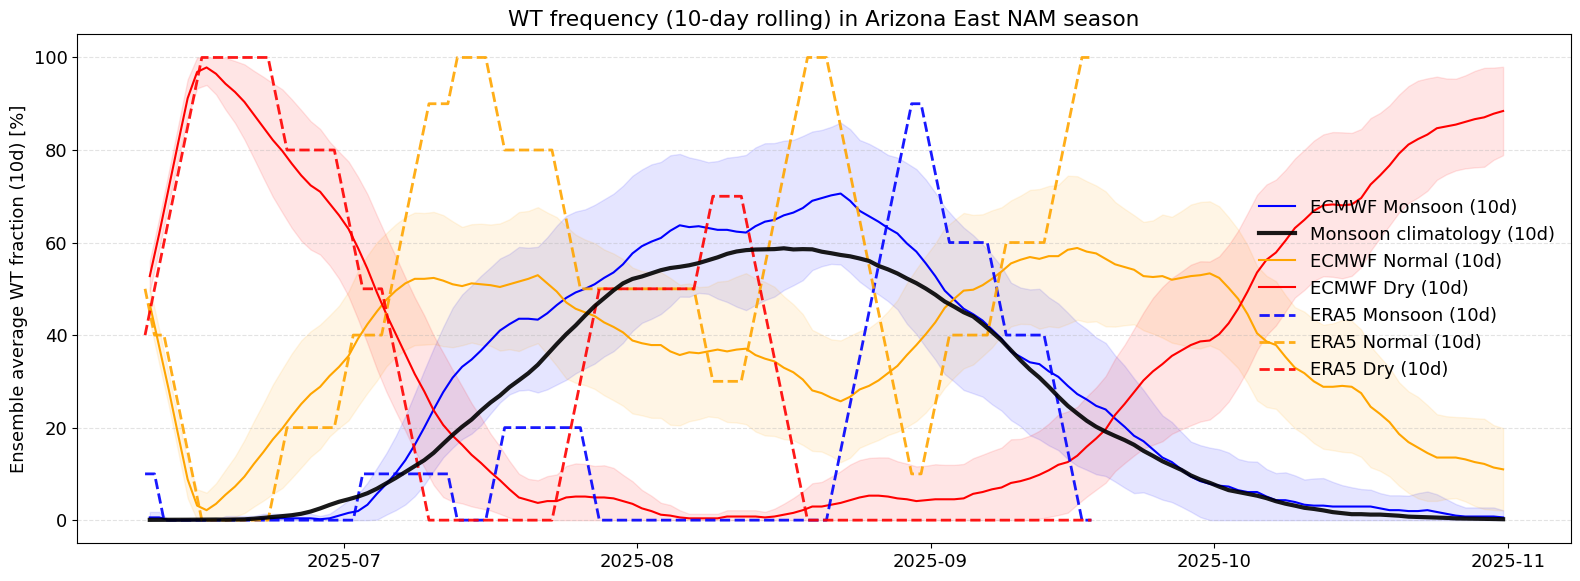

         region  lead  YYYYMM    dry  normal  monsoon
0  Arizona-East     6  202506  20.90    8.92     0.18
1  Arizona-East     6  202507   3.22   14.86    12.92
2  Arizona-East     6  202508   0.84   10.69    19.47
3  Arizona-East     6  202509   7.00   16.49     6.51
4  Arizona-East     6  202510  24.13    6.24     0.63
[OK] Arizona East in 66.8s

=== Running region: Arizona West (include_era=True) ===


Downloading...
From: https://drive.google.com/uc?id=13YM10r-THW6GJurtJp5FpGB9YYgfFx1Y
To: /content/cache/regions/Arizona_West/XWT_centroids.nc
100%|██████████| 414k/414k [00:00<00:00, 69.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NXfJ_I8Ow5X_wGSrvOUc80weeoXJMjwm
From (redirected): https://drive.google.com/uc?id=1NXfJ_I8Ow5X_wGSrvOUc80weeoXJMjwm&confirm=t&uuid=2c4f60b6-4c67-413e-b42b-a43f744ce8ff
To: /content/cache/regions/Arizona_West/ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz
100%|██████████| 220M/220M [00:01<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d83LgYNfAXD0IJn9FEy82VgMWkEZyY-W
To: /content/cache/regions/Arizona_West/NormalizationFactors.npz
100%|██████████| 18.6k/18.6k [00:00<00:00, 14.9MB/s]


Saved daily fractions CSV: ECMWF_WT-frequency_Arizona-West_daily_2025.csv
(ERA5 overlay) 10d non-NaN counts: {'monsoon_pct': 101, 'normal_pct': 101, 'dry_pct': 101} months: [6, 7, 8, 9]


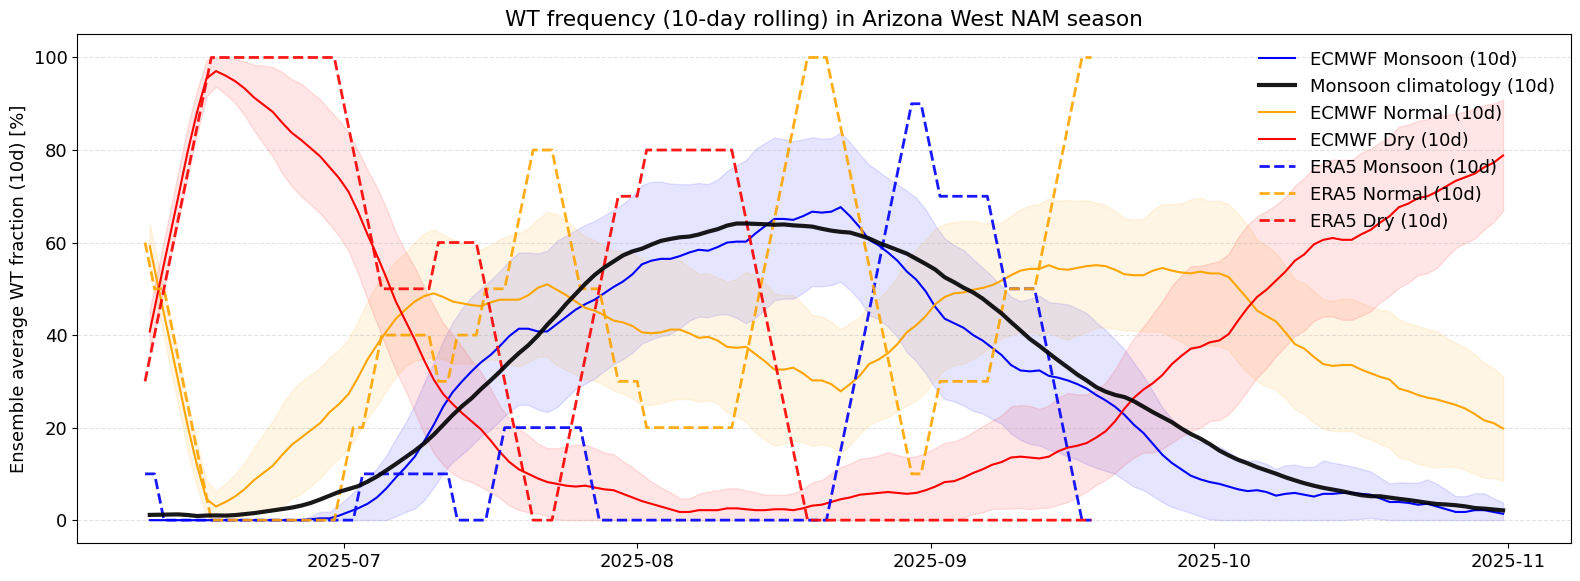

         region  lead  YYYYMM    dry  normal  monsoon
0  Arizona-West     6  202506  20.80    9.10     0.10
1  Arizona-West     6  202507   4.61   14.47    11.92
2  Arizona-West     6  202508   1.29   11.47    18.24
3  Arizona-West     6  202509   7.35   16.14     6.51
4  Arizona-West     6  202510  21.12    8.76     1.12
[OK] Arizona West in 31.1s

=== Running region: NM North (include_era=True) ===


Downloading...
From: https://drive.google.com/uc?id=1LxOGHeDwh2xd3JxBf6GRTv3dzluPBpew
To: /content/cache/regions/NM_North/XWT_centroids.nc
100%|██████████| 408k/408k [00:00<00:00, 59.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1p1EHa1hxoz10o3cwXfKm9ThEoLIyfyQ8
From (redirected): https://drive.google.com/uc?id=1p1EHa1hxoz10o3cwXfKm9ThEoLIyfyQ8&confirm=t&uuid=117c5889-be47-4c9c-aa47-9688ebb8c963
To: /content/cache/regions/NM_North/ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz
100%|██████████| 54.4M/54.4M [00:00<00:00, 99.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=18l7Z0oouQCudTxhR4u7kPnKeFkMpOP1T
To: /content/cache/regions/NM_North/NormalizationFactors.npz
100%|██████████| 5.09k/5.09k [00:00<00:00, 7.00MB/s]


Saved daily fractions CSV: ECMWF_WT-frequency_NM-North_daily_2025.csv
(ERA5 overlay) 10d non-NaN counts: {'monsoon_pct': 101, 'normal_pct': 101, 'dry_pct': 101} months: [6, 7, 8, 9]


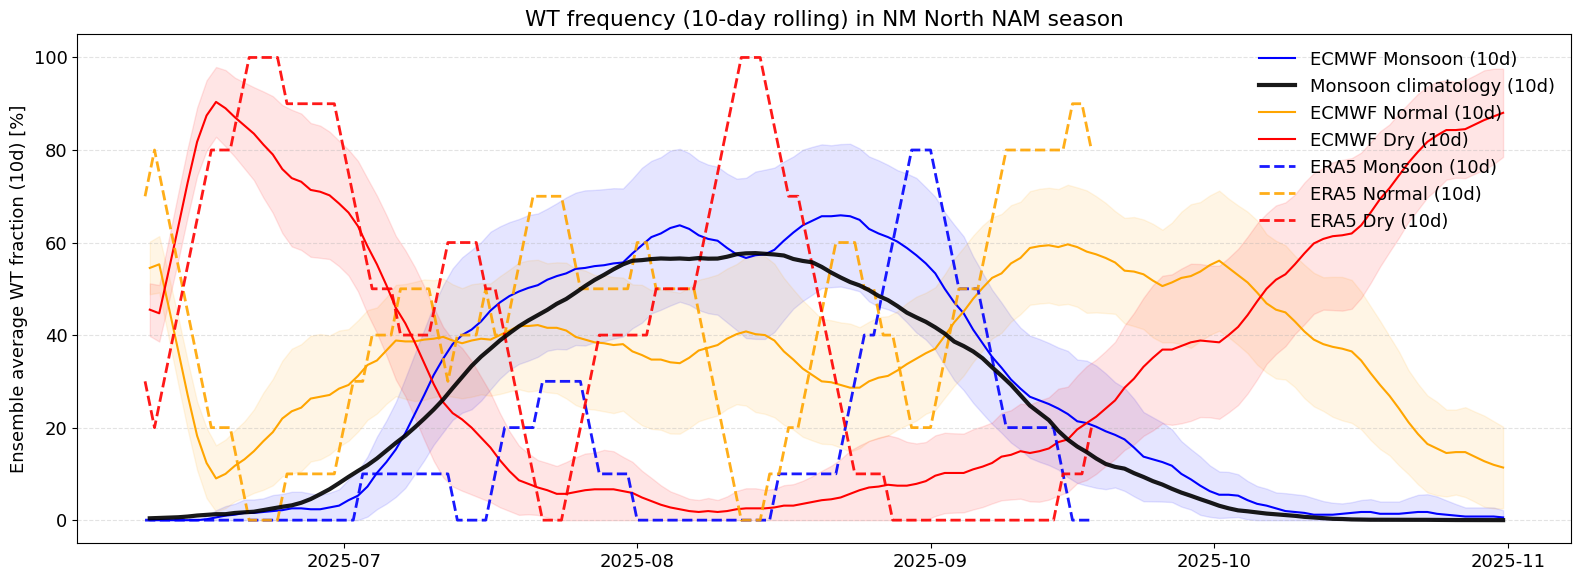

     region  lead  YYYYMM    dry  normal  monsoon
0  NM-North     6  202506  19.92    9.61     0.47
1  NM-North     6  202507   4.37   12.18    14.45
2  NM-North     6  202508   1.53   10.88    18.59
3  NM-North     6  202509   7.94   16.75     5.31
4  NM-North     6  202510  22.90    7.73     0.37
[OK] NM North in 28.4s

=== Running region: NM South (include_era=True) ===


Downloading...
From: https://drive.google.com/uc?id=1Ja2zyF4C92cRykpAJSyPVy_TIYd--feP
To: /content/cache/regions/NM_South/XWT_centroids.nc
100%|██████████| 408k/408k [00:00<00:00, 88.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=15O54WG27m860i9T3Mdckj5xLJcZ3MCfu
From (redirected): https://drive.google.com/uc?id=15O54WG27m860i9T3Mdckj5xLJcZ3MCfu&confirm=t&uuid=2969f5ed-6020-4a75-8083-c714f163d698
To: /content/cache/regions/NM_South/ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz
100%|██████████| 158M/158M [00:00<00:00, 200MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VN5cRkxxegu0AU5ijkkd9p623vVsFZI9
To: /content/cache/regions/NM_South/NormalizationFactors.npz
100%|██████████| 5.43k/5.43k [00:00<00:00, 2.83MB/s]


Saved daily fractions CSV: ECMWF_WT-frequency_NM-South_daily_2025.csv
(ERA5 overlay) 10d non-NaN counts: {'monsoon_pct': 101, 'normal_pct': 101, 'dry_pct': 101} months: [6, 7, 8, 9]


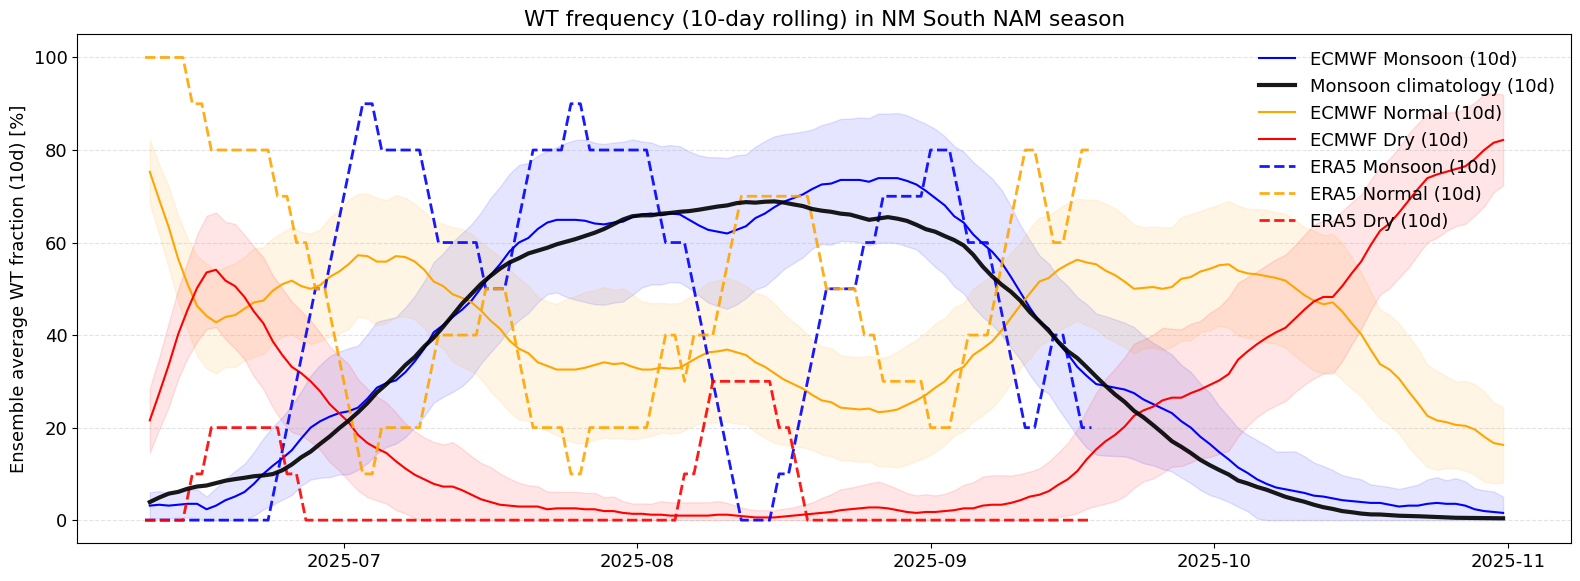

     region  lead  YYYYMM    dry  normal  monsoon
0  NM-South     6  202506   9.29   17.47     3.24
1  NM-South     6  202507   1.25   12.45    17.30
2  NM-South     6  202508   0.47    9.20    21.33
3  NM-South     6  202509   5.20   15.37     9.43
4  NM-South     6  202510  20.23    9.69     1.08
[OK] NM South in 30.9s
💾 Saved summary CSV: run_regions_summary_2025.csv


In [ ]:
# -----------------------------
# Run all regions (skip on missing data) + timing + CSV summary
# -----------------------------

# Optional: restrict to specific regions (otherwise run all)
TARGET_REGIONS = None  # e.g., ['Arizona West', 'NM North']

# run_region rolling-window parameters (10-day fractions)
# run_region rolling-window parameters (10-day fractions) + ERA toggle
RUN_KW = dict(WIN=10, MINP=10, center=False, include_era=True)   # set to False to disable ERA overlay

regions = TARGET_REGIONS if TARGET_REGIONS else list(sorted(REGION_CFG.keys()))
results = []
t0 = time.time()

for region in regions:
    start = time.time()
    try:
        print(f"\n=== Running region: {region} (include_era={RUN_KW['include_era']}) ===")
        run_region(region, **RUN_KW)  # <- include_era passed here
        status, msg, err_kind = "completed", "", ""
        dt = time.time() - start
        print(f"[OK] {region} in {dt:.1f}s")

    except FileNotFoundError as e:
        status, msg, err_kind = "skipped_missing_inputs", str(e), type(e).__name__
        dt = time.time() - start
        print(f"[SKIP] {region} → {e}")
    except Exception as e:
        status, msg, err_kind = "failed", str(e), type(e).__name__
        dt = time.time() - start
        print(f"[FAIL] {region} → {e}")
        traceback.print_exc(limit=2)  # shorter trace
    finally:
        results.append({
            "region": region,
            "status": status,
            "error_kind": err_kind,
            "seconds": round(dt, 2),
            "message": msg
        })
        # help free large arrays between regions
        gc.collect()

total = time.time() - t0
#print(f"\n==== Summary (total {total:.1f}s) ====")
df_summary = pd.DataFrame(results)
filename = f"run_regions_summary_{year_forecast}.csv"
df_summary.to_csv(filename, index=False)
print(f"💾 Saved summary CSV: {filename}")




In [ ]:
def run_region_multi(RegName: str, years: list[int], WIN: int = 10, MINP: int = 10, center: bool = False,
                     include_era: bool = True, clip_era_to_ecmwf_window: bool = False):
    """
    Plot ECMWF 10-day rolling WT fractions with ERA5 10-day rolling overlay for MULTIPLE YEARS.
    WIN: rolling window (days); MINP: min_periods; center: center the rolling window
    """

    cfg = REGION_CFG[RegName]
    re_idx  = cfg['re']
    WTsort  = cfg['WTsort']
    MONTHS  = [6, 7, 8, 9, 10]   # ECMWF season months for this plot
    OUT_DIR = Path(".")

    # Region cache dir
    rdir = REGIONS_DIR / RegName.replace(' ', '_')
    rdir.mkdir(parents=True, exist_ok=True)

    # Region files (download only once)
    centroids_nc = cached_gdown(cfg['sCentroidFile'], rdir / 'XWT_centroids.nc')
    era_npz      = cached_gdown(cfg['sERA_data'],     rdir / 'ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz')
    clusters_pkl = cached_gdown(cfg['sWTdata'],       rdir / 'Clusters_1982_2018_Q850_JJASO.pkl')
    norm_npz     = cached_gdown(cfg['NormFact'],      rdir / 'NormalizationFactors.npz')
    logging.info(f"\n=== Region: {RegName} ===")

    # --- Read centroids ---
    ncid = Dataset(centroids_nc, mode='r')
    rgrLonC = np.squeeze(ncid.variables['rlon'][:])
    rgrLatC = np.squeeze(ncid.variables['rlat'][:])
    ncid.close()

    # --- Load preprocessed ERA & PRISM ---
    DATA = np.load(era_npz, allow_pickle=True)
    rgrLonT  = DATA['LonWT']
    rgrLatT  = DATA['LatWT']

    # --- Load the Centroids ---
    with open(clusters_pkl, 'rb') as handle:
        npzfile = pickle.load(handle)
    WTclusters = npzfile['grClustersFin']['Full']
    WTlat      = npzfile['LatWT']
    WTlon      = npzfile['LonWT']
    WTtime     = npzfile['rgdTime']
    SpatialSmoothing = npzfile['SpatialSmoothing']

    # --- Subset IFS grid to WT domain ---
    iAddCells = 4
    iWest  = np.argmin(np.abs(WTlon.min() - LonS_base[0, :])) - iAddCells
    iEast  = np.argmin(np.abs(WTlon.max() - LonS_base[0, :])) + iAddCells
    iNort  = np.argmin(np.abs(WTlat.max() - LatS_base[:, 0])) + iAddCells
    iSouth = np.argmin(np.abs(WTlat.min() - LatS_base[:, 0])) - iAddCells

    LonS = LonS_base[iSouth:iNort, iWest:iEast]
    LatS = LatS_base[iSouth:iNort, iWest:iEast]

    # --- Interp weights: ECMWF (subset) -> WT grid ---
    pts_src = np.c_[LonS.flatten(), LatS.flatten()]
    vtx, wts = interp_weights(pts_src, np.c_[WTlon.flatten(), WTlat.flatten()])

    # allocate containers for all years
    roll_mean_all = {0: {}, 1: {}, 2: {}}
    roll_std_all  = {0: {}, 1: {}, 2: {}}
    era_all = {}
    idx_all_years = {}

    for year_forecast in years:
        print(f"\n=== Processing year: {year_forecast} ===")

        # Read ECMWF forecast GRIB (this must exist per year)
        FORECAST_PATH = Path(f"./ECMWF_forecast_{year_forecast}.grib")
        ds = xr.open_dataset(str(FORECAST_PATH), engine='cfgrib', decode_timedelta=True)
        DATA_fc = ds['q'].values  # (ens, step, lat, lon)
        # Flip lat to match ERA layout if needed, then slice ROI
        DATA_fc = DATA_fc[:, :, ::-1, :]
        DATA_fc = DATA_fc[:, :, iSouth:iNort, iWest:iEast]

        TIME = ds['valid_time'].values  # use directly

        # 12-hourly -> daily means; keep only months in MONTHS
        DATA_daily = (DATA_fc[:, 1::2] + DATA_fc[:, ::2]) / 2.0
        TIME_daily = TIME[::2]
        Time_datetime = pd.date_range(TIME_daily[0], end=TIME_daily[-1], freq='D')
        pick = np.isin(Time_datetime.month, MONTHS)
        xdates = np.array(Time_datetime[pick])

        # Allocate on WT grid: [time, lon, lat, var=1, ens]
        Data_on_centroid_grid = np.full((pick.sum(), WTlon.shape[0], WTlat.shape[1], 1, DATA_daily.shape[0]), np.nan)

        # Interpolate per member, per day
        for en in range(DATA_daily.shape[0]):
            slab = DATA_daily[en, pick, :, :]
            for tt in range(slab.shape[0]):
                vals = interpolate(slab[tt, :, :].flatten(), vtx, wts)
                Data_on_centroid_grid[tt, :, :, 0, en] = vals.reshape(WTlon.shape[0], WTlat.shape[1])

        # ==========================
        # Normalize & classify to WTs
        # ==========================
        NF = np.load(norm_npz, allow_pickle=True)['grNormalizationFactors']
        NormData = list(NF.item()[str(Time_datetime[0].month)])  # month-specific normalization

        T, _, _, _, E = Data_on_centroid_grid.shape  # T: days, E: ensemble members
        WT_NMME = np.full((T, E), np.nan)

        for en in range(E):
            member_data = Data_on_centroid_grid[:, :, :, :, en]
            if np.isnan(member_data).all():
                continue
            isNAN = np.isnan(np.nanmean(member_data, axis=(1, 2, 3)))
            DailyVarsEvalNorm = PreprocessWTdata(
                member_data,
                RelAnnom=RelAnnom,
                SmoothSigma=0,
                RemoveAnnualCycl=RemoveAnnualCycl,
                NormalizeData=NormalizeData,
                Normalize=NormData
            )
            EucDist, Corr, Manh, Cheb = EucledianDistance(DailyVarsEvalNorm, WTclusters)
            MinIdx = np.nanargmin(EucDist, axis=1).astype(float)
            MinIdx[isNAN] = np.nan
            WT_NMME[:, en] = MinIdx

        # Re-label to standard [0=Monsoon, 1=Normal, 2=Dry]
        WT_NMME_FIN = np.full_like(WT_NMME, np.nan)
        for new_wt, old_wt in enumerate(WTsort):
            WT_NMME_FIN[WT_NMME == old_wt] = float(new_wt)

        # ==========================
        # 10-day rolling ECMWF fractions + std
        # ==========================
        def _roll10_hits_mean_std(hits_2d: np.ndarray, idx_dates: pd.DatetimeIndex, win=10, minp=10, center=False):
            df_hits = pd.DataFrame(hits_2d, index=idx_dates)
            df_roll = df_hits.rolling(window=win, min_periods=minp, center=center).mean()
            mean_series = df_roll.mean(axis=1) * 100.0
            std_series  = df_roll.std(axis=1)  * 100.0
            return mean_series, std_series

        idx = pd.Index(pd.to_datetime(xdates), name="date")
        valid = np.isfinite(WT_NMME_FIN)  # [T, E]

        for wt in (0, 1, 2):
            hits = np.where(valid, (WT_NMME_FIN == wt).astype(float), np.nan)
            roll_mean_all[wt][year_forecast], roll_std_all[wt][year_forecast] = _roll10_hits_mean_std(
                hits, idx, win=WIN, minp=MINP, center=center)

        idx_all_years[year_forecast] = idx

        # ==========================
        # ERA5 overlay
        # ==========================
        df_era_10d = None
        if include_era:
            try:
                region_tag = RegName.replace(' ', '-')
                base_10d = f"ERA5_WT-10day-fractions_{region_tag}-{year_forecast}.csv"
                base_daily = f"ERA5_WT-frequency_{region_tag}-{year_forecast}_daily.csv"
                base_daily_typo = f"ERA5_WT-fraqtions_{region_tag}-{year_forecast}_daily.csv"

                def _find_file(dirs, name):
                    for d in dirs:
                        p = d / name
                        if p.exists(): return p
                        p1 = p.with_name(p.stem + " (1)" + p.suffix)
                        if p1.exists(): return p1
                    return None

                era_10d_dirs = [Path(''), OUT_DIR, Path.cwd() / 'ERA5_WT-frequency']
                era_daily_dirs = [Path(''), OUT_DIR, Path.cwd() / 'ERA5_WT-frequency']

                f10 = _find_file(era_10d_dirs, base_10d)
                if f10 is not None:
                    df_era_10d = pd.read_csv(f10, parse_dates=[0], index_col=0)
                    df_era_10d.columns = [c.strip().lower() for c in df_era_10d.columns]
                    rename_10d = {
                        'monsoon_pct_10d': 'monsoon_pct',
                        'normal_pct_10d':  'normal_pct',
                        'dry_pct_10d':     'dry_pct'
                    }
                    for k, v in rename_10d.items():
                        if k in df_era_10d.columns and v not in df_era_10d.columns:
                            df_era_10d[v] = pd.to_numeric(df_era_10d[k], errors='coerce')
                    keep_cols = [c for c in ['monsoon_pct','normal_pct','dry_pct'] if c in df_era_10d.columns]
                    df_era_10d = df_era_10d[keep_cols]

                if df_era_10d is None or df_era_10d.empty:
                    fday = _find_file(era_daily_dirs, base_daily) or _find_file(era_daily_dirs, base_daily_typo)
                    if fday is not None:
                        df_era_daily = pd.read_csv(fday, parse_dates=[0], index_col=0)
                        df_era_daily.columns = [c.strip().lower() for c in df_era_daily.columns]
                        for k, v in {'monsoon':'monsoon_pct', 'normal':'normal_pct', 'dry':'dry_pct'}.items():
                            if k in df_era_daily.columns and v not in df_era_daily.columns:
                                df_era_daily[v] = pd.to_numeric(df_era_daily[k], errors='coerce')
                        cols = [c for c in ['monsoon_pct','normal_pct','dry_pct'] if c in df_era_daily.columns]
                        if cols:
                            df_era_10d = df_era_daily[cols].rolling(window=WIN, min_periods=MINP, center=center).mean()
                        else:
                            df_era_10d = None
                    else:
                        df_era_10d = None

                if df_era_10d is not None and not df_era_10d.empty:
                    df_era_10d.index = pd.to_datetime(df_era_10d.index)
                    df_era_10d = df_era_10d[df_era_10d.index.month.isin(MONTHS)]
                    if clip_era_to_ecmwf_window:
                        xmin, xmax = pd.to_datetime(xdates[0]), pd.to_datetime(xdates[-1])
                        df_era_10d = df_era_10d[(df_era_10d.index >= xmin) & (df_era_10d.index <= xmax)]
                    df_era_10d = df_era_10d.dropna(how='all')

                era_all[year_forecast] = df_era_10d
            except Exception as e:
                print(f"(ERA5 overlay) error: {e}")
                era_all[year_forecast] = None
        else:
            era_all[year_forecast] = None

    # ==========================
    # Plot (multi-year)
    # ==========================
    # ==========================
    # Plot (multi-year, compressed JJASO timeline, one legend entry per WT type)
    # ==========================
    fig, ax = plt.subplots(figsize=(18, 6))
    plt.rcParams.update({'font.size': 13})

    WT_Names  = ['Monsoon', 'Normal', 'Dry']
    WT_colors = ['b', 'orange', 'r']
    MONTHS_KEEP = [6, 7, 8, 9, 10]  # JJASO only
    JJASO_DAYS = 153  # Fixed JJASO season length

    xticks = []
    xticklabels = []
    plotted_labels = set()  # to deduplicate legend entries

    for year_idx, year in enumerate(years):
        x_base = np.arange(JJASO_DAYS) + year_idx * JJASO_DAYS

        # ========== ECMWF ==========
        for wt in range(3):
            frac_10d = roll_mean_all[wt][year]
            std_10d  = roll_std_all[wt][year]
            idx_dates = idx_all_years[year]

            keep = idx_dates.month.isin(MONTHS_KEEP)
            frac_10d = frac_10d[keep]
            std_10d  = std_10d[keep]

            # Pad or trim to JJASO_DAYS
            y = np.full(JJASO_DAYS, np.nan)
            s = np.full(JJASO_DAYS, np.nan)
            n = min(JJASO_DAYS, len(frac_10d))
            y[:n] = frac_10d.values[:n]
            s[:n] = std_10d.values[:n]

            label = f'ECMWF {WT_Names[wt]}'
            if label in plotted_labels:
                label = None
            else:
                plotted_labels.add(label)

            ax.plot(x_base, y, label=label, color=WT_colors[wt], alpha=0.8)
            ax.fill_between(x_base,
                            np.maximum(y - s / 2.0, 0),
                            np.minimum(y + s / 2.0, 100),
                            color=WT_colors[wt], alpha=0.08)

        # ========== ERA5 ==========
        if include_era and era_all[year] is not None:
            df_era_10d = era_all[year]
            df_era_10d = df_era_10d[df_era_10d.index.month.isin(MONTHS_KEEP)]
            for col, color, name in zip(['monsoon_pct','normal_pct','dry_pct'], WT_colors, WT_Names):
                if col in df_era_10d.columns:
                    y_vals = df_era_10d[col].values
                    y_pad = np.full(JJASO_DAYS, np.nan)
                    n = min(JJASO_DAYS, len(y_vals))
                    y_pad[:n] = y_vals[:n]

                    label = f'ERA5 {name}'
                    if label in plotted_labels:
                        label = None
                    else:
                        plotted_labels.add(label)

                    ax.plot(x_base, y_pad,
                            linestyle='--', linewidth=2.0, color=color, alpha=0.9,
                            label=label, zorder=2)

        # ========== Climatology ==========
        try:
            clim_daily = np.asarray(wt_freq_climmean[0, 4, :, re_idx], dtype=float)  # July index = 6 - 2
            clim_daily = np.ravel(clim_daily)
            if np.nanmax(clim_daily) <= 1.0 + 1e-6:
                clim_daily *= 100.0
            clim_daily = clim_daily[:JJASO_DAYS]
            clim_10d = pd.Series(clim_daily).rolling(window=WIN, min_periods=MINP, center=center).mean()

            label = 'Monsoon climatology (10d)' if 'Monsoon climatology (10d)' not in plotted_labels else None
            if label:
                plotted_labels.add(label)

            ax.plot(x_base, clim_10d, color='k', lw=2.5, label=label, zorder=5)
        except Exception as e:
            print(f"(Climatology error): {e}")

        # ========== X-Axis ticks ==========
        for m, label_month in zip(range(6, 11), ['Jun', 'Jul', 'Aug', 'Sep', 'Oct']):
            day_of_month = 15 + (m - 6) * 30
            if day_of_month < JJASO_DAYS:
                xticks.append(x_base[day_of_month])
                xticklabels.append(f"{label_month}-{year}")

    # ========== Final formatting ==========
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_ylabel('Ensemble average WT fraction (10d) [%]')
    ax.set_ylim(0, 100)
    ax.set_title(f'WT frequency (10-day rolling) in {RegName} NAM season [{years[0]}–{years[-1]}]')
    ax.grid(axis='y', ls='--', alpha=0.3)
    ax.legend(frameon=False, loc='upper left', ncol=3)
    plt.tight_layout()

    out_pdf = OUT_DIR / f"ECMWF_WT-frequency_{RegName.replace(' ', '-')}_{years[0]}-{years[-1]}_JJASO-uniform.pdf"
    plt.savefig(out_pdf, bbox_inches='tight', dpi=200)
    plt.show()





=== Processing year: 2023 ===

=== Processing year: 2024 ===

=== Processing year: 2025 ===


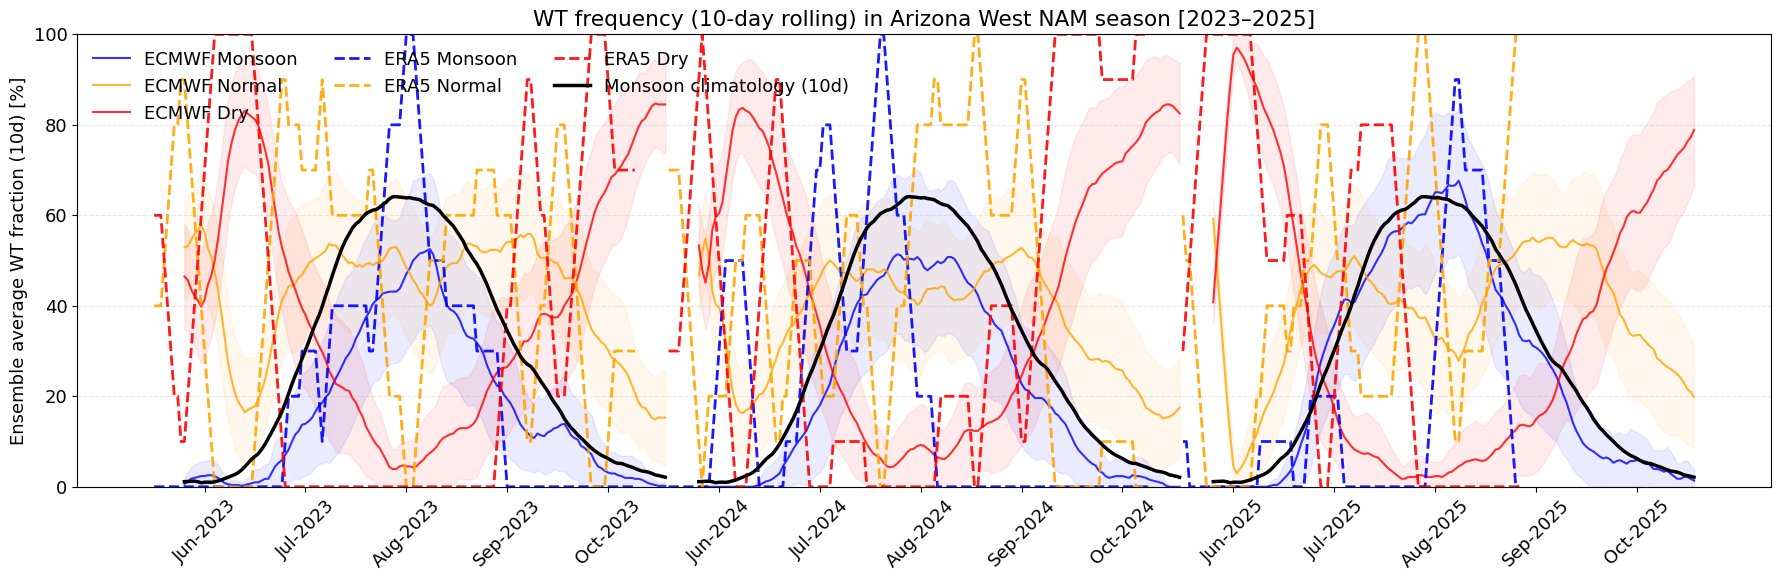

In [ ]:
run_region_multi("Arizona West", years=[2023, 2024, 2025], WIN=10, MINP=10, center=False, include_era=True)



=== Processing year: 2023 ===

=== Processing year: 2024 ===

=== Processing year: 2025 ===


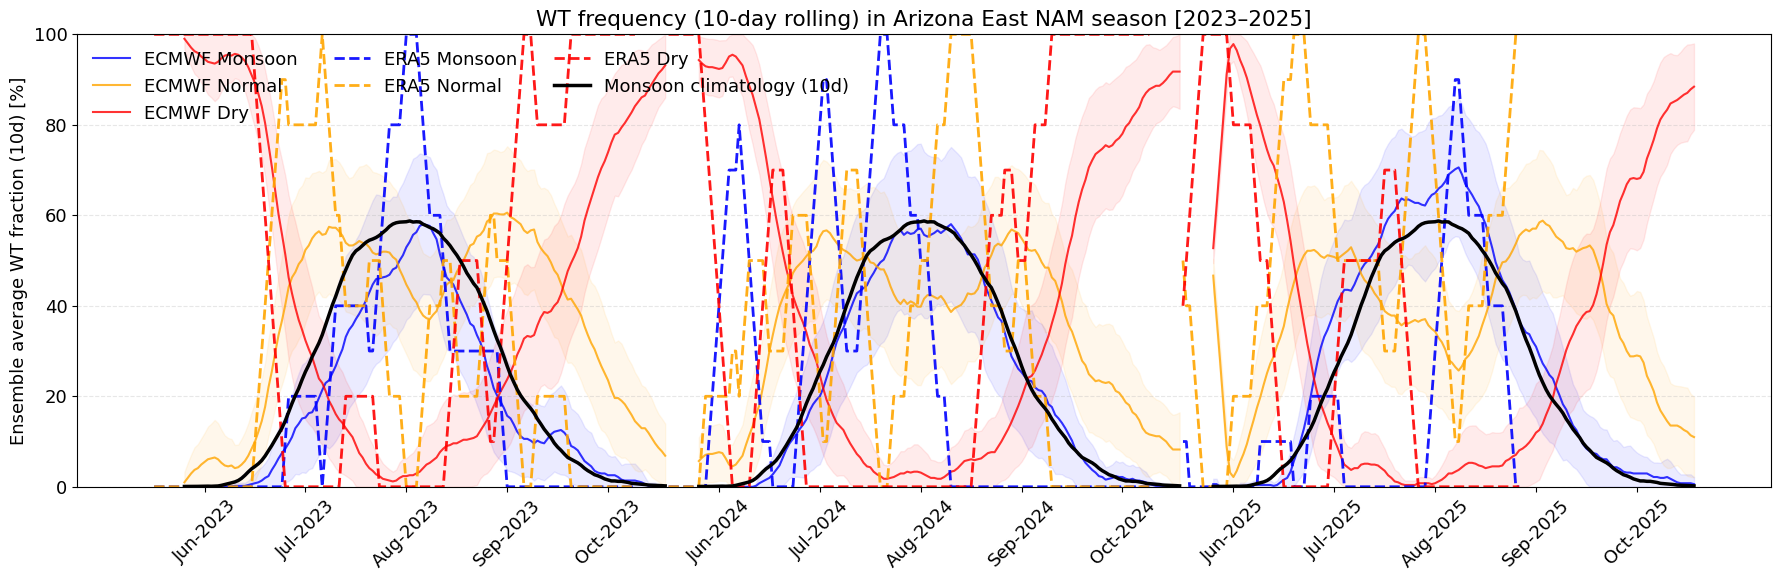

In [ ]:
run_region_multi("Arizona East", years=[2023, 2024, 2025], WIN=10, MINP=10, center=False, include_era=True)



=== Processing year: 2023 ===

=== Processing year: 2024 ===

=== Processing year: 2025 ===


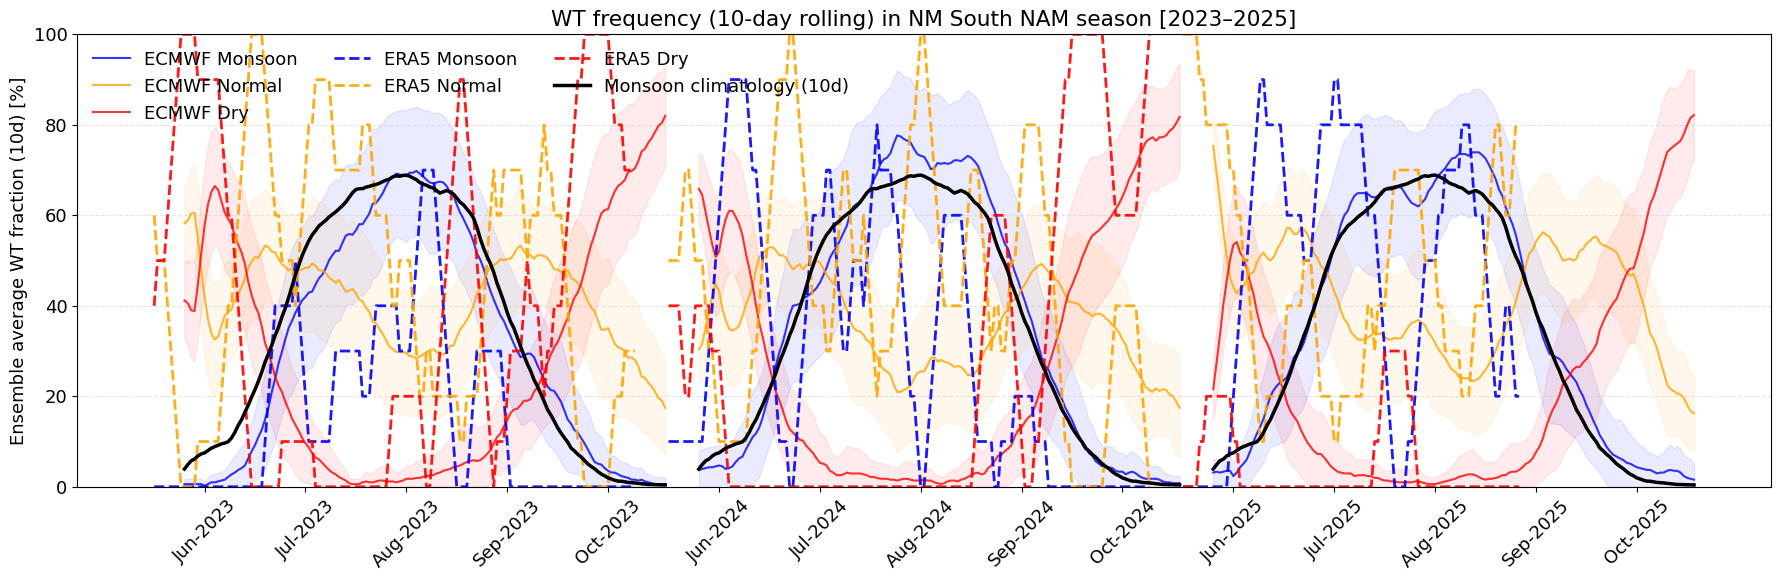

In [ ]:
run_region_multi("NM South", years=[2023, 2024, 2025], WIN=10, MINP=10, center=False, include_era=True)



=== Processing year: 2023 ===

=== Processing year: 2024 ===

=== Processing year: 2025 ===


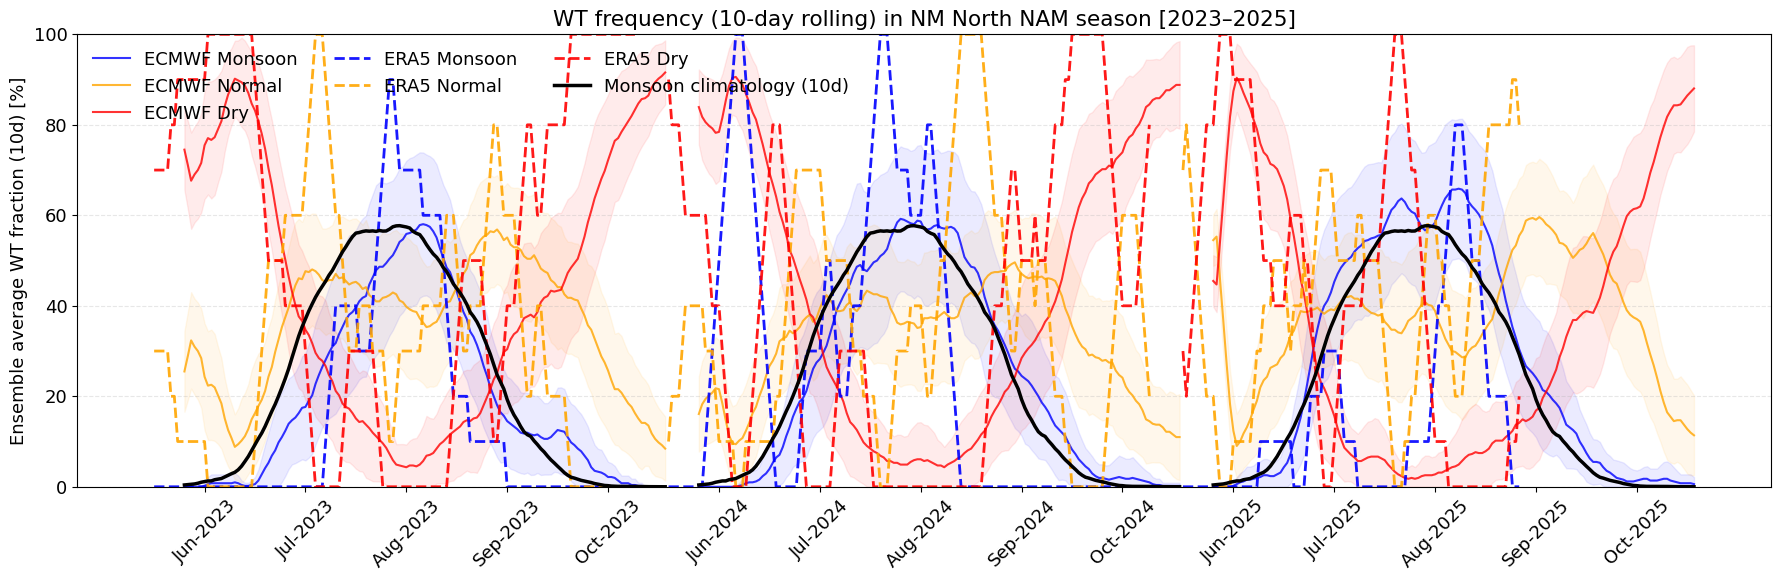

In [ ]:
run_region_multi("NM North", years=[2023, 2024, 2025], WIN=10, MINP=10, center=False, include_era=True)


# Daily plots

In [ ]:
# -----------------------------
# Helper: run one region end-to-end (ECMWF only; ERA overlay removed)
# -----------------------------
def run_region(RegName: str):
    cfg = REGION_CFG[RegName]
    re_idx  = cfg['re']
    WTsort  = cfg['WTsort']
    MONTHS = [6, 7, 8, 9, 10]

    # Region cache dir
    rdir = REGIONS_DIR / RegName.replace(' ', '_')
    rdir.mkdir(parents=True, exist_ok=True)

    # Region files (download only once)
    centroids_nc = cached_gdown(cfg['sCentroidFile'], rdir / 'XWT_centroids.nc')
    era_npz      = cached_gdown(cfg['sERA_data'],     rdir / 'ERA-Interim_PRISM_data_1982_2018_Q850_JJASO.npz')
    clusters_pkl = cached_gdown(cfg['sWTdata'],       rdir / 'Clusters_1982_2018_Q850_JJASO.pkl')
    norm_npz     = cached_gdown(cfg['NormFact'],      rdir / 'NormalizationFactors.npz')
    logging.info(f"\n=== Region: {RegName} ===")

    # --- Read centroids ---
    ncid = Dataset(centroids_nc, mode='r')
    rgrLonC = np.squeeze(ncid.variables['rlon'][:])
    rgrLatC = np.squeeze(ncid.variables['rlat'][:])
    ncid.close()

    # --- Load preprocessed ERA & PRISM ---
    DATA = np.load(era_npz, allow_pickle=True)
    rgrLonT  = DATA['LonWT']
    rgrLatT  = DATA['LatWT']

    # --- Load the Centroids ---
    with open(clusters_pkl, 'rb') as handle:
        npzfile = pickle.load(handle)
    WTclusters = npzfile['grClustersFin']['Full']
    WTlat      = npzfile['LatWT']
    WTlon      = npzfile['LonWT']
    WTtime     = npzfile['rgdTime']
    SpatialSmoothing = npzfile['SpatialSmoothing']

    # --- Subset IFS grid to WT domain ---
    iAddCells = 4
    iWest  = np.argmin(np.abs(WTlon.min() - LonS_base[0, :])) - iAddCells
    iEast  = np.argmin(np.abs(WTlon.max() - LonS_base[0, :])) + iAddCells
    iNort  = np.argmin(np.abs(WTlat.max() - LatS_base[:, 0])) + iAddCells
    iSouth = np.argmin(np.abs(WTlat.min() - LatS_base[:, 0])) - iAddCells

    LonS = LonS_base[iSouth:iNort, iWest:iEast]
    LatS = LatS_base[iSouth:iNort, iWest:iEast]

    # --- Interp weights: ECMWF (subset) -> WT grid ---
    pts_src = np.c_[LonS.flatten(), LatS.flatten()]
    vtx, wts = interp_weights(pts_src, np.c_[WTlon.flatten(), WTlat.flatten()])

    # --- Read ECMWF forecast GRIB (once, reused for all regions) ---
    ds = xr.open_dataset(str(FORECAST_PATH), engine='cfgrib', decode_timedelta=True)
    DATA_fc = ds['q'].values  # (ens, step, lat, lon)

    # Flip lat to match ERA layout if needed and slice ROI
    DATA_fc = DATA_fc[:, :, ::-1, :]
    DATA_fc = DATA_fc[:, :, iSouth:iNort, iWest:iEast]

    TIME_UNIX = ds['valid_time'].values
    TIME = TIME_UNIX  # use directly

    # 12-hourly -> daily means; keep only JJASO
    DATA_daily = (DATA_fc[:, 1::2] + DATA_fc[:, ::2]) / 2.0
    TIME_daily = TIME[::2]
    Time_datetime = pd.date_range(TIME_daily[0], end=TIME_daily[-1], freq='D')
    pick = np.isin(Time_datetime.month, MONTHS)
    xdates = np.array(Time_datetime[pick])

    # Allocate on WT grid: [time, lon, lat, var=1, ens]
    Data_on_centroid_grid = np.full((pick.sum(), WTlon.shape[0], WTlat.shape[1], 1, DATA_daily.shape[0]), np.nan)

    # Interpolate per member, per day
    for en in range(DATA_daily.shape[0]):
        slab = DATA_daily[en, pick, :, :]
        for tt in range(slab.shape[0]):
            vals = interpolate(slab[tt, :, :].flatten(), vtx, wts)
            Data_on_centroid_grid[tt, :, :, 0, en] = vals.reshape(WTlon.shape[0], WTlat.shape[1])

    # ==========================
    # Normalize & classify to WTs
    # ==========================
    NF = np.load(norm_npz, allow_pickle=True)['grNormalizationFactors']
    NormData = list(NF.item()[str(Time_datetime[0].month)])  # month-specific normalization

    T, _, _, _, E = Data_on_centroid_grid.shape  # T: days, E: ensemble members
    WT_NMME = np.full((T, E), np.nan)

    for en in range(E):
        member_data = Data_on_centroid_grid[:, :, :, :, en]
        if np.isnan(member_data).all():
            continue
        isNAN = np.isnan(np.nanmean(member_data, axis=(1, 2, 3)))
        DailyVarsEvalNorm = PreprocessWTdata(
            member_data,
            RelAnnom=RelAnnom,
            SmoothSigma=0,
            RemoveAnnualCycl=RemoveAnnualCycl,
            NormalizeData=NormalizeData,
            Normalize=NormData
        )
        EucDist, Corr, Manh, Cheb = EucledianDistance(DailyVarsEvalNorm, WTclusters)
        MinIdx = np.nanargmin(EucDist, axis=1).astype(float)
        MinIdx[isNAN] = np.nan
        WT_NMME[:, en] = MinIdx

    # Re-label to standard [0=Monsoon, 1=Normal, 2=Dry]
    WT_NMME_FIN = np.full_like(WT_NMME, np.nan)
    for new_wt, old_wt in enumerate(WTsort):
        WT_NMME_FIN[WT_NMME == old_wt] = float(new_wt)

    # ---------------------------
    # Debug / print daily ECMWF WTs
    # ---------------------------
    arr = np.asarray(WT_NMME_FIN)
    if arr.ndim == 1:
        arr = arr[:, None]

    T, E = arr.shape
    print(f"Daily ECMWF WTs (remapped) shape: T={T}, E={E}")

    dates = pd.to_datetime(np.asarray(xdates))
    idx = pd.Index(dates, name="date") if len(dates) == T else pd.Index(range(T), name="day")

    cols = [f"ens_{i}" for i in range(E)]
    df_labels = pd.DataFrame(arr, index=idx, columns=cols)
    #print("\nFirst 30 days — per-ensemble WT labels (0=Monsoon,1=Normal,2=Dry; 999=missing):")
    #print(df_labels.head(30).to_string())

    frac_mon = np.nanmean(arr == 0, axis=1) * 100.0
    frac_norm= np.nanmean(arr == 1, axis=1) * 100.0
    frac_dry = np.nanmean(arr == 2, axis=1) * 100.0
    df_frac = pd.DataFrame({
        "monsoon_pct": frac_mon,
        "normal_pct":  frac_norm,
        "dry_pct":     frac_dry
    }, index=idx)
    #print("\nFirst 30 days — daily ensemble fractions [%]:")
    #print(df_frac.head(30).to_string())

    # optional save daily ECMWF fractions
    try:
        out_daily_csv = OUT_DIR / f"ECMWF_WT-frequency_{RegName.replace(' ', '-')}_daily_{year_forecast}.csv"
        df_frac.to_csv(out_daily_csv, index=True)
        print(f"Saved daily fractions CSV: {out_daily_csv}")
    except Exception as e:
        print("Could not save daily CSV:", e)

    # -------------------------
    # Plot (ECMWF daily ensemble-mean WT frequency only)
    # -------------------------
    fig = plt.figure(figsize=(16, 6))
    plt.rcParams.update({'font.size': 13})

    WT_Names  = ['Monsoon', 'Normal', 'Dry']
    WT_colors = ['b', 'orange', 'r']

    valid = np.isfinite(WT_NMME_FIN)  # [T, E]

    # ---- ECMWF daily fractions (solid) + spread
    for wt in range(3):
        hits   = (WT_NMME_FIN == wt)
        frac   = np.nanmean(np.where(valid, hits, np.nan), axis=1) * 100.0
        spread = np.nanstd(np.where(valid, hits, np.nan), axis=1) * 100.0
        MIN    = np.maximum(frac - spread / 2.0, 0.0)

        plt.plot(xdates, frac, label=f'ECMWF {WT_Names[wt]}', color=WT_colors[wt])
        plt.fill_between(xdates, MIN, frac + spread / 2.0, color=WT_colors[wt], alpha=0.1)

        if wt == 0:
            # Monsoon climatology line (daily; unchanged)
            plt.plot(
                xdates,
                wt_freq_climmean[wt, Time_datetime[0].month - 2, :, re_idx][-WT_NMME_FIN.shape[0]:] * 100.0,
                c='k', lw=3, alpha=0.7, label='Monsoon\nclimatology', zorder=0
            )

    plt.legend(frameon=False)
    plt.ylabel('Ensemble average fraction of WTs [%]')
    plt.title(f'WT frequency in {RegName} NAM season')

    out_pdf = f'ECMWF_WT-frequency_{RegName.replace(" ", "-")}_{year_forecast}.pdf'
    plt.savefig(out_pdf, bbox_inches='tight', dpi=200)
    plt.show()
    plt.close(fig)
    logging.info(f"💾 Saved: {out_pdf}")

    # ============================
    # Compute monthly ensemble-mean WT COUNTS (sums to days)
    # ============================
    rgiDDmon = [30, 31, 31, 30, 31]  # JJASO defaults
    if sum(rgiDDmon) != len(xdates):
        months_index = np.asarray(xdates).astype('datetime64[M]')
        _, month_counts = np.unique(months_index, return_counts=True)
        rgiDDmon = month_counts.tolist()

    n_months = len(rgiDDmon)
    E = WT_NMME_FIN.shape[1]
    starts = np.r_[0, np.cumsum(rgiDDmon)[:-1]]
    ends   = np.cumsum(rgiDDmon)

    WT_MM = np.zeros((n_months, 3, E), dtype=float)

    for wt in range(3):
        for mm in range(n_months):
            start = int(starts[mm]); end = int(ends[mm]); ndays = int(rgiDDmon[mm])
            slab = WT_NMME_FIN[start:end, :]  # [ndays, E]
            raw_counts = np.sum(slab == wt, axis=0).astype(float)
            valid_days = np.sum(np.isin(slab, [0.0, 1.0, 2.0]), axis=0).astype(float)
            with np.errstate(divide='ignore', invalid='ignore'):
                WT_MM[mm, wt, :] = np.where(valid_days > 0, raw_counts * (ndays / valid_days), np.nan)

    DATA_mm = np.nanmean(WT_MM, axis=2)  # [n_months, 3]
    DATA_mm = np.round(DATA_mm, 2)

    # Nudge rows to exact ndays
    for mm in range(n_months):
        ndays = float(rgiDDmon[mm])
        residual = np.round(ndays - np.nansum(DATA_mm[mm, :]), 2)
        if np.isfinite(residual) and residual != 0:
            j = int(np.nanargmax(DATA_mm[mm, :]))
            DATA_mm[mm, j] = np.round(DATA_mm[mm, j] + residual, 2)

    monthly_labels = pd.to_datetime(np.asarray(xdates)[starts])
    YYYYMM = [int(ts.year * 100 + ts.month) for ts in monthly_labels]
    lead_month = int(pd.to_datetime(xdates[0]).month)

    df = pd.DataFrame({
        'region':  [RegName.replace(' ', '-')] * n_months,
        'lead':    [lead_month] * n_months,
        'YYYYMM':  YYYYMM,
        'dry':     DATA_mm[:, 2],
        'normal':  DATA_mm[:, 1],
        'monsoon': DATA_mm[:, 0],
    })
    #print(df)

    csv_out = f"2.ECMWF_WT-frequency_{RegName.replace(' ', '-')}_monthly_{year_forecast}.csv"
    df.to_csv(csv_out, index=False)
    logging.info(f"📄 Saved monthly WT frequency CSV: {csv_out}")



=== Running region: Arizona East ===
Daily ECMWF WTs (remapped) shape: T=153, E=51
Saved daily fractions CSV: /content/ECMWF_WT-frequency_Arizona-East_daily_2025.csv


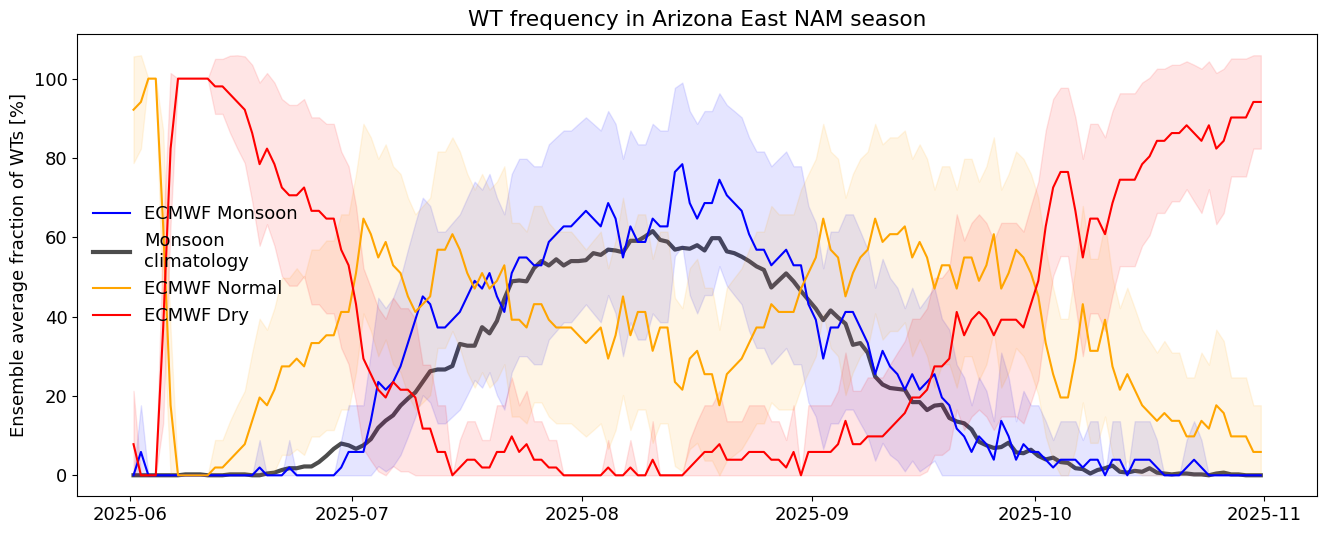

[OK] Arizona East in 22.2s

=== Running region: Arizona West ===
Daily ECMWF WTs (remapped) shape: T=153, E=51
Saved daily fractions CSV: /content/ECMWF_WT-frequency_Arizona-West_daily_2025.csv


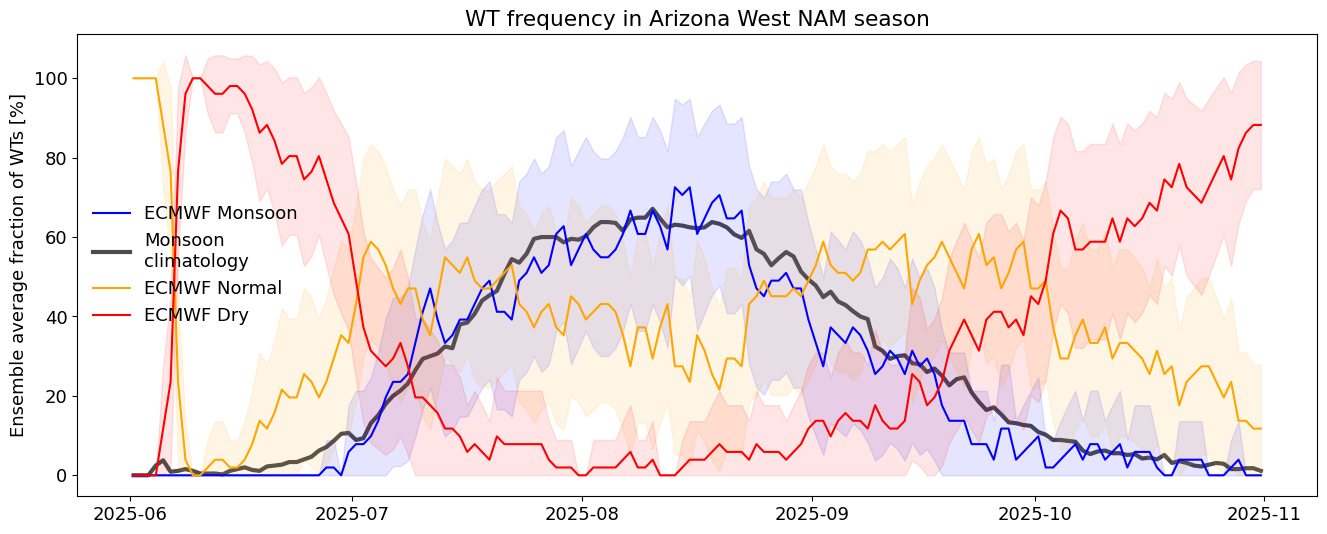

[OK] Arizona West in 23.2s

=== Running region: NM North ===
Daily ECMWF WTs (remapped) shape: T=153, E=51
Saved daily fractions CSV: /content/ECMWF_WT-frequency_NM-North_daily_2025.csv


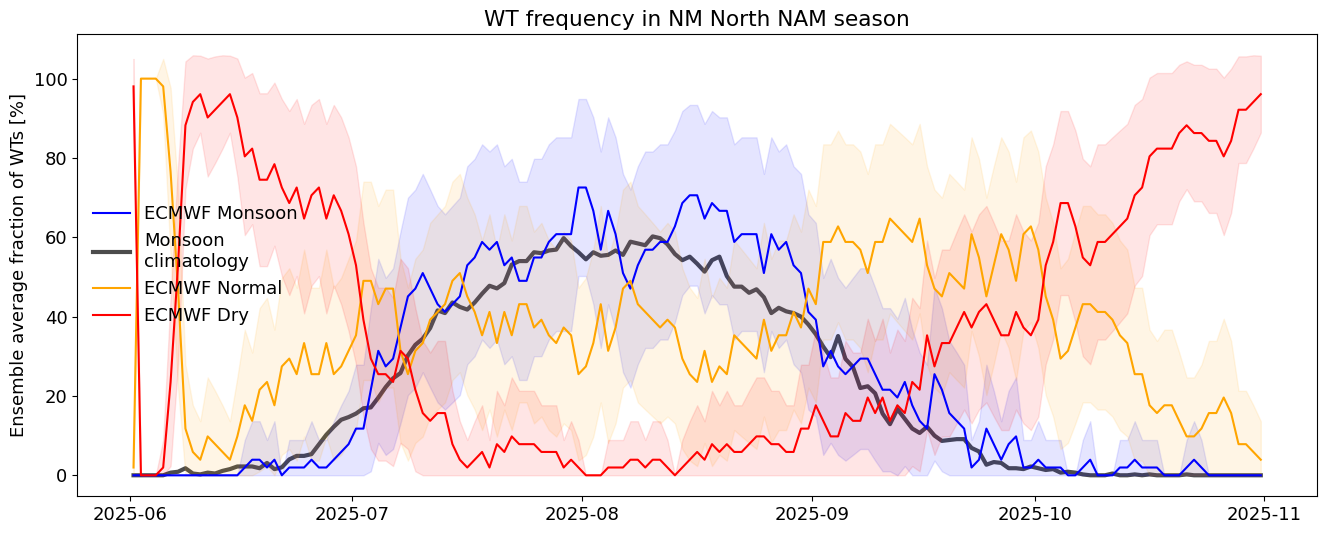

[OK] NM North in 22.5s

=== Running region: NM South ===
Daily ECMWF WTs (remapped) shape: T=153, E=51
Saved daily fractions CSV: /content/ECMWF_WT-frequency_NM-South_daily_2025.csv


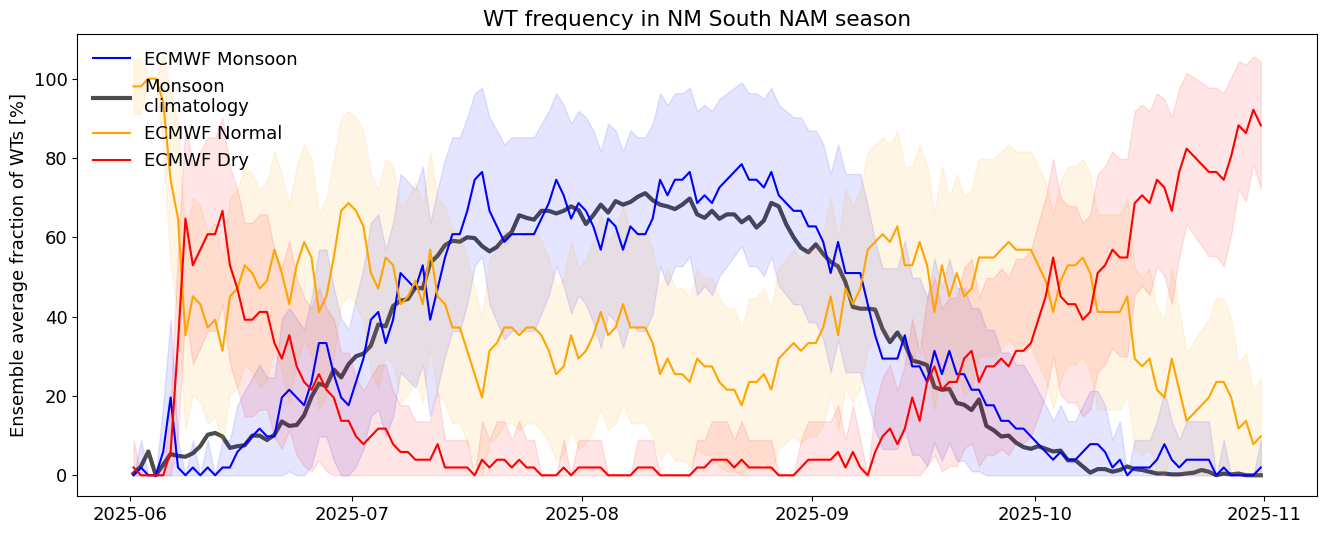

[OK] NM South in 22.5s
💾 Saved summary CSV: run_regions_summary_2025.csv


In [ ]:
# --- Run all regions + timing + summary CSV ---
# Optional: restrict to a subset of regions (otherwise run all)
TARGET_REGIONS = None  # e.g., ['Arizona West', 'NM North']

regions = TARGET_REGIONS if TARGET_REGIONS else list(sorted(REGION_CFG.keys()))
results = []
t0 = time.time()

for region in regions:
    start = time.time()
    try:
        print(f"\n=== Running region: {region} ===")
        run_region(region)
        dt = time.time() - start
        print(f"[OK] {region} in {dt:.1f}s")
        results.append({
            "region": region,
            "status": "completed",
            "error_kind": "",
            "seconds": round(dt, 2),
            "message": ""
        })
    except FileNotFoundError as e:
        dt = time.time() - start
        print(f"[SKIP] {region} → {e}")
        results.append({
            "region": region,
            "status": "skipped_missing_inputs",
            "error_kind": type(e).__name__,
            "seconds": round(dt, 2),
            "message": str(e)
        })
    except Exception as e:
        dt = time.time() - start
        print(f"[FAIL] {region} → {e}")
        traceback.print_exc(limit=2)
        results.append({
            "region": region,
            "status": "failed",
            "error_kind": type(e).__name__,
            "seconds": round(dt, 2),
            "message": str(e)
        })
    finally:
        gc.collect()

total = time.time() - t0
#print(f"\n==== Summary (total {total:.1f}s) ====")
df_summary = pd.DataFrame(results)
filename = f"run_regions_summary_{year_forecast}.csv"
df_summary.to_csv(filename, index=False)
print(f"💾 Saved summary CSV: {filename}")



### **ECMWF_WT-frequency_monsoon-WT-forecast_ensemble-mean.csv**

In [ ]:
# Monthly ECMWF weather-type frequency CSV files
csv_folder = Path(".")
csv_files = list(csv_folder.glob(f"1.ECMWF_WT-frequency_*_monthly_{year_forecast}.csv"))
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
df_all["region"] = df_all["region"].str.strip().str.replace("-", "_")
region_name_map = {
    "Arizona_East": "AZ_East",
    "Arizona_West": "AZ_West",
    "NM_North": "NM_North",
    "NM_South": "NM_South",
}
df_all["region"] = df_all["region"].replace(region_name_map)
combined_csv_path = csv_folder / f"ECMWF_WT-frequency_monsoon-WT-forecast_ensemble-mean_{year_forecast}.csv"
df_all.to_csv(combined_csv_path, index=False)
print(f"✅ Combined CSV saved to: {combined_csv_path}")


✅ Combined CSV saved to: ECMWF_WT-frequency_monsoon-WT-forecast_ensemble-mean_2025.csv


The output .csv file can be found by clicking on the file symbol in the left pannel and by refreshing the data files. Below is a screenshot showing the file.

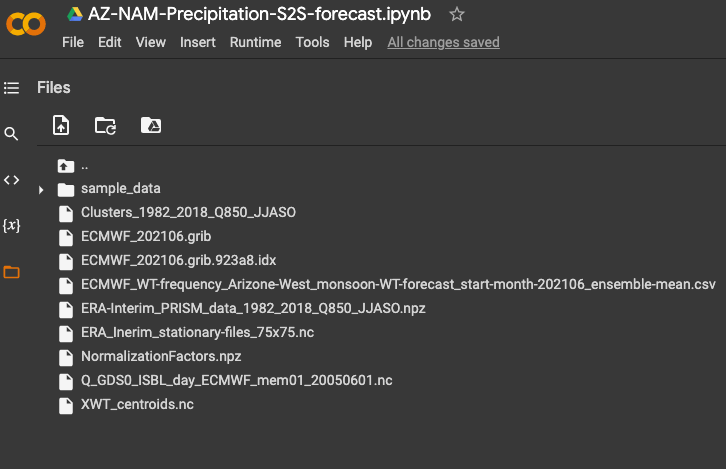

# **S2S Precipitation Forecast Evaluation using Logistic and Linear Regression**

This section impliments S2S precipitation forecasting across the Southwest U.S. using various predictors using models that incorporate weather types (WT) and other climate variables.
This notebook builds on the original R code and methodology developed by Erin Towler for weather type (WT) predictors. We translated the code into Python and expanded it to include additional climate predictors.

**Input file:** \
`Predictors_filled.csv` \
**Outputs:** \
`gof_training_hindcast_final.csv` \
`ecmwf_prediction_final.csv`

*Nina Omani* \
4/11/2025 *italicized text*

In [ ]:
!pip install pandas numpy scikit-learn scipy matplotlib

In [ ]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.formula.api as smf
from matplotlib import patches as mpatches
from matplotlib.lines import Line2D
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## 1. Combine forecast WTs from previous steps to hindcast dataset `paired_PRISM_ECMWF_WT_1981_2023.csv`. (e.g. 2025 lead:6 months: 6,7,8,9,10)

In [ ]:
# Reload the base hindcast and forecast data
base_path = "paired_PRISM_ECMWF_WT_1981_2023.csv"
url = "https://drive.google.com/uc?id=1Gjwgcr5HWnBCxUfhHFfcKDlmwN_ti81I"
gdown.download(url, base_path, quiet=False)
forecast_path = f"ECMWF_WT-frequency_monsoon-WT-forecast_ensemble-mean_{year_forecast}.csv"

base_df = pd.read_csv(base_path)
forecast_df = pd.read_csv(forecast_path)

# Fix types for base_df
base_df["Month"] = pd.to_numeric(base_df["Month"], errors='coerce')
base_df["Year"] = pd.to_numeric(base_df["Year"], errors='coerce').astype("Int64")

# Forecast preparation
forecast_df = forecast_df.rename(columns={
    "dry": "dry.for",
    "normal": "normal.for",
    "monsoon": "monsoon.for"
})
forecast_df["region"] = forecast_df["region"].replace({
    "Arizona-West": "AZ_West",
    "Arizona-East": "AZ_East",
    "NewMexico-North": "NM_North",
    "NewMexico-South": "NM_South"
})
forecast_df["year"] = forecast_df["YYYYMM"] // 100
forecast_df["month"] = forecast_df["YYYYMM"] % 100
forecast_df["dry.obs"] = np.nan
forecast_df["normal.obs"] = np.nan
forecast_df["monsoon.obs"] = np.nan
forecast_df["areal_mean_precipitation_mm_day"] = np.nan
forecast_df = forecast_df.rename(columns={"lead": "lead_month"})

# Select and align columns
forecast_df = forecast_df[[
    "year", "month", "region", "lead_month",
    "dry.for", "normal.for", "monsoon.for",
    "dry.obs", "normal.obs", "monsoon.obs",
    "areal_mean_precipitation_mm_day"
]]

base_df.columns = base_df.columns.str.lower()
forecast_df.columns = forecast_df.columns.str.lower()

# Combine
combined_df = pd.concat([base_df, forecast_df], ignore_index=True)

# Confirm required columns exist and types are correct
combined_df["month"] = pd.to_numeric(combined_df["month"], errors="coerce")
combined_df["lead_month"] = pd.to_numeric(combined_df["lead_month"], errors="coerce")

# Now redefine seasons and aggregate
season_definitions = {
    "Jun": (combined_df["lead_month"].isin([4, 5, 6])) & (combined_df["month"] == 6),
    "Jul": (combined_df["lead_month"].isin([4, 5, 6, 7])) & (combined_df["month"] == 7),
    "Aug": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"] == 8),
    "Sep": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"] == 9),
    "Oct": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"] == 10),
    "JJASO": (combined_df["lead_month"].isin([4, 5, 6])) & (combined_df["month"].isin([6, 7, 8, 9, 10])),
    "JJA": (combined_df["lead_month"].isin([4, 5, 6])) & (combined_df["month"].isin([6, 7, 8])),
    "JJ": (combined_df["lead_month"].isin([4, 5, 6])) & (combined_df["month"].isin([6, 7])),
    "JASO": (combined_df["lead_month"].isin([4, 5, 6, 7])) & (combined_df["month"].isin([7, 8, 9, 10])),
    "JAS": (combined_df["lead_month"].isin([4, 5, 6, 7])) & (combined_df["month"].isin([7, 8, 9])),
    "JA": (combined_df["lead_month"].isin([4, 5, 6, 7])) & (combined_df["month"].isin([7, 8])),
    "ASO": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"].isin([8, 9, 10])),
    "AS": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"].isin([8, 9])),
    "SO": (combined_df["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_df["month"].isin([9, 10])),
}

# Perform seasonal aggregation
final_data = pd.DataFrame()
for season, condition in season_definitions.items():
    season_data = combined_df[condition].copy()
    season_data["season"] = season

    aggregated = season_data.groupby(["year", "region", "season", "lead_month"], as_index=False).agg({
        "dry.for": "sum",
        "normal.for": "sum",
        "monsoon.for": "sum",
        "dry.obs": lambda x: x.sum(min_count=1),
        "normal.obs": lambda x: x.sum(min_count=1),
        "monsoon.obs": lambda x: x.sum(min_count=1),
        "areal_mean_precipitation_mm_day": "mean"
    })

    aggregated.rename(columns={
        "dry.for": "sumDry_for",
        "normal.for": "sumNormal_for",
        "monsoon.for": "sumMonsoon_for",
        "dry.obs": "sumDry_obs",
        "normal.obs": "sumNormal_obs",
        "monsoon.obs": "sumMonsoon_obs",
        "areal_mean_precipitation_mm_day": "avgPCP_mmDay"
    }, inplace=True)
    final_data = pd.concat([final_data, aggregated], ignore_index=True)

# Save result
final_data.sort_values(by=["region", "season", "lead_month", "year"], inplace=True)
final_path = "paired_allSeasons_ECMWF_PRISM_WT_1981_2025.csv"
final_data.to_csv(final_path, index=False)

final_path

Downloading...
From: https://drive.google.com/uc?id=1Gjwgcr5HWnBCxUfhHFfcKDlmwN_ti81I
To: /content/paired_PRISM_ECMWF_WT_1981_2023.csv
100%|██████████| 301k/301k [00:00<00:00, 38.5MB/s]


'paired_allSeasons_ECMWF_PRISM_WT_1981_2025.csv'

# 2.Incorporate atmospheric predictors (optional)

In [ ]:
ATM_PREDICTOR = True

In [ ]:
if ATM_PREDICTOR:
    # Re-load forecast and ERA files and rebuild `combined_atm` for processing
    # Download the updated ERA data (1981-2025) from Google Drive or produce them using notebook "1.Prepare_AtmVar_Forecast_BOR.ipynb"

    forecast_file = "5_combined_forecast_variables.csv"
    !gdown 'https://drive.google.com/uc?id=1v7UBGLFzqtPT3wzWuMTxzzapuPrDYhoW' -O  "5_combined_forecast_variables.csv"

    # Mapping of Google Drive URLs to output filenames
    file_map = {
        "https://drive.google.com/file/d/1h60f8vJSA77I9FBKgxZZhR61jVujA5Lf/view?usp=drive_link": "ERA_q_regional_updated_1981on.csv",
        "https://drive.google.com/file/d/1ooTdFaf1c_ztVbokfPiB-Xuq9cKutLAG/view?usp=drive_link": "ERA_tclw_regional_updated_1981on.csv",
        "https://drive.google.com/file/d/1HwNH8bKGANc6ZsZE6kAgnMz3PYUnrusW/view?usp=drive_link": "ERA_tcwv_regional_updated_1981on.csv",
        "https://drive.google.com/file/d/1RK8Y9iSUuLoAo3xYyis8l5vMOGXlHH17/view?usp=drive_link": "ERA_tprate_regional_updated_1981on.csv"
    }

    for url, output in file_map.items():
        file_id = url.split("/d/")[1].split("/view")[0]
        gdown.download(id=file_id, output=output, quiet=False)

    era_files = {
        "q": "ERA_q_regional_updated_1981on.csv",
        "tclw": "ERA_tclw_regional_updated_1981on.csv",
        "tcwv": "ERA_tcwv_regional_updated_1981on.csv",
        "tprate": "ERA_tprate_regional_updated_1981on.csv"
    }

    # Read and clean forecast data
    forecast_data = pd.read_csv(forecast_file)
    forecast_data.columns = forecast_data.columns.str.strip().str.lower()
    forecast_data = forecast_data.rename(columns={"init_month": "lead_month"})
    forecast_data["lead_month"] = pd.to_numeric(forecast_data["lead_month"], errors='coerce')
    forecast_data["year"] = pd.to_numeric(forecast_data["year"], errors='coerce').astype("Int64")

    # Rename forecast variables
    forecast_data = forecast_data.rename(columns={
        "q": "q_for", "tclw": "tclw_for", "tcwv": "tcwv_for", "tprate": "tprate_for"
    })

    combined_atm = forecast_data.copy()

    # Merge in ERA observations
    for var, file_path in era_files.items():
        era_data = pd.read_csv(file_path)
        era_data.columns = era_data.columns.str.strip().str.lower()

        if "tp" in era_data.columns:
            era_data["tp"] = era_data["tp"] / 86400
            era_data.rename(columns={"tp": "tprate"}, inplace=True)

        era_data = era_data.rename(columns={var: f"{var}_obs"})

        combined_atm = combined_atm.merge(
            era_data[["year", "month", "region", f"{var}_obs"]],
            on=["year", "month", "region"],
            how="left"
        )

    season_definitions = {
        "Jun": (combined_atm["lead_month"].isin([4, 5, 6])) & (combined_atm["month"] == 6),
        "Jul": (combined_atm["lead_month"].isin([4, 5, 6, 7])) & (combined_atm["month"] == 7),
        "Aug": (combined_atm["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_atm["month"] == 8),
        "Sep": (combined_atm["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_atm["month"] == 9),
        "Oct": (combined_atm["lead_month"].isin([5, 6, 7, 8])) & (combined_atm["month"] == 10),
        "JJASO": (combined_atm["lead_month"].isin([5, 6])) & (combined_atm["month"].isin([6, 7, 8, 9, 10])),
        "JJA": (combined_atm["lead_month"].isin([4, 5, 6])) & (combined_atm["month"].isin([6, 7, 8])),
        "JJ": (combined_atm["lead_month"].isin([4, 5, 6])) & (combined_atm["month"].isin([6, 7])),
        "JASO": (combined_atm["lead_month"].isin([5, 6, 7])) & (combined_atm["month"].isin([7, 8, 9, 10])),
        "JAS": (combined_atm["lead_month"].isin([4, 5, 6, 7])) & (combined_atm["month"].isin([7, 8, 9])),
        "JA": (combined_atm["lead_month"].isin([4, 5, 6, 7])) & (combined_atm["month"].isin([7, 8])),
        "ASO": (combined_atm["lead_month"].isin([5, 6, 7, 8])) & (combined_atm["month"].isin([8, 9, 10])),
        "AS": (combined_atm["lead_month"].isin([4, 5, 6, 7, 8])) & (combined_atm["month"].isin([8, 9])),
        "SO": (combined_atm["lead_month"].isin([5, 6, 7, 8])) & (combined_atm["month"].isin([9, 10])),
    }

    # Aggregate using mean
    final_data = pd.DataFrame()
    for season, condition in season_definitions.items():
        season_data = combined_atm[condition].copy()
        season_data["season"] = season

        # ✅ Determine how many months required for this season
        # extract months from condition logic: use season_months dict (same as earlier)
        # We'll count unique months per (year, region, lead_month)
        required_months = season_data["month"].nunique()  # or hardcode via dict
        # Instead of above, build a dict like you did for precipitation seasons

        # Count non-NaN entries per (year, region, lead_month)
        counts = (
            season_data.dropna(subset=["q_obs"])  # you can use any var here
            .groupby(["year", "region", "lead_month"], as_index=False)["month"]
            .nunique()
            .rename(columns={"month": "n_months"})
        )

        # Only keep complete (year, region, lead_month) groups
        required_months = season_data["month"].nunique()

        complete_keys = counts.copy()
        complete_keys["is_complete_obs"] = complete_keys["n_months"] == required_months

        # Left join to keep all forecast rows, attach completeness info for obs
        season_data = season_data.merge(complete_keys[["year", "region", "lead_month", "is_complete_obs"]],
                                        on=["year", "region", "lead_month"], how="left")

        # Fill obs values only if complete, otherwise NaN
        for col in ["q_obs", "tclw_obs", "tcwv_obs", "tprate_obs"]:
            season_data[col] = np.where(season_data["is_complete_obs"], season_data[col], np.nan)

        # Clean up temp column
        season_data.drop(columns=["is_complete_obs"], inplace=True)

        aggregated = season_data.groupby(["year", "region", "season", "lead_month"], as_index=False).agg({
            "q_for": lambda x: x.sum(min_count=1),
            "tclw_for": lambda x: x.sum(min_count=1),
            "tcwv_for": lambda x: x.sum(min_count=1),
            "tprate_for": lambda x: x.sum(min_count=1),
            "q_obs": lambda x: x.sum(min_count=1),
            "tclw_obs": lambda x: x.sum(min_count=1),
            "tcwv_obs": lambda x: x.sum(min_count=1),
            "tprate_obs": lambda x: x.sum(min_count=1),
        })

        aggregated.rename(columns={
            "q_for": "sumq_for",
            "tclw_for": "sumtclw_for",
            "tcwv_for": "sumtcwv_for",
            "tprate_for": "sumtprate_for",
            "q_obs": "sumq_obs",
            "tclw_obs": "sumtclw_obs",
            "tcwv_obs": "sumtcwv_obs",
            "tprate_obs": "sumtprate_obs"
        }, inplace=True)

        final_data = pd.concat([final_data, aggregated], ignore_index=True)


    # Sort and save
    final_data.sort_values(by=["region", "season", "lead_month", "year"], inplace=True)
    final_path = "paired_allSeasons_ECMWF_ERA_ATM_1981_2025.csv"
    final_data.to_csv(final_path, index=False)

    print(final_path)

Downloading...
From: https://drive.google.com/uc?id=1v7UBGLFzqtPT3wzWuMTxzzapuPrDYhoW
To: /content/5_combined_forecast_variables.csv
100% 239k/239k [00:00<00:00, 37.0MB/s]


Downloading...
From: https://drive.google.com/uc?id=1h60f8vJSA77I9FBKgxZZhR61jVujA5Lf
To: /content/ERA_q_regional_updated_1981on.csv
100%|██████████| 39.7k/39.7k [00:00<00:00, 8.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ooTdFaf1c_ztVbokfPiB-Xuq9cKutLAG
To: /content/ERA_tclw_regional_updated_1981on.csv
100%|██████████| 39.7k/39.7k [00:00<00:00, 10.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HwNH8bKGANc6ZsZE6kAgnMz3PYUnrusW
To: /content/ERA_tcwv_regional_updated_1981on.csv
100%|██████████| 39.3k/39.3k [00:00<00:00, 47.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RK8Y9iSUuLoAo3xYyis8l5vMOGXlHH17
To: /content/ERA_tprate_regional_updated_1981on.csv
100%|██████████| 39.9k/39.9k [00:00<00:00, 53.6MB/s]


paired_allSeasons_ECMWF_ERA_ATM_1981_2025.csv


In [ ]:
import pandas as pd
import numpy as np
import os

# Define file paths
wt_file = "paired_allSeasons_ECMWF_PRISM_WT_1981_2025.csv"
atm_file = "paired_allSeasons_ECMWF_ERA_ATM_1981_2025.csv"
output_file = "Predictors_filled.csv"

# Load WT data
wt_df = pd.read_csv(wt_file)

# Try loading ATM data and merge if it exists
if os.path.exists(atm_file):
    atm_df = pd.read_csv(atm_file)
    merged_df = pd.merge(wt_df, atm_df, on=["year", "region", "season", "lead_month"], how="outer")
    print(f"[INFO] Merged with atmospheric predictors: {atm_file}")

    # Only replace "nana" in new ATM columns (if they exist)
    atm_cols = [c for c in merged_df.columns if c not in wt_df.columns and c not in ["year", "region", "season", "lead_month"]]
    if atm_cols:
        merged_df[atm_cols] = merged_df[atm_cols].replace("nana", np.nan)
else:
    merged_df = wt_df.copy()
    print("[INFO] Atmospheric predictors not found. Proceeding with WT data only.")

# Save result as Predictors_filled.csv
merged_df.to_csv(output_file, index=False)
print(f"[SAVED] {output_file}")


[INFO] Merged with atmospheric predictors: paired_allSeasons_ECMWF_ERA_ATM_1981_2025.csv
[SAVED] Predictors_filled.csv


# 3.Extend seasonal PRISM precipitation if available (optional)

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import gdown

RUN_PRECIP_PROCESS = True

if RUN_PRECIP_PROCESS:

    precip_path = "aerial_mean_precipitation_timeseries_2024_25.csv"
    gdown.download('https://drive.google.com/uc?id=1efn9LpMxOj-E9lx7p4KLnKGbnEmwqyo-', precip_path, quiet=False)

    wt_path     = "Predictors_filled.csv"  # Use updated merged dataset
    out_precip  = "seasonal_precip.csv"
    out_joined  = "Predictors_filled.csv"  # Save updated version back here

    # ---- Season definitions ----
    season_months = {
        "Jun": [6], "Jul": [7], "Aug": [8], "Sep": [9], "Oct": [10],
        "JJASO": [6,7,8,9,10], "JJA": [6,7,8], "JJ": [6,7],
        "JASO": [7,8,9,10], "JAS": [7,8,9], "JA": [7,8],
        "ASO": [8,9,10], "AS": [8,9], "SO": [9,10],
    }
    season_leads = {
        "Jun": [4,5,6],
        "Jul": [4,5,6,7],
        "Aug": [4,5,6,7,8],
        "Sep": [4,5,6,7,8],
        "Oct": [4,5,6,7,8],
        "JJASO": [4,5,6],
        "JJA": [4,5,6],
        "JJ": [4,5,6],
        "JASO": [4,5,6,7],
        "JAS": [4,5,6,7],
        "JA": [4,5,6,7],
        "ASO": [4,5,6,7,8],
        "AS": [4,5,6,7,8],
        "SO": [4,5,6,7,8],
    }

    if not Path(precip_path).exists():
        print(f"⚠️ Precip file not found: {precip_path}. Skipping seasonal precipitation calculation and join.")
    else:
        # ---------- 1) Build seasonal_precip (wide -> long -> seasonal with full coverage only) ----------
        pw = pd.read_csv(precip_path)

        pw["YYYYMM"] = pd.to_numeric(pw["YYYYMM"], errors="coerce").astype("Int64")
        pw["year"]   = (pw["YYYYMM"] // 100).astype("Int64")
        pw["month"]  = (pw["YYYYMM"] % 100).astype(int)

        # Wide → long
        p_long = pw.melt(
            id_vars=["year", "month"],
            value_vars=["AZ_West", "AZ_East", "NM_North", "NM_South"],
            var_name="region",
            value_name="pcp"
        )
        p_long["pcp"] = pd.to_numeric(p_long["pcp"], errors="coerce")

        parts = []
        for season, months in season_months.items():
            sec = p_long[p_long["month"].isin(months)].copy()

            counts = (
                sec.dropna(subset=["pcp"])
                   .groupby(["year", "region"], as_index=False)["month"]
                   .nunique()
                   .rename(columns={"month": "n_months"})
            )
            complete_pairs = counts.loc[counts["n_months"] == len(months), ["year", "region"]]
            if complete_pairs.empty:
                continue

            sec_comp = sec.merge(complete_pairs, on=["year", "region"], how="inner")

            comp = (
                sec_comp.groupby(["year", "region"], as_index=False)["pcp"]
                        .mean()
                        .rename(columns={"pcp": "avgPCP_mmDay"})
            )
            comp["season"] = season

            leads_df = pd.DataFrame({"lead_month": season_leads[season]})
            comp["key"] = 1
            leads_df["key"] = 1
            comp = comp.merge(leads_df, on="key").drop(columns="key")

            parts.append(comp)

        if parts:
            seasonal_precip = pd.concat(parts, ignore_index=True)
            seasonal_precip = seasonal_precip[["year", "region", "season", "lead_month", "avgPCP_mmDay"]].copy()
            seasonal_precip["lead_month"] = pd.to_numeric(seasonal_precip["lead_month"], errors="coerce")
        else:
            seasonal_precip = pd.DataFrame(columns=["year", "region", "season", "lead_month", "avgPCP_mmDay"])

        seasonal_precip.sort_values(["region", "season", "lead_month", "year"]).to_csv(out_precip, index=False)

        # ---------- 2) Join seasonal precip into Predictors_filled.csv ----------
        wt = pd.read_csv(wt_path)

        merged = wt.merge(
            seasonal_precip,
            on=["year", "region", "season", "lead_month"],
            how="left",
            suffixes=("", "_from_precip")
        )

        precip_years = pw["year"].dropna().unique()

        if "avgPCP_mmDay" in merged.columns:
            merged["avgPCP_mmDay"] = np.where(
                merged["avgPCP_mmDay_from_precip"].notna(),
                merged["avgPCP_mmDay_from_precip"],
                np.where(merged["year"].isin(precip_years), np.nan, merged["avgPCP_mmDay"])
            )
            merged.drop(columns=["avgPCP_mmDay_from_precip"], inplace=True)
        else:
            merged.rename(columns={"avgPCP_mmDay_from_precip": "avgPCP_mmDay"}, inplace=True)

        merged.sort_values(["region", "season", "lead_month", "year"]).to_csv(out_joined, index=False)
        final_data = merged.copy()
        print(f"✅ Updated seasonal precipitation and saved: {out_precip} and {out_joined}")


Downloading...
From: https://drive.google.com/uc?id=1efn9LpMxOj-E9lx7p4KLnKGbnEmwqyo-
To: /content/aerial_mean_precipitation_timeseries_2024_25.csv
100%|██████████| 1.06k/1.06k [00:00<00:00, 3.27MB/s]


✅ Updated seasonal precipitation and saved: seasonal_precip.csv and Predictors_filled.csv


## 3.Configurations

In [ ]:
# Evaluation period
min_year, max_year = 1993, 2018 # For prediction

In [ ]:
INPUT_CSV = "Predictors_filled.csv"
TARGET_SEASON = 'JAS'  # None/"ALL" => all seasons, or "JJASO", or ["JJASO","MAM"]

df = pd.read_csv(INPUT_CSV)
df['season'] = df['season'].astype(str).str.strip().str.upper()
chosen = (sorted(df['season'].dropna().unique().tolist())
          if (TARGET_SEASON is None or (isinstance(TARGET_SEASON, str) and TARGET_SEASON.strip().upper() in ("ALL","")))
          else ([TARGET_SEASON.strip().upper()] if isinstance(TARGET_SEASON, str) else [str(s).strip().upper() for s in TARGET_SEASON]))
Predictors_filled = df[df['season'].isin(chosen)].copy()
Predictors_filled['season'] = pd.Categorical(Predictors_filled['season'], categories=chosen, ordered=True)


**4. Multi-Linear Regression (MLR)** \
Models with different combinations of predictors are defined. \
Training metrics (RMSE_train and R²_MLR_train) and hindcast metrics (RMSE_ECMWF and R²_ECMWF)  are computed. \
**Output:** \
`GOF_MLR_all` and `ecmwf_predictions_MLR.csv`.

In [ ]:
# Define multi-predictor models
combined_model_specs = {
    "multi_linear1": ["sumMonsoon_obs", "sumDry_obs"],
    "multi_linear2": ["sumq_obs", "antecedent_3m_obs"],
    "multi_linear3": ["sumMonsoon_obs", "sumDry_obs", "antecedent_3m_obs"]
}
# Define multi-predictor models
combined_model_specs = {
    "multi_linear1": ["sumMonsoon_obs", "sumDry_obs"]
}

In [ ]:
import numpy as np
import pandas as pd
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Inputs expected to already exist:
# - Predictors_filled (DataFrame)
# - custom_season_order (list)
# - combined_model_specs: dict like {'M1':['p1_obs','p2_obs'], ...}
# - min_year, max_year

ecmwf_gof_mlr = []
ecmwf_results_MLR = []

for model_key, predictors in combined_model_specs.items():
    # columns we need for training (OBS)
    cols = ["region", "season", "year", "avgPCP_mmDay", "lead_month"] + predictors
    df_model = Predictors_filled[cols].dropna().drop_duplicates()

    for region in df_model["region"].unique():
        for season in df_model["season"].unique():
            df_train = df_model[
                (df_model["region"] == region) &
                (df_model["season"] == season) &
                (df_model["year"] >= min_year) &
                (df_model["year"] <= max_year)
            ].copy()

            # Sufficient training records?
            required_count_train = 0.5 * (max_year - min_year + 1)
            if len(df_train) < required_count_train:
                print(f"⚠️ Skipping training {region}-{season} {predictors} ({len(df_train)} < {required_count_train})")
                continue
            if df_train.empty:
                continue

            # --- Safe names and normalization (OBS full training stats) ---
            safe_names = {p: p.replace(".", "_") for p in predictors}
            x_cols = [f"x_{safe_names[p]}" for p in predictors]

            norm_means = {p: df_train[p].mean() for p in predictors}
            norm_stds  = {p: df_train[p].std()  for p in predictors}

            # Guard zero/NaN std
            if any(pd.isna(norm_stds[p]) or norm_stds[p] == 0 for p in predictors):
                print(f"⚠️ Skip {region}-{season} {predictors}: degenerate X std")
                continue

            for p in predictors:
                df_train[f"x_{safe_names[p]}"] = (df_train[p] - norm_means[p]) / norm_stds[p]

            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std  = df_train["avgPCP_mmDay"].std()
            if pd.isna(y_std) or y_std == 0:
                print(f"⚠️ Skip {region}-{season} {predictors}: degenerate Y std")
                continue

            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std
            df_train = df_train.reset_index(drop=True)

            # --- Fit MLR on OBS-normalized data ---
            model = LinearRegression().fit(df_train[x_cols], df_train["y"])

            # In-sample metrics (rescaled to original units)
            y_pred_norm = model.predict(df_train[x_cols])
            y_pred_res  = y_pred_norm * y_std + y_mean
            y_true      = df_train["avgPCP_mmDay"].to_numpy()
            r2_train    = r2_score(y_true, y_pred_res)
            rmse_train  = np.sqrt(mean_squared_error(y_true, y_pred_res))
            rmse_clim   = np.sqrt(mean_squared_error(y_true, np.full_like(y_true, y_mean)))

            # --- LOOCV on OBS (fold-specific normalization for X and Y) ---
            n = len(df_train)
            yhat_cv_res = np.full(n, np.nan)

            for i in range(n):
                obs_cv = df_train.drop(index=i).copy()
                test   = df_train.iloc[[i]].copy()

                # Recompute stats on RAW OBS columns (not the x_ cols)
                x_means_i = {p: obs_cv[p].mean() for p in predictors}
                x_stds_i  = {p: obs_cv[p].std()  for p in predictors}
                y_mean_i  = obs_cv["avgPCP_mmDay"].mean()
                y_sd_i    = obs_cv["avgPCP_mmDay"].std()

                if any(pd.isna(x_stds_i[p]) or x_stds_i[p] == 0 for p in predictors) or pd.isna(y_sd_i) or y_sd_i == 0:
                    continue

                # normalize fold
                x_cv_cols = [f"x_cv_{safe_names[p]}" for p in predictors]
                for p in predictors:
                    obs_cv[f"x_cv_{safe_names[p]}"] = (obs_cv[p] - x_means_i[p]) / x_stds_i[p]
                obs_cv["y_cv"] = (obs_cv["avgPCP_mmDay"] - y_mean_i) / y_sd_i

                # normalize test row using OBS fold stats
                X_test = pd.DataFrame({f"x_cv_{safe_names[p]}": [(test[p].iloc[0] - x_means_i[p]) / x_stds_i[p]] for p in predictors})

                # fit & predict
                lm_cv = LinearRegression().fit(obs_cv[x_cv_cols], obs_cv["y_cv"])
                yhat_norm_i = lm_cv.predict(X_test)[0]
                yhat_cv_res[i] = yhat_norm_i * y_sd_i + y_mean_i  # back to original units via fold Y stats

            # CV metrics in original units
            mask_cv = ~np.isnan(yhat_cv_res)
            r2_obs_xval   = r2_score(y_true[mask_cv], yhat_cv_res[mask_cv]) if mask_cv.any() else np.nan
            rmse_obs_xval = np.sqrt(mean_squared_error(y_true[mask_cv], yhat_cv_res[mask_cv])) if mask_cv.any() else np.nan

            # --- Save training GOF rows (use 'lead': None) ---
            pred_label = "+".join(p for p in predictors)
            ecmwf_gof_mlr.extend([
                {
                    'region': region, 'season': season, 'model': 'MLR',
                    'lead': None,
                    'statlong': 'R2_MLR_train',
                    'stat': 'R2',
                    'value': float(r2_train), 'stat_obs': float(r2_train),
                    'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                    'detrend': False, 'norm': True, 'predictor': pred_label,
                    'xval': False,
                    'xnormMean': str({p: round(norm_means[p], 4) for p in predictors}),
                    'xnormSD': str({p: round(norm_stds[p], 4) for p in predictors}),
                    'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                    'coef1': float(model.intercept_),
                    'coef2': float(model.coef_[0]) if len(model.coef_) > 0 else 0.0,
                    'coef3': float(model.coef_[1]) if len(model.coef_) > 1 else 0.0,
                },
                {
                    'region': region, 'season': season, 'model': 'MLR',
                    'lead': None,
                    'statlong': 'R2_xval',
                    'stat': 'R2',
                    'value': float(r2_obs_xval), 'stat_obs': float(r2_obs_xval),
                    'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                    'detrend': False, 'norm': True, 'predictor': pred_label,
                    'xval': True,
                    'xnormMean': str({p: round(norm_means[p], 4) for p in predictors}),
                    'xnormSD': str({p: round(norm_stds[p], 4) for p in predictors}),
                    'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                    'coef1': float(model.intercept_),
                    'coef2': float(model.coef_[0]) if len(model.coef_) > 0 else 0.0,
                    'coef3': float(model.coef_[1]) if len(model.coef_) > 1 else 0.0,
                },
                {
                    'region': region, 'season': season, 'model': 'MLR',
                    'lead': None, 'statlong': 'RMSE_train', 'stat': 'RMSE',
                    'value': float(rmse_train), 'stat_obs': float(rmse_train), 'stat_obs_xval': np.nan,
                    'detrend': False, 'norm': True, 'predictor': pred_label,
                    'xval': False
                },
                {
                    'region': region, 'season': season, 'model': 'climatology',
                    'lead': None, 'statlong': 'RMSE_clim', 'stat': 'RMSE',
                    'value': float(rmse_clim), 'stat_obs': float(rmse_clim), 'stat_obs_xval': np.nan,
                    'detrend': False, 'norm': True, 'predictor': pred_label,
                    'xval': False
                },
                {
                    'region': region, 'season': season, 'model': 'MLR',
                    'lead': None, 'statlong': 'RMSE_xval', 'stat': 'RMSE',
                    'value': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                    'stat_obs': float(rmse_train), 'stat_obs_xval': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                    'detrend': False, 'norm': True, 'predictor': pred_label,
                    'xval': True
                }
            ])

            # --- Per-year training outputs (optional) ---
            for i, row in enumerate(df_train.itertuples(index=False)):
                ecmwf_results_MLR.append({
                    "region": region, "season": season, "model": "MLR",
                    "predictor": pred_label,
                    "predictor_value": [float(getattr(row, p)) for p in predictors],
                    "predictor_value_sd": [float(df_train.iloc[i][f"x_{safe_names[p]}"]) for p in predictors],
                    "year": row.year, "lead": None,
                    "type": "training", "observed": row.avgPCP_mmDay, "predicted": y_pred_res[i],
                })

            # =================== HINDCAST (ECMWF) per lead ===================
            df_hind = Predictors_filled[
                (Predictors_filled["region"] == region) &
                (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) &
                (Predictors_filled["year"] <= max_year)
            ].copy()

            for lead in sorted(df_hind["lead_month"].dropna().unique()):
                df_lead = df_hind[df_hind["lead_month"] == lead].copy()
                predictor_for = [p.replace("_obs", "_for") for p in predictors]

                df_lead = df_lead.dropna(subset=predictor_for + ["avgPCP_mmDay"])
                required_count = 0.5 * (max_year - min_year + 1)
                if len(df_lead) < required_count or df_lead.empty:
                    print(f"⚠️ Skipping {region}-{season}-lead{lead} {predictors} ({len(df_lead)} < {required_count})")
                    continue

                # Lead-wide ECMWF stats (per predictor) for "ordinary" hindcast prediction
                norm_means_for = {}
                norm_stds_for  = {}
                for_norm = pd.DataFrame(index=df_lead.index)
                for p_obs, p_for in zip(predictors, predictor_for):
                    mean_f = df_lead[p_for].mean()
                    std_f  = df_lead[p_for].std()
                    if pd.isna(std_f) or std_f == 0:
                        norm_stds_for = {}  # mark as invalid
                        break
                    norm_means_for[p_for] = mean_f
                    norm_stds_for[p_for]  = std_f
                    for_norm[f"x_{safe_names[p_obs]}"] = (df_lead[p_for] - mean_f) / std_f
                if not norm_stds_for:
                    print(f"⚠️ Skipping {region}-{season}-lead{lead}: degenerate ECMWF std(s)")
                    continue

                # Predict with OBS-trained model (normalize ECMWF X by ECMWF stats)
                y_pred_norm_h = model.predict(for_norm[x_cols])
                y_pred_res_h  = y_pred_norm_h * y_std + y_mean
                y_true_h      = df_lead["avgPCP_mmDay"].to_numpy()

                r2_hind  = r2_score(y_true_h, y_pred_res_h)
                rmse_hind = np.sqrt(mean_squared_error(y_true_h, y_pred_res_h))
                rmse_clim_lead = np.sqrt(mean_squared_error(y_true_h, np.full_like(y_true_h, y_mean)))

                # ============ ECMWF LOOCV (aligned by verifying year; obs aggregated to one row/year) ============
                # intersection of unique years present in forecasts (df_lead) and observations (df_train)
                common_years = np.intersect1d(df_lead["year"].unique(), df_train["year"].unique())
                if common_years.size == 0:
                    continue

                # --- Aggregate forecasts and observations to one row per year (mean of numeric cols) ---
                # Important: we only aggregate numeric cols (predictors and avgPCP_mmDay). Keep 'year' as key.
                predictor_for = [p.replace("_obs", "_for") for p in predictors]
                numeric_fcst_cols = ["year", "avgPCP_mmDay"] + predictor_for
                numeric_obs_cols  = ["year", "avgPCP_mmDay"] + predictors

                fcst_by_year = (
                    df_lead[df_lead["year"].isin(common_years)]
                    .sort_values("year")
                    .groupby("year", as_index=False)[numeric_fcst_cols]
                    .mean()
                    .reset_index(drop=True)
                )

                obs_by_year = (
                    df_train[df_train["year"].isin(common_years)]
                    .sort_values("year")
                    .groupby("year", as_index=False)[numeric_obs_cols]
                    .mean()
                    .reset_index(drop=True)
                )

                # Sanity check
                if len(fcst_by_year) != len(obs_by_year):
                    print(f"⚠️ After aggregation year-count mismatch for {region}-{season}-lead{lead}: fcst {len(fcst_by_year)} vs obs {len(obs_by_year)}. Skipping LOOCV.")
                else:
                    m = len(fcst_by_year)
                    yhat_cv_ecmwf_res = np.full(m, np.nan)
                    yhat_cv_ecmwf_norm = np.full(m, np.nan)

                    # Pre-build columns names for normalized X used in OBS-fold fits
                    x_cv_cols = [f"x_cv_{safe_names[p]}" for p in predictors]

                    for i_pos in range(m):
                        # exclude i_pos by position (no index label issues)
                        obs_cv = obs_by_year.iloc[np.arange(m) != i_pos].copy().reset_index(drop=True)
                        fcst_cv_excl = fcst_by_year.iloc[np.arange(m) != i_pos].copy().reset_index(drop=True)
                        dp = fcst_by_year.iloc[[i_pos]].copy()  # held-out forecast row

                        # OBS[-i] stats per predictor & y (means & stds)
                        x_means_obs = {p: obs_cv[p].mean() for p in predictors}
                        x_stds_obs  = {p: obs_cv[p].std()  for p in predictors}
                        y_mean_obs  = obs_cv["avgPCP_mmDay"].mean()
                        y_sd_obs    = obs_cv["avgPCP_mmDay"].std()

                        # ECMWF[-i] stats per predictor for dp
                        x_means_for = {p_for: fcst_cv_excl[p_for].mean() for p_for in predictor_for}
                        x_stds_for  = {p_for: fcst_cv_excl[p_for].std()  for p_for in predictor_for}

                        if (any(pd.isna(x_stds_obs[p]) or x_stds_obs[p] == 0 for p in predictors) or
                            any(pd.isna(x_stds_for[p_for]) or x_stds_for[p_for] == 0 for p_for in predictor_for) or
                            pd.isna(y_sd_obs) or y_sd_obs == 0):
                            # skip this fold if degenerate stats
                            continue

                        # Normalize OBS fold (features & y)
                        for p in predictors:
                            obs_cv[f"x_cv_{safe_names[p]}"] = (obs_cv[p] - x_means_obs[p]) / x_stds_obs[p]
                        obs_cv["y_cv"] = (obs_cv["avgPCP_mmDay"] - y_mean_obs) / y_sd_obs

                        # Normalize dropped ECMWF point using ECMWF[-i] stats (per predictor)
                        X_dp = pd.DataFrame({
                            f"x_cv_{safe_names[p_obs]}": [(dp[p_for].iloc[0] - x_means_for[p_for]) / x_stds_for[p_for]]
                            for p_obs, p_for in zip(predictors, predictor_for)
                        })

                        # Fit & predict (OBS fold)
                        mlr_cv = LinearRegression().fit(obs_cv[x_cv_cols], obs_cv["y_cv"])
                        yhat_norm_i = mlr_cv.predict(X_dp)[0]
                        yhat_cv_ecmwf_norm[i_pos] = yhat_norm_i
                        yhat_cv_ecmwf_res[i_pos]  = yhat_norm_i * y_sd_obs + y_mean_obs  # back to original units using OBS fold y stats

                    # Compute LOOCV metrics
                    mask_hcv = ~np.isnan(yhat_cv_ecmwf_res)
                    if mask_hcv.any():
                        r2_hind_xval  = r2_score(fcst_by_year["avgPCP_mmDay"].to_numpy()[mask_hcv], yhat_cv_ecmwf_res[mask_hcv])
                        rmse_hind_xval = np.sqrt(mean_squared_error(fcst_by_year["avgPCP_mmDay"].to_numpy()[mask_hcv], yhat_cv_ecmwf_res[mask_hcv]))
                    else:
                        r2_hind_xval = np.nan
                        rmse_hind_xval = np.nan

                # ---- Append GOF (hindcast) ----
                ecmwf_gof_mlr.extend([
                    {
                        'region': region, 'season': season, 'model': 'MLR',
                        'lead': int(lead),
                        'statlong': f'R2_ECMWF_lead{int(lead)}', 'stat': 'R2',
                        'value': float(r2_hind),
                        'stat_obs': float(r2_train), 'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                        'detrend': False, 'norm': True, 'predictor': "+".join(p.replace("_obs","_for") for p in predictors), 'xval': False,
                        'xnormMean': str({p.replace("_obs","_for"): round(norm_means_for[p.replace("_obs","_for")], 4) for p in predictors}),
                        'xnormSD': str({p.replace("_obs","_for"): round(norm_stds_for[p.replace("_obs","_for")], 4) for p in predictors}),
                        'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                        'coef1': float(model.intercept_),
                        'coef2': float(model.coef_[0]) if len(model.coef_)>0 else 0.0,
                        'coef3': float(model.coef_[1]) if len(model.coef_)>1 else 0.0
                    },
                    {
                        'region': region, 'season': season, 'model': 'MLR',
                        'lead': int(lead),
                        'statlong': f'R2_xval_ECMWF_lead{int(lead)}', 'stat': 'R2',
                        'value': float(r2_hind_xval) if not np.isnan(r2_hind_xval) else np.nan,
                        'stat_obs': float(r2_train), 'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                        'detrend': False, 'norm': True, 'predictor': "+".join(p.replace("_obs","_for") for p in predictors), 'xval': True,
                        'xnormMean': str({p.replace("_obs","_for"): round(norm_means_for[p.replace("_obs","_for")], 4) for p in predictors}),
                        'xnormSD': str({p.replace("_obs","_for"): round(norm_stds_for[p.replace("_obs","_for")], 4) for p in predictors}),
                        'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                        'coef1': float(model.intercept_),
                        'coef2': float(model.coef_[0]) if len(model.coef_)>0 else 0.0,
                        'coef3': float(model.coef_[1]) if len(model.coef_)>1 else 0.0
                    },
                    {
                        'region': region, 'season': season, 'model': 'MLR',
                        'lead': int(lead),
                        'statlong': f'RMSE_ECMWF_lead{int(lead)}', 'stat': 'RMSE',
                        'value': float(rmse_hind),
                        'stat_obs': float(rmse_train), 'stat_obs_xval': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                        'detrend': False, 'norm': True, 'predictor': "+".join(p.replace("_obs","_for") for p in predictors), 'xval': False
                    },
                    {
                        'region': region, 'season': season, 'model': 'MLR',
                        'lead': int(lead),
                        'statlong': f'RMSE_xval_ECMWF_lead{int(lead)}', 'stat': 'RMSE',
                        'value': float(rmse_hind_xval) if not np.isnan(rmse_hind_xval) else np.nan,
                        'stat_obs': float(rmse_train), 'stat_obs_xval': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                        'detrend': False, 'norm': True, 'predictor': "+".join(p.replace("_obs","_for") for p in predictors), 'xval': True
                    },
                    {
                        'region': region, 'season': season, 'model': 'climatology',
                        'lead': int(lead),
                        'statlong': f'RMSE_clim_lead{int(lead)}', 'stat': 'RMSE',
                        'value': float(rmse_clim_lead),
                        'stat_obs': float(rmse_clim_lead), 'stat_obs_xval': np.nan,
                        'detrend': False, 'norm': True, 'predictor': "+".join(p.replace("_obs","_for") for p in predictors), 'xval': False
                    }
                ])

                # Per-year hindcast rows (optional)
                for i, row in enumerate(df_lead.itertuples(index=False)):
                    ecmwf_results_MLR.append({
                        "region": region, "season": season, "model": "MLR",
                        "predictor": "+".join(predictor_for),
                        "predictor_value": [float(v) for v in df_lead.iloc[i][predictor_for].values],
                        "predictor_value_sd": [float(for_norm.iloc[i][f"x_{safe_names[p]}"]) for p in predictors],
                        "year": row.year, "lead": int(row.lead_month),
                        "type": "ecmwf-hindcast",
                        "observed": row.avgPCP_mmDay, "predicted": y_pred_res_h[i],
                    })

            # =================== OUT-OF-SAMPLE (2019–2023) ===================
            df_oos = Predictors_filled[
                (Predictors_filled["region"] == region) &
                (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] > 2018) &
                (Predictors_filled["year"] <= 2025)
            ].copy()

            if not df_oos.empty:
                for lead in sorted(df_oos["lead_month"].dropna().unique()):
                    df_lead_oos = df_oos[df_oos["lead_month"] == lead].copy()
                    predictor_for = [p.replace("_obs", "_for") for p in predictors]

                    df_lead_oos = df_lead_oos.dropna(subset=predictor_for + ["avgPCP_mmDay"])
                    if df_lead_oos.empty:
                        continue

                    # Normalize using stats from hindcast data (per predictor)
                    df_lead_hind = df_hind[df_hind["lead_month"] == lead].copy()
                    norm_means_for = {}
                    norm_stds_for = {}
                    for_norm_oos = pd.DataFrame(index=df_lead_oos.index)

                    skip_lead = False
                    for p_obs in predictors:
                        p_for = p_obs.replace("_obs", "_for")
                        mean = df_lead_hind[p_for].mean()
                        std = df_lead_hind[p_for].std()
                        if pd.isna(std) or std == 0:
                            skip_lead = True
                            break
                        norm_means_for[p_for] = mean
                        norm_stds_for[p_for] = std
                        for_norm_oos[f"x_{safe_names[p_obs]}"] = (df_lead_oos[p_for] - norm_means_for[p_for]) / norm_stds_for[p_for]
                    if skip_lead:
                        print(f"⚠️ Skipping OOS {region}-{season}-lead{lead}: degenerate ECMWF std(s) based on hindcast")
                        continue

                    # Predict and rescale
                    y_pred_oos = model.predict(for_norm_oos[x_cols])
                    y_pred_rescaled_oos = y_pred_oos * y_std + y_mean
                    y_oos = df_lead_oos["avgPCP_mmDay"].values

                    # OOS metrics
                    r2_oos = r2_score(y_oos, y_pred_rescaled_oos) if len(y_oos) > 0 else np.nan
                    mse_oos = mean_squared_error(y_oos, y_pred_rescaled_oos) if len(y_oos) > 0 else np.nan
                    rmse_oos = np.sqrt(mse_oos) if not pd.isna(mse_oos) else np.nan
                    mse_clim_oos = mean_squared_error(y_oos, [y_mean] * len(y_oos)) if len(y_oos) > 0 else np.nan
                    rmse_clim_oos = np.sqrt(mse_clim_oos) if not pd.isna(mse_clim_oos) else np.nan
                    skill_oos = 1 - mse_oos / mse_clim_oos if (not pd.isna(mse_oos) and mse_clim_oos > 0) else None

                    # Append GOF - OOS (use 'lead' to match existing schema)
                    ecmwf_gof_mlr.append({
                        "region": region,
                        "season": season,
                        "model": "MLR",
                        "lead": int(lead),
                        "statlong": f'R2_ECMWF_lead{lead}_OOS',
                        "stat": "R2_OOS",
                        "value": float(r2_oos) if not pd.isna(r2_oos) else np.nan,
                        "stat_obs": float(r2_train),   # training R2 as reference
                        "stat_obs_xval": np.nan,
                        "detrend": False,
                        "norm": True,
                        "predictor": "+".join(p.replace("_obs", "_for") for p in predictors),
                        "xval": False,
                        "xnormMean": str({p.replace("_obs", "_for"): round(norm_means_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                        "xnormSD": str({p.replace("_obs", "_for"): round(norm_stds_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                        "ynormMean": float(y_mean),
                        "ynormSD": float(y_std),
                        "coef1": float(model.intercept_),
                        "coef2": float(model.coef_[0]) if len(model.coef_) > 0 else 0.0,
                        "coef3": float(model.coef_[1]) if len(model.coef_) > 1 else 0.0
                    })

                    # Append RMSEs - OOS and climatology OOS
                    ecmwf_gof_mlr.extend([
                        {
                            "region": region,
                            "season": season,
                            "model": "MLR",
                            "lead": int(lead),
                            "statlong": f'RMSE_ECMWF_lead{lead}_OOS',
                            "stat": "RMSE_OOS",
                            "value": float(rmse_oos) if not pd.isna(rmse_oos) else np.nan,
                            "stat_obs": float(rmse_train),
                            "stat_obs_xval": np.nan,
                            "detrend": False,
                            "norm": True,
                            "predictor": "+".join(p.replace("_obs", "_for") for p in predictors),
                            "xval": False,
                            "xnormMean": str({p.replace("_obs", "_for"): round(norm_means_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                            "xnormSD": str({p.replace("_obs", "_for"): round(norm_stds_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                            "ynormMean": float(y_mean),
                            "ynormSD": float(y_std),
                            "coef1": float(model.intercept_),
                            "coef2": float(model.coef_[0]) if len(model.coef_) > 0 else 0.0,
                            "coef3": float(model.coef_[1]) if len(model.coef_) > 1 else 0.0
                        },
                        {
                            "region": region,
                            "season": season,
                            "model": "climatology",
                            "lead": int(lead),
                            "statlong": f'RMSE_clim_lead{lead}_OOS',
                            "stat": "RMSE_OOS",
                            "value": float(rmse_clim_oos) if not pd.isna(rmse_clim_oos) else np.nan,
                            "stat_obs": float(rmse_clim_oos) if not pd.isna(rmse_clim_oos) else np.nan,
                            "stat_obs_xval": np.nan,
                            "detrend": False,
                            "norm": True,
                            "predictor": "+".join(p.replace("_obs", "_for") for p in predictors),
                            "xval": False,
                            "xnormMean": str({p.replace("_obs", "_for"): round(norm_means_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                            "xnormSD": str({p.replace("_obs", "_for"): round(norm_stds_for[p.replace("_obs", "_for")], 4) for p in predictors}),
                            "ynormMean": float(y_mean),
                            "ynormSD": float(y_std),
                            "coef1": 0.0,
                            "coef2": 0.0,
                            "coef3": 0.0
                        }
                    ])

                    # Store OOS predictions for output
                    for i, row in enumerate(df_lead_oos.itertuples(index=False)):
                        ecmwf_results_MLR.append({
                            "region": region,
                            "season": season,
                            "model": "MLR",
                            "predictor": "+".join(predictor_for),
                            "predictor_value": [float(v) for v in df_lead_oos.iloc[i][predictor_for].values],
                            "predictor_value_sd": [float(for_norm_oos.iloc[i][f"x_{safe_names[p]}"]) for p in predictors],
                            "year": row.year,
                            "lead": int(row.lead_month),
                            "type": "ecmwf-out-of-sample",
                            "observed": row.avgPCP_mmDay,
                            "predicted": y_pred_rescaled_oos[i]
                        })

# ======== Save outputs ========
gof_mlr = pd.DataFrame(ecmwf_gof_mlr)
if 'lead_month' in gof_mlr.columns:
    gof_mlr = gof_mlr.drop(columns=['lead_month'])
if 'lead' in gof_mlr.columns:
    gof_mlr['lead'] = pd.to_numeric(gof_mlr['lead'], errors='coerce').astype('Int64')

gof_mlr.to_csv("GOF_MLR_all.csv", index=False, na_rep="NA")

ecmwf_results_MLR = pd.DataFrame(ecmwf_results_MLR)
ecmwf_results_MLR.to_csv("ecmwf_predictions_MLR.csv", index=False)

**5. SLR, Binomial, and Proportional Odds** \
Perform logistic regression and ordered regression for binomial and multinomial categories beside Single Linear Regression (SLR).
Evaluation metrics includes RMSE, RPSS and BSS. \
**Output:** \
Forecasted values are saved in `ecmwf_predictions.csv`. \
Statistical summaries for binomial and multinomial regressions are saved in `ecmwf_gof.csv`


In [ ]:
from numpy.linalg import LinAlgError
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning


In [ ]:
predictors = ["sumMonsoon_obs", "sumDry_obs", "sumtclw_obs", "sumq_obs", "sumtprate_obs","ant_soi_obs","ant_mei_obs","ant_dsst3.4_obs","antecedent_1m_obs","antecedent_2m_obs","antecedent_3m_obs"]
predictors = ["sumMonsoon_obs", "sumDry_obs", "sumtclw_obs", "sumq_obs", "sumtprate_obs"]

In [ ]:
def fit_logit_safe(df, ridge_alpha=1.0):
    """
    Try plain MLE first; on separation/singularity fall back to L2-regularized logit.
    As a last resort, return a constant-probability 'climatology' model.
    """
    mdl = smf.logit('y_binom ~ x', data=df)
    # 1) Try MLE, but treat perfect separation as an error
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('error', PerfectSeparationWarning)
            res = mdl.fit(disp=False, maxiter=200)
            return res, 'mle'
    except Exception:
        # 2) Fall back to ridge-penalized logit
        try:
            res = mdl.fit_regularized(L1_wt=0.0, alpha=ridge_alpha, maxiter=200)
            return res, 'ridge'
        except Exception:
            # 3) Final fallback: constant-probability model
            p = float(df['y_binom'].mean())
            class _ConstProb:
                params = pd.Series({'Intercept': np.log(p/(1-p)) if 0 < p < 1 else 0.0,
                                    'x': 0.0})
                def predict(self, exog=None):
                    n = len(df) if exog is None else len(exog)
                    return np.full(n, p, dtype=float)
            return _ConstProb(), 'climo'

In [ ]:
import warnings
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.tools.sm_exceptions import ConvergenceWarning, PerfectSeparationError

linear_result = []
obs_fit_data = []
ecmwf_results = []
ecmwf_gof = []
processed_models = set()

for predictor_obs in predictors:
    obs_df = Predictors_filled[
      (Predictors_filled["year"] >= min_year) &
      (Predictors_filled["year"] <= max_year)
    ].copy()
    # Drop NaNs only for this specific predictor and avgPCP_mmDay
    cols = ["region", "season", "year", "avgPCP_mmDay", predictor_obs]
    obs_df = obs_df[cols].dropna().drop_duplicates()
    #obs_df = Predictors_filled[cols].drop_duplicates()
    for region in obs_df["region"].unique():
        for season in obs_df["season"].unique():
            key = (region, season, predictor_obs)
            if key in processed_models:
                continue
            processed_models.add(key)

            df_train = obs_df[
                (obs_df["region"] == region) &
                (obs_df["season"] == season)
            ].copy()

            # Skip if not enough records
            required_count = 0.5 * (max_year - min_year + 1)
            if len(df_train) < required_count or df_train.empty:
                print(f"⚠️ Skipping {region}-{season}-{predictor_obs} ({len(df_train)} < {required_count})")
                continue

            # --- Basic stats and normalization (OBS) ---
            x_mean = df_train[predictor_obs].mean()
            x_std  = df_train[predictor_obs].std()
            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std  = df_train["avgPCP_mmDay"].std()

            # Guard against zero/NaN stds
            if (not np.isfinite(x_std)) or (x_std <= 0) or (not np.isfinite(y_std)) or (y_std <= 0):
                print(f"⚠️ Skipping {region}-{season}-{predictor_obs} (degenerate stds: x_std={x_std}, y_std={y_std})")
                continue

            df_train["x"] = (df_train[predictor_obs] - x_mean) / x_std
            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std
            df_train = df_train.reset_index(drop=True)

            # Original-units quantiles for reporting
            Q50 = df_train["avgPCP_mmDay"].median()
            Q33 = df_train["avgPCP_mmDay"].quantile(0.3333)
            Q66 = df_train["avgPCP_mmDay"].quantile(0.6666)

            # --- Binomial target (OBS, on normalized y) ---
            zMed = df_train["y"].median()
            df_train["y_binom"] = (df_train["y"] > zMed).astype(int)
            p1_clim_bi = np.mean(df_train["y_binom"] == 0)
            p2_clim_bi = np.mean(df_train["y_binom"] == 1)

            # Guard against single-class target (shouldn't happen with median split, but can with ties/constant y)
            if df_train['y_binom'].nunique() < 2:
                print(f"⚠️ Skipping {region}-{season}-{predictor_obs} (y_binom has <2 classes)")
                continue

            # --- Multinomial thresholds & labels (0/1/2) ---
            T1 = np.quantile(df_train["y"], 1/3)
            T2 = np.quantile(df_train["y"], 2/3)
            y_multi = np.full(len(df_train), np.nan)
            y_multi[df_train["y"] <= T1] = 0
            y_multi[(df_train["y"] > T1) & (df_train["y"] < T2)] = 1
            y_multi[df_train["y"] >= T2] = 2
            df_train["y_multi"] = pd.Categorical(y_multi.astype(int), categories=[0,1,2], ordered=True)

            # Multinomial climatology from OBS
            climo = np.array([
                np.mean(df_train["y_multi"].astype(int) == 0),
                np.mean(df_train["y_multi"].astype(int) == 1),
                np.mean(df_train["y_multi"].astype(int) == 2),
            ])

            # ---------- Fit models on OBS ----------
            # Binomial logistic (BSS)
            vglm_binom, bin_fit_kind = fit_logit_safe(df_train, ridge_alpha=0.5)

            # Proportional-odds (ordinal logit) for (RPSS)
            vglm_propodds = OrderedModel(
                df_train["y_multi"], df_train[["x"]], distr="logit"
            ).fit(method="lbfgs", maxiter=200, disp=False)

            # Linear regression (SLR)
            model = LinearRegression().fit(df_train[["x"]], df_train["y"])
            df_train["y_pred"] = model.predict(df_train[["x"]])
            df_train["y_pred_rescaled"] = df_train["y_pred"] * y_std + y_mean

            # In-sample metrics (original units)
            y_obs = df_train["avgPCP_mmDay"].to_numpy()
            y_pred_insample = df_train["y_pred_rescaled"].to_numpy()
            y_clim = np.mean(y_obs)
            mse_lm   = mean_squared_error(y_obs, y_pred_insample)
            rmse_lm  = np.sqrt(mse_lm)
            mse_clim = mean_squared_error(y_obs, np.full_like(y_obs, y_clim))
            rmse_clim = np.sqrt(mse_clim)
            r2_lm = r2_score(y_obs, y_pred_insample)

            # ---------- BSS (train) ----------
            y_n = len(df_train)
            yhat_binom = vglm_binom.predict()  # P(y_binom=1)
            B_score = np.sum((yhat_binom - df_train['y_binom'].values) ** 2) / y_n
            B_score_clim = np.sum((p2_clim_bi - df_train['y_binom'].values) ** 2) / y_n
            BSS_obs = 1 - (B_score / B_score_clim) if B_score_clim > 0 else np.nan

            # ---------- RPSS (train) ----------
            pred_probs = np.asarray(vglm_propodds.predict(which='prob'))
            y_log = df_train["y_multi"].astype(int).to_numpy()
            rps = 0.0; rpsc = 0.0
            for i in range(len(y_log)):
                obs_vec = np.zeros(3); obs_vec[y_log[i]] = 1
                probs = pred_probs[i]
                rps  += np.sum((obs_vec - probs) ** 2)
                rpsc += np.sum((obs_vec - climo) ** 2)
            rpss_obs = 1 - (rps / rpsc) if rpsc > 0 else np.nan
            print("✅ RPSS =", round(rpss_obs, 4))

            # ---------- LOOCV on OBS ----------
            y_binom_obs = df_train["y_binom"].to_numpy()
            y_multi_int = df_train["y_multi"].astype(int).to_numpy()

            y_hat_norm = np.full(y_n, np.nan)
            y_true_norm = np.full(y_n, np.nan)
            y_hat_xval_binom = np.full(y_n, np.nan)
            y_hat_xval_po = np.full((y_n, 3), np.nan)
            y_hat_xval_rescaled = np.full(y_n, np.nan)

            for i in range(y_n):
                train_fold = df_train.drop(index=df_train.index[i]).copy()
                test_fold  = df_train.iloc[[i]].copy()

                # fold stats on RAW columns
                x_mean_i = train_fold[predictor_obs].mean()
                x_sd_i   = train_fold[predictor_obs].std()
                y_mean_i = train_fold["avgPCP_mmDay"].mean()
                y_sd_i   = train_fold["avgPCP_mmDay"].std()
                if (x_sd_i == 0) or (y_sd_i == 0) or np.isnan(x_sd_i) or np.isnan(y_sd_i):
                    continue

                # normalize fold
                train_fold["x_cv"] = (train_fold[predictor_obs] - x_mean_i) / x_sd_i
                train_fold["y_cv"] = (train_fold["avgPCP_mmDay"] - y_mean_i) / y_sd_i
                y_true_norm[i] = (test_fold["avgPCP_mmDay"].iloc[0] - y_mean_i) / y_sd_i
                x_test_cv_df = pd.DataFrame({"x_cv": [ (test_fold[predictor_obs].iloc[0] - x_mean_i) / x_sd_i ]})

                # linear
                try:
                    lm_cv = LinearRegression().fit(train_fold[["x_cv"]], train_fold["y_cv"])
                    y_hat_norm[i] = lm_cv.predict(x_test_cv_df)[0]
                    y_hat_xval_rescaled[i] = y_hat_norm[i] * y_sd_i + y_mean_i
                except Exception:
                    pass

                # binomial
                try:
                    logit_cv = smf.logit("y_binom ~ x_cv", data=train_fold).fit(disp=False)
                    y_hat_xval_binom[i] = logit_cv.predict(x_test_cv_df).iloc[0]
                except Exception:
                    pass

                # ordinal
                try:
                    ym_cv = pd.Categorical(train_fold["y_multi"].astype(int), categories=[0,1,2], ordered=True)
                    po_cv = OrderedModel(ym_cv, train_fold[["x_cv"]], distr="logit").fit(method="lbfgs", maxiter=200, disp=False)
                    probs = np.asarray(po_cv.predict(x_test_cv_df))[0]
                    if probs.shape[0] == 3:
                        y_hat_xval_po[i, :] = probs
                except Exception:
                    pass

            # Linear metrics (normalized and original)
            mask = ~np.isnan(y_hat_xval_rescaled)
            if mask.any():
                y_actual = df_train["avgPCP_mmDay"].to_numpy()
                r2_obs_xval   = r2_score(y_actual[mask], y_hat_xval_rescaled[mask])
                rmse_obs_xval = np.sqrt(mean_squared_error(y_actual[mask], y_hat_xval_rescaled[mask]))
            else:
                r2_obs_xval = np.nan
                rmse_obs_xval = np.nan

            # BSS_xval
            valid_bin = ~np.isnan(y_hat_xval_binom)
            if valid_bin.any():
                B_score_xval  = np.sum((y_hat_xval_binom[valid_bin] - y_binom_obs[valid_bin]) ** 2) / y_n
                B_score_clim2 = np.sum((p2_clim_bi - y_binom_obs[valid_bin]) ** 2) / y_n
                BSS_obs_xval  = 1 - (B_score_xval / B_score_clim2) if B_score_clim2 > 0 else np.nan
            else:
                BSS_obs_xval = np.nan

            # RPSS_xval
            rps_cv = 0.0; rpsc_cv = 0.0
            for i in range(y_n):
                probs = y_hat_xval_po[i]
                k = y_multi_int[i]
                if not np.any(np.isnan(probs)) and (0 <= k <= 2):
                    obs_vec = np.zeros(3); obs_vec[int(k)] = 1.0
                    rps_cv  += np.sum((obs_vec - probs) ** 2)
                    rpsc_cv += np.sum((obs_vec - climo) ** 2)
            rpss_obs_xval = 1 - (rps_cv / rpsc_cv) if rpsc_cv > 0 else np.nan

            # --- coef extraction helpers ---
            def propodds_coef_dict(res):
                p = res.params
                coef_x = float(p.get("x", np.nan))
                cut1   = float(p.get("cut1", np.nan))
                cut2   = float(p.get("cut2", np.nan))
                return {"coef1": cut1, "coef2": cut2, "coef3": coef_x}

            coef_binom_intercept = float(vglm_binom.params.get("Intercept", vglm_binom.params.iloc[0]))
            coef_binom_x         = float(vglm_binom.params.get("x", vglm_binom.params.iloc[-1]))
            po_coefs = propodds_coef_dict(vglm_propodds)

            # ================== Save OBS (training) metrics ==================
            # Use 'lead' consistently; None for training rows
            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'SLR',
                'lead': None,
                'statlong': 'RMSE_SLR_train',
                'stat': 'RMSE',
                'value': float(np.sqrt(mse_lm)),
                'stat_obs': float(np.sqrt(mse_lm)),
                'stat_obs_xval': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': False,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': float(model.intercept_), 'coef2': float(model.coef_[0]), 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'climatology',
                'lead': None,
                'statlong': 'RMSE_clim_train',
                'stat': 'RMSE',
                'value': float(np.sqrt(mse_clim)),
                'stat_obs': float(np.sqrt(mse_clim)), 'stat_obs_xval': np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': False,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': 0.0, 'coef2': 0.0, 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'SLR',
                'lead': None,
                'statlong': 'R2_SLR_train',
                'stat': 'R2',
                'value': float(r2_lm), 'stat_obs': float(r2_lm),
                'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': False,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': float(model.intercept_), 'coef2': float(model.coef_[0]), 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })


            ecmwf_gof.append({
                'region': region, 'season': season,
                'model': 'SLR',
                'lead': None,
                'statlong': 'R2_xval',
                'stat': 'R2',
                'value': float(r2_obs_xval),
                'stat_obs': float(r2_lm),
                'stat_obs_xval': float(r2_obs_xval) if not np.isnan(r2_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': True,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': float(model.intercept_), 'coef2': float(model.coef_[0]), 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season,
                'model': 'SLR',
                'lead': None,
                'statlong': 'RMSE_xval',
                'stat': 'RMSE',
                'value': float(rmse_obs_xval),
                'stat_obs': float(rmse_lm),
                'stat_obs_xval': float(rmse_obs_xval) if not np.isnan(rmse_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': True,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': float(model.intercept_), 'coef2': float(model.coef_[0]), 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'binom',
                'lead': None,
                'statlong': 'BSS',
                'stat': 'BSS',
                'value': float(BSS_obs),
                'stat_obs': float(BSS_obs),
                'stat_obs_xval': float(BSS_obs_xval) if not np.isnan(BSS_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': False,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': coef_binom_intercept, 'coef2': coef_binom_x, 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'binom',
                'lead': None,
                'statlong': 'BSS_xval',
                'stat': 'BSS',
                'value': float(BSS_obs_xval) if not np.isnan(BSS_obs_xval) else np.nan,
                'stat_obs': float(BSS_obs),
                'stat_obs_xval': float(BSS_obs_xval) if not np.isnan(BSS_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': True,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                'coef1': coef_binom_intercept, 'coef2': coef_binom_x, 'coef3': 0.0,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'Propodds',
                'lead': None,
                'statlong': 'RPSS',
                'stat': 'RPSS',
                'value': float(rpss_obs) if not np.isnan(rpss_obs) else np.nan,
                'stat_obs': float(rpss_obs) if not np.isnan(rpss_obs) else np.nan,
                'stat_obs_xval': float(rpss_obs_xval) if not np.isnan(rpss_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': False,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                **po_coefs,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            ecmwf_gof.append({
                'region': region, 'season': season, 'model': 'Propodds',
                'lead': None,
                'statlong': 'RPSS_xval', 'stat': 'RPSS',
                'value': float(rpss_obs_xval) if not np.isnan(rpss_obs_xval) else np.nan,
                'stat_obs': float(rpss_obs) if not np.isnan(rpss_obs) else np.nan,
                'stat_obs_xval': float(rpss_obs_xval) if not np.isnan(rpss_obs_xval) else np.nan,
                'detrend': False, 'norm': True, 'pred': predictor_obs.replace('_obs',''),
                'xval': True,
                'xnormMean': float(x_mean), 'xnormSD': float(x_std), 'ynormMean': float(y_mean), 'ynormSD': float(y_std),
                **po_coefs,
                'Q50_mmDay': float(Q50), 'Q33_mmDay': float(Q33), 'Q66_mmDay': float(Q66)
            })

            # ---------- Hindcast (ECMWF) per lead ----------
            predictor_for = predictor_obs.replace("_obs", "_for")

            df_hindcast_sub = Predictors_filled[
                (Predictors_filled["region"] == region) &
                (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) &
                (Predictors_filled["year"] <= max_year)
            ].copy()

            lead_months = pd.unique(df_hindcast_sub["lead_month"].dropna())
            for lead in sorted(lead_months):
                df_lead = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead].copy()
                df_lead = df_lead.dropna(subset=["avgPCP_mmDay", predictor_for])
                if df_lead.empty:
                    continue

                required_count_lead = 0.5 * (max_year - min_year + 1)
                if len(df_lead) < required_count_lead:
                    print(f"⚠️ Skipping {region}-{season}-lead{lead}-{predictor_for}: {len(df_lead)} < {required_count_lead})")
                    continue

                # ECMWF lead-wide stats
                x_mean_lead = df_lead[predictor_for].mean()
                x_std_lead  = df_lead[predictor_for].std()
                y_mean_ecmwf = df_lead["avgPCP_mmDay"].mean()
                y_sd_ecmwf   = df_lead["avgPCP_mmDay"].std()
                if any(np.isnan([x_mean_lead, x_std_lead, y_mean_ecmwf, y_sd_ecmwf])) or x_std_lead == 0 or y_sd_ecmwf == 0:
                    print(f"⚠️ Skipping {region}-{season}-lead{lead}: degenerate ECMWF stats")
                    continue

                # Normalize ECMWF X with ECMWF stats
                X_for_norm = (df_lead[[predictor_for]] - x_mean_lead) / x_std_lead
                X_for_norm.columns = ["x"]

                # Linear prediction using OBS model (rescale to OBS units)
                y_pred_norm = model.predict(X_for_norm)
                y_pred_rescaled = y_pred_norm * y_std + y_mean
                y_actual = df_lead["avgPCP_mmDay"].to_numpy()

                mse_hind  = mean_squared_error(y_actual, y_pred_rescaled)
                rmse_hind = np.sqrt(mse_hind)
                mse_clim  = mean_squared_error(y_actual, np.full_like(y_actual, y_actual.mean()))
                rmse_clim = np.sqrt(mse_clim)
                r2_hind   = r2_score(y_actual, y_pred_rescaled)

                # Binomial BSS (hindcast) – labels in OBS space
                y_hind_norm_obs_space = (df_lead["avgPCP_mmDay"] - y_mean) / y_std
                y_binom_hind = (y_hind_norm_obs_space > zMed).astype(int)
                y_hat_binom_lead = vglm_binom.predict(X_for_norm)
                bs_model_hindcast = np.mean((y_hat_binom_lead - y_binom_hind) ** 2)
                bs_clim_hindcast  = np.mean((p2_clim_bi - y_binom_hind) ** 2)
                bss_hindcast = 1 - (bs_model_hindcast / bs_clim_hindcast) if bs_clim_hindcast > 0 else np.nan

                # Multinomial RPSS (hindcast) – labels via OBS thresholds
                y_hat_multi_lead = vglm_propodds.predict(X_for_norm, which='prob')
                y_log_hindcast = np.where(
                    df_lead["avgPCP_mmDay"].sub(y_mean).div(y_std) <= T1, 0,
                    np.where(df_lead["avgPCP_mmDay"].sub(y_mean).div(y_std) < T2, 1, 2)
                )
                rps = 0.0; rpsc = 0.0
                for i in range(len(df_lead)):
                    obs_vec = np.zeros(3); obs_vec[int(y_log_hindcast[i])] = 1.0
                    probs = y_hat_multi_lead.iloc[i].to_numpy()
                    rps  += np.sum((obs_vec - probs) ** 2)
                    rpsc += np.sum((obs_vec - climo) ** 2)
                rpss_hindcast = 1 - (rps / rpsc) if rpsc > 0 else np.nan

                # ================= ECMWF LOOCV per lead (year-aligned & index-safe) =================
                common_years = df_lead.loc[df_lead["year"].isin(df_train["year"]), "year"].to_numpy()
                if common_years.size > 0:
                    # Build 1-to-1 aligned tables by year
                    fcst_all = (df_lead[df_lead["year"].isin(common_years)]
                                .sort_values("year")
                                .drop_duplicates(subset=["year"], keep="first"))
                    obs_all  = (df_train[df_train["year"].isin(common_years)]
                                .sort_values("year")
                                .drop_duplicates(subset=["year"], keep="first"))

                    yrs = np.intersect1d(fcst_all["year"].to_numpy(), obs_all["year"].to_numpy())
                    if yrs.size > 0:
                        fcst_all = fcst_all[fcst_all["year"].isin(yrs)].sort_values("year").reset_index(drop=True)
                        obs_all  = obs_all[obs_all["year"].isin(yrs)].sort_values("year").reset_index(drop=True)
                        m = len(yrs)

                        # (Optional) Global ECMWF normalization if you still want a normalized-only metric
                        y_mean_ecmwf_glob = fcst_all["avgPCP_mmDay"].mean()
                        y_sd_ecmwf_glob   = fcst_all["avgPCP_mmDay"].std()
                        y_ecmwf_norm_glob = (fcst_all["avgPCP_mmDay"] - y_mean_ecmwf_glob) / (y_sd_ecmwf_glob if y_sd_ecmwf_glob != 0 else np.nan)

                        y_hat_xval      = np.full(m, np.nan)  # normalized SLR predictions
                        y_hat_xval_res  = np.full(m, np.nan)  # back-transformed to original units (NEW)
                        y_bin_xval      = np.full(m, np.nan)
                        y_mult_xval     = np.full((m, 3), np.nan)

                        for i, yyr in enumerate(yrs):
                            # Leave-one-year-out (no index assumptions)
                            obs_cv       = obs_all[obs_all["year"] != yyr].copy()
                            fcst_cv_excl = fcst_all[fcst_all["year"] != yyr].copy()
                            dp           = fcst_all[fcst_all["year"] == yyr].iloc[[0]].copy()

                            # OBS[-i] stats (for fitting and back-transform)
                            x_mean_obs = obs_cv[predictor_obs].mean()
                            x_sd_obs   = obs_cv[predictor_obs].std()
                            y_mean_obs = obs_cv["avgPCP_mmDay"].mean()
                            y_sd_obs   = obs_cv["avgPCP_mmDay"].std()

                            # ECMWF[-i] stats (for normalizing dropped forecast x)
                            x_mean_for = fcst_cv_excl[predictor_for].mean()
                            x_sd_for   = fcst_cv_excl[predictor_for].std()

                            if any(np.isnan([x_sd_obs, y_sd_obs, x_sd_for])) or (x_sd_obs == 0) or (y_sd_obs == 0) or (x_sd_for == 0):
                                continue

                            # Build CV features/target
                            obs_cv["x_cv"] = (obs_cv[predictor_obs] - x_mean_obs) / x_sd_obs
                            obs_cv["y_cv"] = (obs_cv["avgPCP_mmDay"] - y_mean_obs) / y_sd_obs
                            x_test_cv_df = pd.DataFrame({"x_cv": [(dp[predictor_for].iloc[0] - x_mean_for) / x_sd_for]})

                            # ----- linear (SLR) -----
                            try:
                                lm_cv = LinearRegression().fit(obs_cv[["x_cv"]], obs_cv["y_cv"])
                                y_hat_norm_i = lm_cv.predict(x_test_cv_df)[0]          # normalized prediction
                                y_hat_xval[i] = y_hat_norm_i
                                # back-transform to original units using OBS-fold stats (MATCH MLR)
                                y_hat_xval_res[i] = y_hat_norm_i * y_sd_obs + y_mean_obs
                            except Exception:
                                pass

                            # ----- binomial -----
                            try:
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore", ConvergenceWarning)
                                    logit_cv = smf.logit("y_binom ~ x_cv", data=obs_cv).fit(disp=False)
                                y_bin_xval[i] = float(logit_cv.predict(x_test_cv_df).iloc[0])
                            except Exception:
                                pass

                            # ----- ordinal -----
                            try:
                                ym_cv = pd.Categorical(obs_cv["y_multi"].astype(int), categories=[0,1,2], ordered=True)
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore", ConvergenceWarning)
                                    po_cv = OrderedModel(ym_cv, obs_cv[["x_cv"]], distr="logit").fit(method="lbfgs", maxiter=500, disp=False)
                                probs = np.asarray(po_cv.predict(x_test_cv_df))[0]
                                if probs.shape[0] == 3:
                                    y_mult_xval[i, :] = probs
                            except Exception:
                                pass

                        # ----- metrics (original units, same as your MLR section) -----
                        from sklearn.metrics import r2_score, mean_squared_error

                        y_true_orig = fcst_all["avgPCP_mmDay"].to_numpy()
                        mask_lin = np.isfinite(y_hat_xval_res) & np.isfinite(y_true_orig)

                        if mask_lin.sum() >= 2 and np.var(y_true_orig[mask_lin]) > 0:
                            R2_ECMWF_xval  = r2_score(y_true_orig[mask_lin], y_hat_xval_res[mask_lin])
                        else:
                            R2_ECMWF_xval = np.nan

                        RMSE_ECMWF_xval = (
                            np.sqrt(mean_squared_error(y_true_orig[mask_lin], y_hat_xval_res[mask_lin]))
                            if mask_lin.sum() > 0 else np.nan
                        )

                        # ----- (Optional) keep a normalized-space R² if you still want it for reference -----
                        # linR2_ECMWF_xval_norm = (np.corrcoef(y_ecmwf_norm_glob[mask_lin], y_hat_xval[mask_lin])[0, 1] ** 2) \
                        #                         if mask_lin.sum() >= 2 else np.nan

                        # ----- BSS (unchanged) -----
                        y_binom_obs_aln = obs_all["y_binom"].to_numpy(dtype=float)
                        mask_bin = ~np.isnan(y_bin_xval)
                        if mask_bin.sum() > 0:
                            B_score_xval = np.sum((y_bin_xval[mask_bin] - y_binom_obs_aln[mask_bin]) ** 2) / m
                            B_score_clim = np.sum((p2_clim_bi - y_binom_obs_aln[mask_bin]) ** 2) / m
                            BSS_ECMWF_xval = 1 - (B_score_xval / B_score_clim) if B_score_clim > 0 else np.nan
                        else:
                            BSS_ECMWF_xval = np.nan

                        # ----- RPSS (unchanged) -----
                        y_multi_obs_aln = obs_all["y_multi"].astype(int).to_numpy()
                        rps, rpsc = 0.0, 0.0
                        for i in range(m):
                            if not np.any(np.isnan(y_mult_xval[i, :])):
                                k = int(y_multi_obs_aln[i])
                                obs_vec = np.zeros(3); obs_vec[int(k)] = 1.0
                                rps  += np.sum((obs_vec - y_mult_xval[i, :]) ** 2)
                                rpsc += np.sum((obs_vec - climo) ** 2)
                        RPSS_ECMWF_xval = 1 - (rps / rpsc) if rpsc > 0 else np.nan


                        # ---- Append CV metrics to gof (use 'lead') ----
                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'SLR',
                            'lead': int(lead),
                            'statlong': f'R2_ECMWF_xval_lead{int(lead)}', 'stat': 'R2',
                            'value': R2_ECMWF_xval,
                            'stat_obs': r2_lm, 'stat_obs_xval': r2_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': True,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': model.intercept_, 'coef2': model.coef_[0], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })
                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'SLR',
                            'lead': int(lead),
                            'statlong': f'RMSE_ECMWF_xval_lead{int(lead)}', 'stat': 'RMSE',
                            'value': RMSE_ECMWF_xval,
                            'stat_obs': rmse_lm, 'stat_obs_xval': rmse_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': True,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': model.intercept_, 'coef2': model.coef_[0], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'binom',
                            'lead': int(lead),
                            'statlong': f'BSS_ECMWF_xval_lead{int(lead)}', 'stat': 'BSS',
                            'value': BSS_ECMWF_xval,
                            'stat_obs': BSS_obs, 'stat_obs_xval': BSS_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': True,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': vglm_binom.params.iloc[0], 'coef2': vglm_binom.params.iloc[1], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })
                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'Propodds',
                            'lead': int(lead),
                            'statlong': f'RPSS_ECMWF_xval_lead{int(lead)}', 'stat': 'RPSS',
                            'value': RPSS_ECMWF_xval,
                            'stat_obs': rpss_obs, 'stat_obs_xval': rpss_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': True,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': vglm_propodds.params.iloc[2], 'coef2': vglm_propodds.params.iloc[1], 'coef3': vglm_propodds.params.iloc[0],
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        # ---- Hindcast metrics (not CV) ----
                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'SLR',
                            'lead': int(lead),
                            'statlong': f'RMSE_ECMWF_lead{int(lead)}', 'stat': 'RMSE',
                            'value': rmse_hind,
                            'stat_obs': np.sqrt(mse_lm), 'stat_obs_xval': rmse_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': False,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': model.intercept_, 'coef2': model.coef_[0], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'climatology',
                            'lead': int(lead),
                            'statlong': f'RMSE_clim_lead{int(lead)}', 'stat': 'RMSE',
                            'value': rmse_clim, 'stat_obs': rmse_clim, 'stat_obs_xval': np.nan,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': False,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': 0.0, 'coef2': 0.0, 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'SLR',
                            'lead': int(lead),
                            'statlong': f'R2_ECMWF_lead{int(lead)}', 'stat': 'R2',
                            'value': r2_hind, 'stat_obs': r2_lm, 'stat_obs_xval': r2_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': False,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': model.intercept_, 'coef2': model.coef_[0], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'binom',
                            'lead': int(lead),
                            'statlong': f'BSS_ECMWF_lead{int(lead)}', 'stat': 'BSS',
                            'value': bss_hindcast,
                            'stat_obs': BSS_obs, 'stat_obs_xval': BSS_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': False,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': vglm_binom.params.iloc[0], 'coef2': vglm_binom.params.iloc[1], 'coef3': 0.0,
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                        ecmwf_gof.append({
                            'region': region, 'season': season, 'model': 'Propodds',
                            'lead': int(lead),
                            'statlong': f'RPSS_ECMWF_lead{int(lead)}', 'stat': 'RPSS',
                            'value': rpss_hindcast,
                            'stat_obs': rpss_obs, 'stat_obs_xval': rpss_obs_xval,
                            'detrend': False, 'norm': True, 'pred': predictor_for, 'xval': False,
                            'xnormMean': x_mean_lead, 'xnormSD': x_std_lead, 'ynormMean': y_mean, 'ynormSD': y_std,
                            'coef1': vglm_propodds.params.iloc[2], 'coef2': vglm_propodds.params.iloc[1], 'coef3': vglm_propodds.params.iloc[0],
                            'Q50_mmDay': Q50, 'Q33_mmDay': Q33, 'Q66_mmDay': Q66
                        })

                # (Optional) per-year outputs for plotting
                for i, row in enumerate(df_lead.itertuples(index=False)):
                    ecmwf_results.append({
                        "region": region, "season": season, "model": "SLR",
                        "pred": predictor_for,
                        "predictor_value": df_lead.iloc[i][predictor_for],
                        "predictor_value_sd": X_for_norm.iloc[i]["x"],  # standardized value
                        "year": row.year, "lead": int(row.lead_month),
                        "type": "ecmwf-hindcast",
                        "observed": row.avgPCP_mmDay, "predicted": y_pred_rescaled[i],
                    })

              # =================== OUT-OF-SAMPLE (2019–2023) ===================
                df_oos = Predictors_filled[
                    (Predictors_filled["region"] == region) &
                    (Predictors_filled["season"] == season) &
                    (Predictors_filled["year"] > 2018) &
                    (Predictors_filled["year"] <= 2025)
                ].copy()

                if not df_oos.empty:
                    for lead_oos in sorted(df_oos["lead_month"].dropna().unique()):
                        df_lead_oos = df_oos[df_oos["lead_month"] == lead_oos].copy()
                        df_lead_oos = df_lead_oos.dropna(subset=[predictor_for, "avgPCP_mmDay"])
                        if df_lead_oos.empty:
                            continue

                        # Normalize using stats from hindcast (same lead) for ECMWF x
                        df_lead_hind = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead_oos].copy()
                        norm_mean_for = df_lead_hind[predictor_for].mean() if not df_lead_hind.empty else np.nan
                        norm_std_for  = df_lead_hind[predictor_for].std()  if not df_lead_hind.empty else np.nan
                        if pd.isna(norm_std_for) or norm_std_for == 0:
                            print(f"⚠️ Skipping OOS {region}-{season}-lead{lead_oos}: degenerate ECMWF std based on hindcast")
                            continue

                        # Build normalized x column for OOS
                        for_norm_oos = pd.DataFrame({"x": (df_lead_oos[predictor_for] - norm_mean_for) / norm_std_for}, index=df_lead_oos.index)

                        # --- Predict with trained OBS models ---
                        # SLR
                        y_pred_norm_oos = model.predict(for_norm_oos[["x"]])
                        y_pred_rescaled_oos = y_pred_norm_oos * y_std + y_mean

                        # Binomial (prob of 1)
                        p_hat_binom_oos = vglm_binom.predict(for_norm_oos)

                        # Propodds (class probabilities)
                        probs_oos = vglm_propodds.predict(for_norm_oos, which='prob')  # DataFrame (n,3)

                        # Observed OOS vectors
                        y_oos = df_lead_oos["avgPCP_mmDay"].to_numpy()
                        # Labels using OBS thresholds/mean/sd
                        y_oos_norm_obs_space = (df_lead_oos["avgPCP_mmDay"] - y_mean) / y_std
                        y_binom_oos = (y_oos_norm_obs_space > zMed).astype(int).to_numpy()
                        y_multi_oos = np.where(
                            y_oos_norm_obs_space <= T1, 0,
                            np.where(y_oos_norm_obs_space < T2, 1, 2)
                        ).astype(int)

                        # ---- SLR OOS metrics ----
                        r2_oos = r2_score(y_oos, y_pred_rescaled_oos) if len(y_oos) > 0 else np.nan
                        mse_oos = mean_squared_error(y_oos, y_pred_rescaled_oos) if len(y_oos) > 0 else np.nan
                        rmse_oos = np.sqrt(mse_oos) if not pd.isna(mse_oos) else np.nan
                        mse_clim_oos = mean_squared_error(y_oos, np.full(len(y_oos), y_mean)) if len(y_oos) > 0 else np.nan
                        rmse_clim_oos = np.sqrt(mse_clim_oos) if not pd.isna(mse_clim_oos) else np.nan
                        # skill_oos (not stored, but computed for parity)
                        _ = 1 - mse_oos / mse_clim_oos if (not pd.isna(mse_oos) and mse_clim_oos > 0) else np.nan

                        # ---- Binomial OOS (BSS) ----
                        bs_model_oos = np.mean((p_hat_binom_oos - y_binom_oos) ** 2) if len(y_oos) > 0 else np.nan
                        bs_clim_oos  = np.mean((p2_clim_bi - y_binom_oos) ** 2) if len(y_oos) > 0 else np.nan
                        bss_oos = 1 - (bs_model_oos / bs_clim_oos) if (not pd.isna(bs_model_oos) and bs_clim_oos > 0) else np.nan

                        # ---- Propodds OOS (RPSS) ----
                        rps_oos = 0.0; rpsc_oos = 0.0
                        for i in range(len(df_lead_oos)):
                            obs_vec = np.zeros(3); obs_vec[int(y_multi_oos[i])] = 1.0
                            probs_vec = probs_oos.iloc[i].to_numpy()
                            rps_oos  += np.sum((obs_vec - probs_vec) ** 2)
                            rpsc_oos += np.sum((obs_vec - climo) ** 2)
                        rpss_oos = 1 - (rps_oos / rpsc_oos) if rpsc_oos > 0 else np.nan

                        # ---- Append GOF - OOS (matching schema; use 'lead') ----
                        ecmwf_gof.append({
                            "region": region, "season": season, "model": "SLR",
                            "lead": int(lead_oos),
                            "statlong": f'R2_ECMWF_lead{int(lead_oos)}_OOS',
                            "stat": "R2_OOS",
                            "value": float(r2_oos) if not pd.isna(r2_oos) else np.nan,
                            "stat_obs": float(r2_lm),
                            "stat_obs_xval": np.nan,
                            "detrend": False, "norm": True, "pred": predictor_for, "xval": False,
                            "xnormMean": float(norm_mean_for), "xnormSD": float(norm_std_for),
                            "ynormMean": float(y_mean), "ynormSD": float(y_std),
                            "coef1": float(model.intercept_), "coef2": float(model.coef_[0]), "coef3": 0.0,
                            "Q50_mmDay": float(Q50), "Q33_mmDay": float(Q33), "Q66_mmDay": float(Q66)
                        })
                        ecmwf_gof.append({
                            "region": region, "season": season, "model": "SLR",
                            "lead": int(lead_oos),
                            "statlong": f'RMSE_ECMWF_lead{int(lead_oos)}_OOS',
                            "stat": "RMSE_OOS",
                            "value": float(rmse_oos) if not pd.isna(rmse_oos) else np.nan,
                            "stat_obs": float(np.sqrt(mse_lm)),
                            "stat_obs_xval": np.nan,
                            "detrend": False, "norm": True, "pred": predictor_for, "xval": False,
                            "xnormMean": float(norm_mean_for), "xnormSD": float(norm_std_for),
                            "ynormMean": float(y_mean), "ynormSD": float(y_std),
                            "coef1": float(model.intercept_), "coef2": float(model.coef_[0]), "coef3": 0.0,
                            "Q50_mmDay": float(Q50), "Q33_mmDay": float(Q33), "Q66_mmDay": float(Q66)
                        })
                        ecmwf_gof.append({
                            "region": region, "season": season, "model": "climatology",
                            "lead": int(lead_oos),
                            "statlong": f'RMSE_clim_lead{int(lead_oos)}_OOS',
                            "stat": "RMSE_OOS",
                            "value": float(rmse_clim_oos) if not pd.isna(rmse_clim_oos) else np.nan,
                            "stat_obs": float(rmse_clim_oos) if not pd.isna(rmse_clim_oos) else np.nan,
                            "stat_obs_xval": np.nan,
                            "detrend": False, "norm": True, "pred": predictor_for, "xval": False,
                            "xnormMean": float(norm_mean_for), "xnormSD": float(norm_std_for),
                            "ynormMean": float(y_mean), "ynormSD": float(y_std),
                            "coef1": 0.0, "coef2": 0.0, "coef3": 0.0,
                            "Q50_mmDay": float(Q50), "Q33_mmDay": float(Q33), "Q66_mmDay": float(Q66)
                        })
                        ecmwf_gof.append({
                            "region": region, "season": season, "model": "binom",
                            "lead": int(lead_oos),
                            "statlong": f'BSS_ECMWF_lead{int(lead_oos)}_OOS',
                            "stat": "BSS_OOS",
                            "value": float(bss_oos) if not pd.isna(bss_oos) else np.nan,
                            "stat_obs": float(BSS_obs),
                            "stat_obs_xval": np.nan,
                            "detrend": False, "norm": True, "pred": predictor_for, "xval": False,
                            "xnormMean": float(norm_mean_for), "xnormSD": float(norm_std_for),
                            "ynormMean": float(y_mean), "ynormSD": float(y_std),
                            "coef1": float(vglm_binom.params.iloc[0]), "coef2": float(vglm_binom.params.iloc[1]), "coef3": 0.0,
                            "Q50_mmDay": float(Q50), "Q33_mmDay": float(Q33), "Q66_mmDay": float(Q66)
                        })
                        ecmwf_gof.append({
                            "region": region, "season": season, "model": "Propodds",
                            "lead": int(lead_oos),
                            "statlong": f'RPSS_ECMWF_lead{int(lead_oos)}_OOS',
                            "stat": "RPSS_OOS",
                            "value": float(rpss_oos) if not pd.isna(rpss_oos) else np.nan,
                            "stat_obs": float(rpss_obs),
                            "stat_obs_xval": np.nan,
                            "detrend": False, "norm": True, "pred": predictor_for, "xval": False,
                            "xnormMean": float(norm_mean_for), "xnormSD": float(norm_std_for),
                            "ynormMean": float(y_mean), "ynormSD": float(y_std),
                            **po_coefs,
                            "Q50_mmDay": float(Q50), "Q33_mmDay": float(Q33), "Q66_mmDay": float(Q66)
                        })

                        # ---- Per-year OOS outputs (SLR) ----
                        for i, row in enumerate(df_lead_oos.itertuples(index=False)):
                            ecmwf_results.append({
                                "region": region, "season": season, "model": "SLR",
                                "pred": predictor_for,
                                "predictor_value": df_lead_oos.iloc[i][predictor_for],
                                "predictor_value_sd": for_norm_oos.iloc[i]["x"],  # standardized value
                                "year": row.year, "lead": int(row.lead_month),
                                "type": "ecmwf-out-of-sample",
                                "observed": row.avgPCP_mmDay, "predicted": y_pred_rescaled_oos[i],
                            })

# ======== Clean up and write CSV ========
ecmwf_gof_df = pd.DataFrame(ecmwf_gof)

# Ensure 'lead' exists and is nullable integer; drop any stray lead_month
if 'lead_month' in ecmwf_gof_df.columns:
    ecmwf_gof_df = ecmwf_gof_df.drop(columns=['lead_month'])

if 'lead' in ecmwf_gof_df.columns:
    ecmwf_gof_df['lead'] = pd.to_numeric(ecmwf_gof_df['lead'], errors='coerce').astype('Int64')

ecmwf_gof_df.to_csv("ecmwf_gof.csv", index=False, na_rep="NA")

ecmwf_results_df = pd.DataFrame(ecmwf_results)
ecmwf_results_df.to_csv("ecmwf_prediction.csv", index=False, na_rep="NA")

✅ RPSS = 0.2306
✅ RPSS = 0.4468
✅ RPSS = 0.2539
✅ RPSS = 0.298
✅ RPSS = 0.4815
✅ RPSS = 0.2165
✅ RPSS = 0.2491
✅ RPSS = 0.0914
✅ RPSS = 0.5586
✅ RPSS = 0.5898
✅ RPSS = 0.5983
✅ RPSS = 0.4223
✅ RPSS = 0.64
✅ RPSS = 0.3526
✅ RPSS = 0.4423
✅ RPSS = 0.3927
✅ RPSS = 0.5399
✅ RPSS = 0.6867
✅ RPSS = 0.5166
✅ RPSS = 0.4932


In [ ]:
import pandas as pd

# Load GOF data
df = pd.read_csv("ecmwf_gof.csv")

# Apply filters
subset = df[
    (df["region"] == "AZ_East") &
    (df["season"] == "JAS") &
    (df["pred"].isin(["sumDry", "sumDry_for"]))
]

# Group by stat and get mean value
mean_stats = subset.groupby("statlong")["value"].mean()

# Display results
mean_stats


statlong
BSS                      0.682641
BSS_ECMWF_lead4         -0.354755
BSS_ECMWF_lead4_OOS      0.212504
BSS_ECMWF_lead5         -0.737327
BSS_ECMWF_lead5_OOS     -0.245113
                           ...   
RPSS_ECMWF_xval_lead4   -0.372542
RPSS_ECMWF_xval_lead5   -0.376625
RPSS_ECMWF_xval_lead6   -0.295799
RPSS_ECMWF_xval_lead7    0.320389
RPSS_xval                0.384144
Name: value, Length: 65, dtype: float64

**6. Combine all statistical summaries and forecasts from MLR, SLR, and binom and propodds models in** `GOF_all_models.csv` and `ecmwf_prediction_final.csv`

In [ ]:

slr = pd.read_csv("ecmwf_prediction.csv")
mlr = pd.read_csv("ecmwf_predictions_MLR.csv")
slr = slr.rename(columns={'pred': 'predictor'})
combined = pd.concat([slr, mlr], ignore_index=True)
combined['lead'] = pd.to_numeric(combined['lead'], errors='coerce').astype('Int64')
combined.to_csv("ecmwf_prediction_final.csv", index=False, na_rep="NA")


In [ ]:
df = pd.concat([pd.read_csv("GOF_MLR_all.csv", na_values=["NA"]).rename(columns={'pred':'predictor'}, errors='ignore').drop(columns=['lead_month'], errors='ignore'),
                pd.read_csv("ecmwf_gof.csv", na_values=["NA"]).rename(columns={'pred':'predictor'}, errors='ignore').drop(columns=['lead_month'], errors='ignore')], ignore_index=True)
df.drop_duplicates(subset=[c for c in ['region','season','model','lead','predictor','statlong','stat','xval','detrend','norm'] if c in df.columns], keep='last').to_csv("GOF_all_models.csv", index=False, na_rep="NA")


**7.Calculate aggregated seasonal WTs**

In [ ]:
import numpy as np
import pandas as pd

# Load forecastWT (already done in your case)
forecastWT = pd.read_csv(f"ECMWF_WT-frequency_monsoon-WT-forecast_ensemble-mean_{year_forecast}.csv")

# Map season to months (2-digit strings to match YYYYMM substring)
season_months = {
    "JJASO": ["06","07","08","09","10"],
    "JASO":  ["07","08","09","10"],
    "ASO":   ["08","09","10"],
    "Jun":   ["06"],
    "Jul":   ["07"],
    "Aug":   ["08"],
    "Sep":   ["09"],
    "Oct":   ["10"],
    "JJA":   ["06","07","08"],
    "JA":    ["07","08"],
    "SO":    ["09","10"],
    "AS":    ["08","09"],
    "JAS":   ["07","08","09"],
    "JJ":    ["06","07"],
}

def apply_forecast(statPred, forecastWT, trigger=1):
    results = []

    # Add month column from YYYYMM
    forecastWT = forecastWT.copy()
    forecastWT["month"] = forecastWT["YYYYMM"].astype(str).str[4:6]

    for _, row in statPred.iterrows():
        # Choose predictor column
        if row["pred"] == "sumDry":
            forecastWT["pred"] = forecastWT["dry"]
        elif row["pred"] == "sumMonsoon":
            forecastWT["pred"] = forecastWT["monsoon"]
        else:
            continue

        # Subset by months for that season
        months = season_months.get(row["season"], [])
        zpred = forecastWT.loc[forecastWT["month"].isin(months), "pred"].sum()

        # Normalize
        zpred = (zpred - row["xnormMean"]) / row["xnormSD"]

        if trigger == 1:  # Logistic regression
            p = np.exp(row["intercept"] + row["slope"] * zpred)
            p = p / (1 + p)
            row_out = row.copy()
            row_out["P_greaterQ50"] = p
            results.append(row_out)

        elif trigger == 2:  # Proportional odds
            P3 = 1 / (1 + np.exp(-(row["intercept2"] + row["slope"] * zpred)))
            P1_num = np.exp(-(row["intercept1"] + row["slope"] * zpred))
            P1_den = 1 + np.exp(-(row["intercept1"] + row["slope"] * zpred))
            P1 = P1_num / P1_den
            P2 = 1 - (P1 + P3)
            row_out = row.copy()
            row_out["P_below"] = P1
            row_out["P_norm"] = P2
            row_out["P_above"] = P3
            results.append(row_out)

    return pd.DataFrame(results)


# Plot of Obs &. Pred precipitation  (optional)

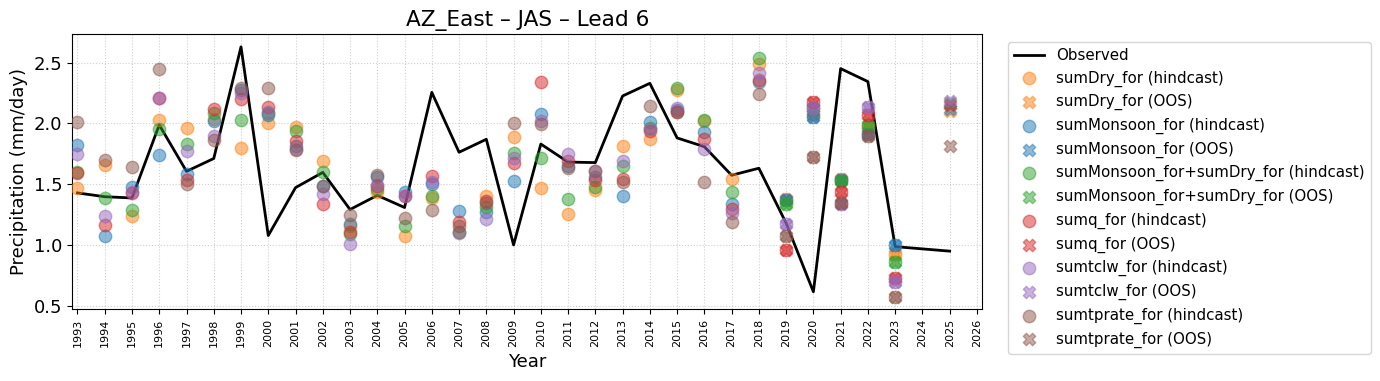

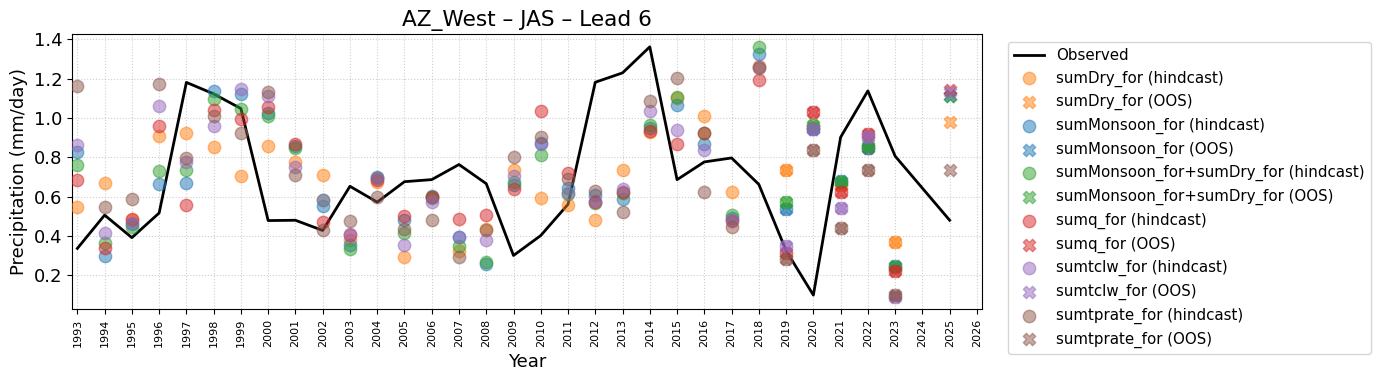

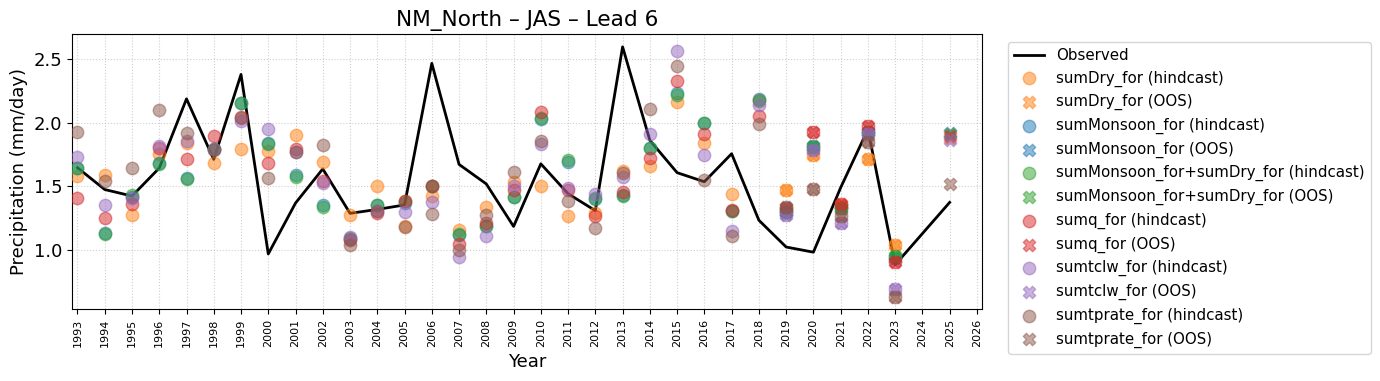

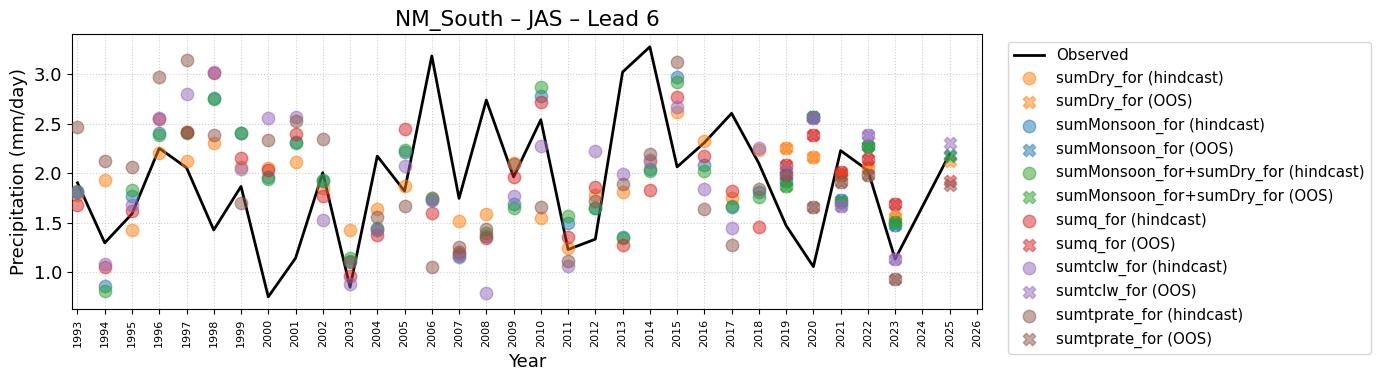

Plots/JAS_AZ_East_Lead6_axis-1993-2026_type-both.png
Plots/JAS_AZ_West_Lead6_axis-1993-2026_type-both.png
Plots/JAS_NM_North_Lead6_axis-1993-2026_type-both.png
Plots/JAS_NM_South_Lead6_axis-1993-2026_type-both.png


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# ---------------- user settings ----------------
INPUT_CSV = "ecmwf_prediction_final.csv"
SELECTED_SEASON = "JAS"
SELECTED_LEAD = 6
SELECTED_TYPE = "both"   # "hindcast", "oos", or "both"
OUT_DIR = "Plots"
os.makedirs(OUT_DIR, exist_ok=True)
# ------------------------------------------------

# read CSV
df = pd.read_csv(INPUT_CSV)

# required columns
lead_col = "lead"
required = {"region", "season", "year", lead_col, "observed", "predicted", "predictor"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns in {INPUT_CSV}: {missing}")

# detect 'type' column and values
has_type = "type" in df.columns
types_present = sorted(df["type"].dropna().unique()) if has_type else []

# heuristics for common type tags
hindcast_tag_guesses = ["ecmwf-hindcast", "hindcast", "ecmwf_hindcast"]
oos_tag_guesses       = ["ecmwf-out-of-sample", "ecmwf-out_of_sample", "oos", "out_of_sample", "ecmwf_oos"]

hind_tag = None
oos_tag  = None
if has_type:
    for t in types_present:
        tl = str(t).lower()
        if (hind_tag is None) and any(g.lower() == tl for g in hindcast_tag_guesses):
            hind_tag = t
        if (oos_tag is None) and any(g.lower() == tl for g in oos_tag_guesses):
            oos_tag = t
    # fallback: if tags not found but there are at least two types, take first two
    if (hind_tag is None or oos_tag is None) and len(types_present) >= 2:
        hind_tag, oos_tag = types_present[0], types_present[1]

# normalize season & numeric fields
df["season"] = df["season"].astype(str).str.upper()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df[lead_col] = pd.to_numeric(df[lead_col], errors="coerce")
df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
df["observed"] = pd.to_numeric(df["observed"], errors="coerce")

# filter season & lead
d_all = df[df["season"] == str(SELECTED_SEASON).upper()].copy()
d_all = d_all[d_all[lead_col] == SELECTED_LEAD].copy()
d_all = d_all.dropna(subset=["year"])

if d_all.empty:
    raise ValueError("No rows found for season/lead selection.")

# determine min/max years from data (separately for hindcast and oos when available)
years_hind = None
years_oos  = None
if has_type and (hind_tag is not None or oos_tag is not None):
    if hind_tag is not None:
        yrs = pd.to_numeric(d_all.loc[d_all["type"] == hind_tag, "year"], errors="coerce").dropna().astype(int)
        if not yrs.empty:
            years_hind = (int(yrs.min()), int(yrs.max()))
    if oos_tag is not None:
        yrs = pd.to_numeric(d_all.loc[d_all["type"] == oos_tag, "year"], errors="coerce").dropna().astype(int)
        if not yrs.empty:
            years_oos = (int(yrs.min()), int(yrs.max()))

# if type-tags not found or types absent, fall back to overall data span
if (years_hind is None) and (years_oos is None):
    overall_years = d_all["year"].dropna().astype(int)
    min_year = int(overall_years.min())
    max_year = int(overall_years.max())
else:
    mins = []
    maxs = []
    if years_hind is not None:
        mins.append(years_hind[0]); maxs.append(years_hind[1])
    if years_oos is not None:
        mins.append(years_oos[0]); maxs.append(years_oos[1])
    if not mins or not maxs:
        raise ValueError("Could not determine years from dataset.")
    min_year = int(min(mins))
    max_year = int(max(maxs))

# extend axis one year beyond last data year (so axis_end = max_year + 1)
axis_end = max_year + 1
# Build full year ticks: min_year .. axis_end inclusive
full_years = np.arange(min_year, axis_end + 1)
year_index = pd.Index(full_years, name="year")

# dedupe while preserving 'type' if present
if has_type:
    dedupe_keys = ["region", "predictor", "year", "type"]
else:
    dedupe_keys = ["region", "predictor", "year"]
d_all = d_all.drop_duplicates(subset=dedupe_keys, keep="last")

# optionally filter SELECTED_TYPE
if SELECTED_TYPE.lower() == "hindcast":
    if not has_type or hind_tag is None:
        raise KeyError("hindcast requested but cannot detect hindcast type in data.")
    d_all = d_all[d_all["type"] == hind_tag].copy()
elif SELECTED_TYPE.lower() == "oos":
    if not has_type or oos_tag is None:
        raise KeyError("oos requested but cannot detect OOS type in data.")
    d_all = d_all[d_all["type"] == oos_tag].copy()
# else "both": keep both types

# global predictor list
all_predictors = sorted(d_all["predictor"].dropna().unique())
cmap = plt.get_cmap("tab10")

# ---- color mapping per your rule:
#   - contains BOTH 'dry' and 'monsoon' -> green
#   - contains only 'dry' -> orange
#   - contains only 'monsoon' -> blue
#   - otherwise -> tab10 color
# (matching is case-insensitive)
predictor_colors = {}
for i, p in enumerate(all_predictors):
    pl = p.lower()
    has_dry = "dry" in pl
    has_monsoon = "monsoon" in pl
    if has_dry and has_monsoon:
        predictor_colors[p] = "tab:green"
    elif has_dry:
        predictor_colors[p] = "tab:orange"
    elif has_monsoon:
        predictor_colors[p] = "tab:blue"
    else:
        predictor_colors[p] = cmap(i % cmap.N)
# -----------------------------------------------------------------------

# markers
marker_for_hind = "o"
marker_for_oos  = "X"

saved_paths = []

for region in sorted(d_all["region"].dropna().unique()):
    dr = d_all[d_all["region"] == region].copy()

    # observed timeseries reindexed to the flexible full axis
    obs_yearly = (
        dr.drop_duplicates(subset=["year"], keep="last")[["year", "observed"]]
          .set_index("year")
          .reindex(year_index)
          .sort_index()
    )

    predictors = sorted(dr["predictor"].dropna().unique())

    fig, ax = plt.subplots(figsize=(14, 4))

    # observed: draw line segments only on years with data (gaps where NaN)
    obs_mask = obs_yearly["observed"].notna()
    if obs_mask.any():
        ax.plot(obs_yearly.index.values[obs_mask], obs_yearly["observed"].values[obs_mask],
                color="black", linestyle="-", linewidth=2, label="Observed")

    # predicted: draw points exactly at integer year positions
    plotted_labels = set()
    if SELECTED_TYPE.lower() == "both" and has_type:
        types_here = sorted(dr["type"].dropna().unique())
        for pred in predictors:
            base_color = predictor_colors.get(pred, (0.2, 0.2, 0.2))
            for typ in types_here:
                sub = dr[(dr["predictor"] == pred) & (dr["type"] == typ)][["year", "predicted"]].copy()
                series = sub.set_index("year").reindex(year_index)["predicted"].astype(float)
                mask = ~np.isnan(series.values)
                if (hind_tag is not None) and (typ == hind_tag):
                    marker = marker_for_hind
                    label = f"{pred} (hindcast)"
                elif (oos_tag is not None) and (typ == oos_tag):
                    marker = marker_for_oos
                    label = f"{pred} (OOS)"
                else:
                    marker = marker_for_oos
                    label = f"{pred} ({typ})"

                xs = year_index.values[mask]
                ys = series.values[mask]
                if len(xs) > 0:
                    if label in plotted_labels:
                        ax.scatter(xs, ys, marker=marker, color=base_color, s=80, alpha=0.5,zorder=5)
                    else:
                        ax.scatter(xs, ys, marker=marker, color=base_color, s=80, alpha=0.5,zorder=3, label=label)
                        plotted_labels.add(label)
    else:
        for pred in predictors:
            sub = dr[dr["predictor"] == pred][["year", "predicted"]].copy()
            series = sub.set_index("year").reindex(year_index)["predicted"].astype(float)
            mask = ~np.isnan(series.values)
            xs = year_index.values[mask]
            ys = series.values[mask]
            color = predictor_colors.get(pred, None)
            if len(xs) > 0:
                ax.scatter(xs, ys, marker="o", color=color, s=40, zorder=3, alpha=0.8,label=pred)

    # Force integer ticks at the computed year positions
    ax.xaxis.set_major_locator(FixedLocator(year_index.values))
    ax.set_xticklabels([str(y) for y in year_index.values], rotation=90, fontsize=8)

    ax.set_title(f"{region} – {SELECTED_SEASON} – Lead {int(SELECTED_LEAD)}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Precipitation (mm/day)")
    ax.grid(True, linestyle=":", alpha=0.6)

    # place legend outside on the right and reserve space
    leg = ax.legend(ncols=1, fontsize="small", loc="upper left", bbox_to_anchor=(1.02, 1))
    fig.subplots_adjust(right=0.78)

    ax.set_xlim(year_index.min() - 0.2, year_index.max() + 0.2)
    plt.tight_layout()

    fname = f"{SELECTED_SEASON}_{region.replace(' ','_')}_Lead{int(SELECTED_LEAD)}_axis-{min_year}-{axis_end}_type-{SELECTED_TYPE}.png"
    fpath = os.path.join(OUT_DIR, fname)
    plt.savefig(fpath, dpi=150, bbox_inches="tight")
    plt.show()
    saved_paths.append(fpath)

for p in saved_paths:
    print(p)
